In [4]:
import os
import imageio
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage import feature
from scipy import ndimage, misc

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [5]:
#Used when reading images
letterDict={
  "a": 0,"b": 1,"c": 2,"d": 3,"e": 4,"f": 5,"g": 6,"h": 7,"i": 8,
    "j": 9,"k": 10,"l": 11,"m": 12,"n": 13,"o": 14,"p": 15,"q": 16,"r": 17,
    "s": 18,"t": 19,"u": 20,"v": 21,"w": 22,"x": 23,"y": 24,"z": 25}

#Used when printing images
numberDict={
    0:"A", 1:"B", 2:"C", 3:"D", 4:"E", 5:"F", 6:"G", 7:"H", 8:"I",
    9:"J", 10:"K", 11:"L", 12:"M", 13:"N", 14:"O", 15:"P", 16:"Q", 17:"R",
    18:"S", 19:"T", 20:"U", 21:"V", 22:"W", 23:"X", 24:"Y", 25:"Z"}


def readPicture(df_complete, directory,letter_value):
    im = imageio.imread(directory)
    im.shape
    print("Letter value: ", directory, end="\r")

    im=np.reshape(im,400)
    df = pd.DataFrame(data=im).T
    y = np.repeat(0,400)
    df['Letter'] = letter_value
    
    return df_complete.append(df, ignore_index=True)

#Method ment for adding augmented pictures to a dataset
def addPictureToDataset(dataset, picture, letter_value):
    picture = np.reshape(picture,400)
    df = pd.DataFrame(data=picture).T
    df['Letter'] = letter_value
    return dataset.append(df, ignore_index=True)

### Data augmentation Zoom (Added to the dataset in read_all_images()):

In [ ]:

def cv2_clipped_zoom(img, zoom_factor):
    """
    Center zoom in/out of the given image and returning an enlarged/shrinked view of 
    the image without changing dimensions
    Args:
        img : Image array
        zoom_factor : amount of zoom as a ratio (0 to Inf)
    """
    height, width = img.shape[:2] # It's also the final desired shape
    new_height, new_width = int(height * zoom_factor), int(width * zoom_factor)

    ### Crop only the part that will remain in the result (more efficient)
    # Centered bbox of the final desired size in resized (larger/smaller) image coordinates
    y1, x1 = max(0, new_height - height) // 2, max(0, new_width - width) // 2
    y2, x2 = y1 + height, x1 + width
    bbox = np.array([y1,x1,y2,x2])
    # Map back to original image coordinates
    bbox = (bbox / zoom_factor).astype(np.int)
    y1, x1, y2, x2 = bbox
    cropped_img = img[y1:y2, x1:x2]

    # Handle padding when downscaling
    resize_height, resize_width = min(new_height, height), min(new_width, width)
    pad_height1, pad_width1 = (height - resize_height) // 2, (width - resize_width) //2
    pad_height2, pad_width2 = (height - resize_height) - pad_height1, (width - resize_width) - pad_width1
    pad_spec = [(pad_height1, pad_height2), (pad_width1, pad_width2)] + [(0,0)] * (img.ndim - 2)

    result = cv2.resize(cropped_img, (resize_width, resize_height))
    result = np.pad(result, pad_spec, mode='constant')
    assert result.shape[0] == height and result.shape[1] == width
    return result
# print(original_raw[0].tolist())

#"./dataset3/chars74k-lite/a/a_4.jpg"
def zoom_images_and_save(path,ending):
    #img = imageio.imread(path)
    #plt.imshow(img)
    #plt.show()
    
    img = imageio.imread(path)
    zoomed = cv2_clipped_zoom(img, 0.5)
    # plt.imshow(zoomed)

    out_path = "./dataset3/augmented/"
    # zoomed = plt.imread(image_path)

   
    fullpath = os.path.join(out_path, 'zoomed'+'_' + ending)

    imageio.imwrite(fullpath, zoomed)
    return zoomed

### Loading all images and augmenting. Loading into dataframes

In [6]:
def read_all_images(upper_directory):
    number_of_images = 0
    original_imgs = pd.DataFrame()
    aug20 = pd.DataFrame()
    aug90 = pd.DataFrame()
    aug270 = pd.DataFrame()
    aug320 = pd.DataFrame()
    for subdir, dirs, files in os.walk(upper_directory):
        for file in files:
            number_of_images+=1
            #print os.path.join(subdir, file)
            filepath = subdir + os.sep + file
            if filepath.endswith(".jpg"):
                # print(filepath)
                # Rotate every image that is being loaded:
            
                x = filepath.split("/")
                rotate20 = rotate_image(filepath,x[-1],20)
                rotate90 = rotate_image(filepath,x[-1],90)
                rotate270 = rotate_image(filepath,x[-1],270)
                rotate320 = rotate_image(filepath,x[-1],320)
                
                # zoomed:
                zoomed = zoom_images_and_save(filepath,x[-1])
            
                # The label for the data:
                letter = (x[-1][0])
                letter_val = letterDict.get(letter)
                original_imgs = readPicture(original_imgs,filepath,letter_val)
                aug20 = addPictureToDataset(aug20, rotate20, letter_val)
                aug90 = addPictureToDataset(aug90, rotate90, letter_val)
                aug270 = addPictureToDataset(aug270, rotate270, letter_val)
                aug320 = addPictureToDataset(aug320, rotate320, letter_val)

                # zoomed:
                aug320 = addPictureToDataset(aug320, zoomed, letter_val)
                
    print("image")
    # vv.imshow("./dataset3/chars74k-lite/augmented/rotated_neg_a102.jpg")
    print("number_of_images", number_of_images)
    return original_imgs, aug20, aug90, aug270, aug320


#Rotates an image, stores it in a folder and returns the rotated image
def rotate_image(image_path,ending,deg):
    out_path = "./dataset3/augmented/"
    image_to_rotate = plt.imread(image_path)

    # Rotating the image:
    rotated_positive = ndimage.rotate(image_to_rotate, deg, reshape=False)
   
    fullpath = os.path.join(out_path, 'rotated_'+ str(deg) + '_' + ending)

    imageio.imwrite(fullpath, rotated_positive)
    return rotated_positive
                   
# Unaugmented data, no feature selection:            
original_raw, aug20, aug90, aug270, aug320 = read_all_images("./dataset3/chars74k-lite")

imager value:  ./dataset3/chars74k-lite/w/w_42.jpgg ./dataset3/chars74k-lite/r/r_54.jpg ./dataset3/chars74k-lite/r/r_227.jpg ./dataset3/chars74k-lite/r/r_183.jpg ./dataset3/chars74k-lite/t/t_266.jpg ./dataset3/chars74k-lite/s/s_418.jpg ./dataset3/chars74k-lite/s/s_348.jpg ./dataset3/chars74k-lite/a/a_44.jpg./dataset3/chars74k-lite/o/o_440.jpg ./dataset3/chars74k-lite/y/y_25.jpg
number_of_images 7113


In [7]:
#Method prints a letter from a panda dataset. 
#Input must be a single row from a panda dataset (a_letter = data.iloc[0])
def printLetter(letter):
    numpy_letter = letter[0:-1].values
    plt.imshow(numpy_letter.reshape(20,20), cmap = matplotlib.cm.binary)
    plt.axis("off")
    plt.title('Supposed to be {}'.format(numberDict.get(letter['Letter'])), fontsize=20)
    plt.show()
    return


#Method prints to dataset to compare actual image to edge detected image
def printFromStartToStop(start, stop, data1, data2):
    array = np.arange(start, stop)
    for i in range(array.size):
        printLetter(data1.iloc[array[i]])
        printLetter(data2.iloc[array[i]])
    return

def printPred(letter):
    plt.imshow(numpy_letter.reshape(20,20), cmap = matplotlib.cm.binary)
    plt.axis("off")
    plt.title('Supposed to be {}'.format(numberDict.get(letter['Letter'])), fontsize=20)
    plt.show()
    return

In [10]:
#Splitting dataset such that we get 80/20 for each letter
def get_train_test_set(data):
    train_set = pd.DataFrame()
    test_set = pd.DataFrame()
    
    for i in range(26):
        train, test = train_test_split(data.loc[data['Letter']==i], test_size=0.2, shuffle=True)
        
        train_set = train_set.append([train], ignore_index=True)
        test_set = test_set.append([test], ignore_index=True)
    return train_set, test_set


train_set, test_set = get_train_test_set(original_raw)


In [ ]:
#Methood merges dataset1 with dataset2
#Used to merge originale dataset with augmented datasets
def mergeData(dataset1, dataset2):
    return dataset1.append(dataset2, ignore_index=True)

mergedData = mergeData(original_raw, aug20)
mergedData = mergeData(mergedData, aug90)
mergedData = mergeData(mergedData, aug270)
mergedData = mergeData(mergedData, aug320)
#mergedData

# Feature Engineering

## Scaling Methods

In [10]:
#Scale features using StandardScaler. Assumes the features are from 0 to 399.

#The scaled values are not between -1 and 1. This is strange and may
#indicate that this scaler is not working out.
def standardScaling(data):
    scaled_data = pd.DataFrame()
    scaler = preprocessing.StandardScaler()
    features = np.arange(400)
    for i in range(data.shape[0]):
        print("StandardScaling Data: {}".format(i), end="\r")
        letter = data['Letter'].iloc[i]
        im = data[features].iloc[i].values
        im = im.reshape(20,20)
        im = im.astype(float)
        scaled_im = scaler.fit_transform(im)
        scaled_data = addPictureToDataset(scaled_data, scaled_im, letter)
    return scaled_data


#Scale features using MinMaxScaler. Assumes the features are from 0 to 399.
def minMaxScaling(data):
    scaled_data = pd.DataFrame()
    scaler = preprocessing.MinMaxScaler()
    features = np.arange(400)
    for i in range(data.shape[0]):
        print("MinMaxScaling Data: {}".format(i), end="\r")
        letter = data['Letter'].iloc[i]
        im = data[features].iloc[i].values
        im = im.reshape(20,20)
        im = im.astype(float)
        scaled_im = scaler.fit_transform(im)
        scaled_data = addPictureToDataset(scaled_data, scaled_im, letter)
    return scaled_data


#Divides all features by 255 to get a number between 0 and 1. 
#Not a preferred method.
def simpleScale(data):
    scaled_data = pd.DataFrame()
    features = np.arange(400)
    for i in range(data.shape[0]):
        print("Simply Scaling Data: {}".format(i), end="\r")
        letter = data['Letter'].iloc[i]
        im = data[features].iloc[i].values
        im = im.reshape(20,20)
        im = im.astype(float)
        scaled_im = im/255
        scaled_data = addPictureToDataset(scaled_data, scaled_im, letter)
    return scaled_data


## Edge Detecting Method

In [11]:
#Edge detector. Use the original dataset as input (not scaled)
# sigma_value is a float between 0 and 3. sigma_value=1 is preferred 
def detectEdges(data, sigma_value):
    edgeDetected_data = pd.DataFrame()
    features = np.arange(400)
    for i in range(data.shape[0]):
        print("Detecting Edge in Dataset: {}".format(i), end="\r")
        letter = data['Letter'].iloc[i]
        numpy_data = data[features].iloc[i].values
        im = numpy_data.reshape(20,20)
        edge_im = feature.canny(im, sigma=sigma_value)
        edge_im = edge_im.astype(float)
        edgeDetected_data = addPictureToDataset(edgeDetected_data, edge_im, letter)
    return edgeDetected_data


## Loading the Different Datasets

In [159]:
#Divide ever number in original dataset by 255
simple_data = simpleScale(original_raw)

In [7]:
#Load scaled datasets:
std_scaled_data = standardScaling(original_raw)
min_max_data = minMaxScaling(original_raw)




#std_scaled_data
#min_max_data

In [121]:
#Load Merged Data
mergedData_side = mergeData(original_raw, aug90)
mergedData_side = mergeData(mergedData_side, aug270)

#Scale Merged_side Data
std_scaled_data_side = standardScaling(mergedData_side)
min_max_data_side = minMaxScaling(mergedData_side)

In [82]:
#Scale Merged Data
std_scaled_merged = standardScaling(mergedData)
min_max_data_merged = minMaxScaling(mergedData)

In [120]:
#Load detectedEdges dataset with sigma_value = 1
edge_detected_data1 = detectEdges(original_raw, 1)

#Load detectedEdges dataset with sigma_value = 1.5
edge_detected_data15 = detectEdges(original_raw, 1.5)

In [181]:
#Load detectedEdges on Merged_side with sigma_value = 1
edge_detected_merged_side1 = detectEdges(mergedData_side, 1)
print()
#Load detectedEdges on Merged_side with sigma_value = 1.5
edge_detected_merged_side15 = detectEdges(mergedData_side, 1.5)


Detecting Edge in Dataset: 21335


In [85]:
#Load detectedEdges on Merged with sigma_value = 1
edge_detected_merged1 = detectEdges(mergedData, 1)
print()
#Load detectedEdges on Merged with sigma_value = 1.5
edge_detected_merged15 = detectEdges(mergedData, 1.5)


std_scaled_merged = std_scaled_data_side
min_max_merged = min_max_data_side


In [72]:
#Load training and test set of merged data
train_org, test_org = get_train_test_set(original_raw)
train_merge_side, test_merge_side = get_train_test_set(mergedData_side)
train_merge, test_merge = get_train_test_set(mergedData)


## KNN Model Method

In [21]:
def calc_predictions(classifier, train):
    y_pred = []
    n = train.shape[0]
    counter = 0
    clf = classifier.fit(train.drop(labels='Letter', axis = 1), train.iloc[:,-1])
    for row in train.drop(labels='Letter', axis = 1).iterrows():
        y_pred.append(clf.predict([row[1].tolist()]))
        counter +=1
        print("Percent Complete: {0:f}%".format(counter*100/n),end="\r")
    return y_pred,clf

def test_classifier(clf, data):
    y = []
    for row in data.drop(labels='Letter', axis = 1).iterrows():
        y.append(clf.predict(([row[1].tolist()])))
    return y

def runKNN(dataset, n_neigh, name):
    #Get MinMaxScaling training and test dataset:
    train_set, test_set = get_train_test_set(dataset)

    #Run kNN model
    neigh = KNeighborsClassifier(n_neighbors=n_neigh)
    y_train, clf = calc_predictions(neigh, train_set)
    y_test = test_classifier(clf, test_set)

    #Print Accuracy
    print("KNN Accuracy Score on {0} Data with {1} Neighbours:".format(name, n_neigh))
    print("Training Set:\t{}".format(accuracy_score( train_set.iloc[:,-1],y_train)))
    # Test:
    print("Test Set:\t{}".format( accuracy_score( test_set.iloc[:,-1],y_test)))
    return clf

### Running KNN on Different Datasets

In [ ]:
#On SimpleScaled dataset
runKNN(simple_data, 3, "SimpleScaled")
print()
runKNN(simple_data, 5, "SimpleScaled")

In [22]:
#On the original dataset
runKNN(original_raw, 3, "Original")
print()
clf_n = runKNN(original_raw, 5, "original")

KNN Accuracy Score on Original Data with 3 Neighbours:
Training Set:	0.8394366197183099
Test Set:	0.6892458100558659

KNN Accuracy Score on original Data with 5 Neighbours:
Training Set:	0.8163732394366198
Test Set:	0.6808659217877095


In [151]:
#On the StandardScaled dataset
runKNN(std_scaled_data, 3, "StandardScaled")
print()
runKNN(std_scaled_data, 5, "StandardScaled")

KNN Accuracy Score on StandardScaled Data with 3 Neighbours:
Training Set:	0.8373239436619718
Test Set:	0.6794692737430168

KNN Accuracy Score on StandardScaled Data with 5 Neighbours:
Training Set:	0.8161971830985916
Test Set:	0.710195530726257


In [152]:
#On the MinMaxScaled dataset
runKNN(min_max_data, 3, "MinMaxScaled")
print()
runKNN(min_max_data, 5, "MinMaxScaled")

KNN Accuracy Score on MinMaxScaled Data with 3 Neighbours:
Training Set:	0.8589788732394367
Test Set:	0.7171787709497207

KNN Accuracy Score on MinMaxScaled Data with 5 Neighbours:
Training Set:	0.836443661971831
Test Set:	0.7465083798882681


In [156]:
runKNN(min_max_data, 7, "MinMaxScaled")

KNN Accuracy Score on MinMaxScaled Data with 7 Neighbours:
Training Set:	0.8205985915492958
Test Set:	0.7255586592178771


In [153]:
#On the EdgeDetected dataset with sigma=1
runKNN(edge_detected_data1, 3, "EdgeDetected Sigma = 1")
print()
runKNN(edge_detected_data1, 5, "EdgeDetected Sigma = 1")

KNN Accuracy Score on EdgeDetected Sigma = 1 Data with 3 Neighbours:
Training Set:	0.7566901408450705
Test Set:	0.5370111731843575

KNN Accuracy Score on EdgeDetected Sigma = 1 Data with 5 Neighbours:
Training Set:	0.7017605633802817
Test Set:	0.5600558659217877


In [154]:
#On the EdgeDetected dataset with sigma = 1.5
runKNN(edge_detected_data15, 3, "EdgeDetected Sigma = 1.5")
print()
runKNN(edge_detected_data15, 5, "EdgeDetected Sigma = 1.5")

KNN Accuracy Score on EdgeDetected Sigma = 1.5 Data with 3 Neighbours:
Training Set:	0.7470070422535211
Test Set:	0.5677374301675978

KNN Accuracy Score on EdgeDetected Sigma = 1.5 Data with 5 Neighbours:
Training Set:	0.6971830985915493
Test Set:	0.5439944134078212


In [157]:
#On the Merged StandardScaled dataset
runKNN(std_scaled_data_side, 3, "Merged StandardScaled")
print()
runKNN(std_scaled_data_side, 5, "Mergedn StandardScaled")

KNN Accuracy Score on Merged StandardScaled Data with 3 Neighbours:
Training Set:	0.829845847253971
Test Set:	0.6856140350877193

KNN Accuracy Score on Mergedn StandardScaled Data with 5 Neighbours:
Training Set:	0.7903405427583378
Test Set:	0.6837426900584795


In [158]:
#On the Merged_side MinMaxScaled dataset
runKNN(min_max_data_side, 3, "Merged MinMaxScaled")
print()
runKNN(min_max_data_side, 5, "Merged MinMaxScaled")

KNN Accuracy Score on Merged MinMaxScaled Data with 3 Neighbours:
Training Set:	0.8519430279585019
Test Set:	0.7031578947368421

KNN Accuracy Score on Merged MinMaxScaled Data with 5 Neighbours:
Training Set:	0.8175370728562218
Test Set:	0.7127485380116959


## Random Forest Method

In [14]:
def runRandomForest(dataset, n_est, name):
    #Get MinMaxScaling training and test dataset:
    train_set, test_set = get_train_test_set(dataset)

    #Run RF model
    clf_rf = RandomForestClassifier(n_estimators=n_est,random_state=0)
    y_train, clf = calc_predictions(clf_rf, train_set)
    y_test = test_classifier(clf, test_set)

    #Print Accuracy
    print("RF Accuracy Score on {0} Data with {1} Estimators:".format(name, n_est))
    print("Training Set:\t{}".format(accuracy_score( train_set.iloc[:,-1],y_train)))
    # Test:
    print("Test Set:\t{}".format( accuracy_score( test_set.iloc[:,-1],y_test)))
    return

### Running RF on Different Datasets

In [171]:
#On the original dataset
runRandomForest(original_raw, 20, "Original")
print()
runRandomForest(simple_data, 20, "SimpleScale")
print()
#On the StandardScaled dataset
runRandomForest(std_scaled_data, 20, "StandardScaled")
print()
#On the MinMaxScaled dataset
runRandomForest(min_max_data, 20, "MinMaxScaled")
print()
#On the EdgeDetected dataset with sigma=1
runRandomForest(edge_detected_data1, 20, "EdgeDetected Sigma = 1")
print()
#On the EdgeDetected dataset with sigma=1
runRandomForest(edge_detected_data15, 20, "EdgeDetected Sigma = 1.5")

RF Accuracy Score on Original Data with 20 Estimators:
Training Set:	0.9994718309859155
Test Set:	0.6284916201117319

RF Accuracy Score on SimpleScale Data with 20 Estimators:
Training Set:	0.9994718309859155
Test Set:	0.6166201117318436

RF Accuracy Score on StandardScaled Data with 20 Estimators:
Training Set:	1.0
Test Set:	0.6396648044692738

RF Accuracy Score on MinMaxScaled Data with 20 Estimators:
Training Set:	1.0
Test Set:	0.6263966480446927

RF Accuracy Score on EdgeDetected Sigma = 1 Data with 20 Estimators:
Training Set:	1.0
Test Set:	0.4895251396648045

RF Accuracy Score on EdgeDetected Sigma = 1.5 Data with 20 Estimators:
Training Set:	1.0
Test Set:	0.5174581005586593


In [183]:
#On the original dataset
runRandomForest(original_raw, 200, "Original")

RF Accuracy Score on Original Data with 200 Estimators:
Training Set:	1.0
Test Set:	0.6962290502793296


In [184]:
#On the StandardScaled dataset
runRandomForest(std_scaled_data, 200, "StandardScaled")

RF Accuracy Score on StandardScaled Data with 200 Estimators:
Training Set:	1.0
Test Set:	0.7011173184357542


In [185]:
#On the MinMaxScaled dataset
runRandomForest(min_max_data, 200, "MinMaxScaled")

RF Accuracy Score on MinMaxScaled Data with 200 Estimators:
Training Set:	1.0
Test Set:	0.6836592178770949


In [186]:
#On the EdgeDetected dataset with sigma=1
runRandomForest(edge_detected_data1, 200, "EdgeDetected Sigma = 1")

RF Accuracy Score on EdgeDetected Sigma = 1 Data with 200 Estimators:
Training Set:	1.0
Test Set:	0.6019553072625698


In [187]:
#On the EdgeDetected dataset with sigma=1
runRandomForest(edge_detected_data15, 200, "EdgeDetected Sigma = 1.5")

RF Accuracy Score on EdgeDetected Sigma = 1.5 Data with 200 Estimators:
Training Set:	1.0
Test Set:	0.6026536312849162


In [177]:
#On the original dataset
runRandomForest(original_raw, 500, "Original")
print()
#On the StandardScaled dataset
runRandomForest(std_scaled_data, 500, "StandardScaled")
print()
#On the MinMaxScaled dataset
runRandomForest(min_max_data, 500, "MinMaxScaled")


RF Accuracy Score on Original Data with 500 Estimators:
Training Set:	1.0
Test Set:	0.7087988826815642

RF Accuracy Score on StandardScaled Data with 500 Estimators:
Training Set:	1.0
Test Set:	0.7136871508379888

RF Accuracy Score on MinMaxScaled Data with 500 Estimators:
Training Set:	1.0
Test Set:	0.6913407821229051


# Tensorflow

In [14]:
import tensorflow as tf
import gzip
import pickle

def DNN(train_X,train_Y,test_X,test_y, ep, nodes):
    # Scale data (normalization), easier for network to learn:
    # plt.imshow(train_X[0])
    # plt.show
    train_X = tf.keras.utils.normalize(train_X,axis=1)
    test_X = tf.keras.utils.normalize(test_X,axis=1)

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(nodes, activation = tf.nn.relu )) 
    model.add(tf.keras.layers.Dense(nodes, activation = tf.nn.relu )) 
    model.add(tf.keras.layers.Dense(26, activation = tf.nn.softmax ))

    model.compile(optimizer ='adam',
                 loss='sparse_categorical_crossentropy',metrics=['accuracy'])

    # train:
    model.fit(train_X, train_Y, epochs = ep)
    loss, accuracy = evaluate_model(model,test_X,test_y)
    return loss, accuracy, model


# Helper function trained model:
def evaluate_model(model,test_X,test_y):
    val_loss, val_acc = model.evaluate(test_X, test_y)
    return val_loss, val_acc


# train and test are dataframes (with the labels in the last column for both)
def transform_data_for_tensorflow_and_run(train,test, ep, nodes):
    trainx = (train.drop(labels='Letter', axis = 1)).values
    trainy = np.array(train['Letter'].tolist())
    
    testx = (test.drop(labels='Letter', axis = 1)).values
    testy = np.array(test['Letter'].tolist())
    loss, accuracy, model_tensor = DNN(trainx,trainy,testx,testy, ep, nodes)
    
    return loss, accuracy, model_tensor


### Running DNN on Datasets

In [15]:
def runDNN(dataset, name, ep, nodes):
    train, test = get_train_test_set(dataset)
    loss, acc, model_tensor = transform_data_for_tensorflow_and_run(train,test, ep, nodes)
    
    #Print Accuracy
    print("\nDNN Accuracy Score on {0} with {1} Epochs and {2} Nodes:".format(name, ep, nodes))
    print("Loss:\t\t{0}".format(loss))
    # Test:
    print("Accuracy:\t{0}\n".format(acc))
    return model_tensor

In [16]:
model_tensor = runDNN(original_raw, "Original Data", 18, 651)

Epoch 1/18
5680/5680 [==============================] - 2s 422us/sample - loss: 2.7617 - acc: 0.2273
Epoch 2/18
5680/5680 [==============================] - 2s 313us/sample - loss: 1.7737 - acc: 0.4815
Epoch 3/18
5680/5680 [==============================] - 2s 321us/sample - loss: 1.3382 - acc: 0.6164
Epoch 4/18
5680/5680 [==============================] - 2s 320us/sample - loss: 1.0850 - acc: 0.6836
Epoch 5/18
5680/5680 [==============================] - 2s 349us/sample - loss: 0.9229 - acc: 0.7368
Epoch 6/18
5680/5680 [==============================] - 2s 276us/sample - loss: 0.7931 - acc: 0.7695
Epoch 7/18
5680/5680 [==============================] - 2s 278us/sample - loss: 0.6894 - acc: 0.7996
Epoch 8/18
5680/5680 [==============================] - 2s 269us/sample - loss: 0.6195 - acc: 0.8220
Epoch 9/18
5680/5680 [==============================] - 2s 295us/sample - loss: 0.5340 - acc: 0.8569
Epoch 10/18
5680/5680 [==============================] - 2s 325us/sample - loss: 0.4729 - a

In [135]:
runDNN(original_raw, "Original Data", 35, 267)
runDNN(std_scaled_data, "StandardScaled Original Data", 35, 267)
runDNN(min_max_data, "MinMaxScaled Original Data", 35, 267)

Epoch 1/35
5680/5680 [==============================] - 2s 300us/sample - loss: 2.9542 - acc: 0.1577
Epoch 2/35
5680/5680 [==============================] - 1s 147us/sample - loss: 2.2008 - acc: 0.4044
Epoch 3/35
5680/5680 [==============================] - 1s 148us/sample - loss: 1.6774 - acc: 0.5016
Epoch 4/35
5680/5680 [==============================] - 1s 153us/sample - loss: 1.4048 - acc: 0.5961
Epoch 5/35
5680/5680 [==============================] - 1s 147us/sample - loss: 1.2170 - acc: 0.6556
Epoch 6/35
5680/5680 [==============================] - 1s 148us/sample - loss: 1.0827 - acc: 0.6933
Epoch 7/35
5680/5680 [==============================] - 1s 147us/sample - loss: 0.9847 - acc: 0.7174
Epoch 8/35
5680/5680 [==============================] - 1s 146us/sample - loss: 0.8955 - acc: 0.7460
Epoch 9/35
5680/5680 [==============================] - 1s 156us/sample - loss: 0.8208 - acc: 0.7657
Epoch 10/35
5680/5680 [==============================] - 1s 160us/sample - loss: 0.7549 - a

In [162]:
runDNN(original_raw, "Original Data", 15, 651)
runDNN(std_scaled_data, "StandardScaled Original Data", 15, 651)
runDNN(min_max_data, "MinMaxScaled Original Data", 15, 651)

Epoch 1/15
5680/5680 [==============================] - 3s 480us/sample - loss: 2.7665 - acc: 0.2222
Epoch 2/15
5680/5680 [==============================] - 2s 320us/sample - loss: 1.7834 - acc: 0.4842
Epoch 3/15
5680/5680 [==============================] - 2s 334us/sample - loss: 1.3474 - acc: 0.6111
Epoch 4/15
5680/5680 [==============================] - 2s 345us/sample - loss: 1.1053 - acc: 0.6854
Epoch 5/15
5680/5680 [==============================] - 2s 326us/sample - loss: 0.9295 - acc: 0.7320
Epoch 6/15
5680/5680 [==============================] - 2s 320us/sample - loss: 0.7962 - acc: 0.7692
Epoch 7/15
5680/5680 [==============================] - 2s 336us/sample - loss: 0.6954 - acc: 0.8007
Epoch 8/15
5680/5680 [==============================] - 2s 331us/sample - loss: 0.6039 - acc: 0.8312
Epoch 9/15
5680/5680 [==============================] - 2s 331us/sample - loss: 0.5276 - acc: 0.8516
Epoch 10/15
5680/5680 [==============================] - 2s 330us/sample - loss: 0.4699 - a

In [180]:
runDNN(original_raw, "Original Data", 3, 128)
runDNN(std_scaled_data, "StandardScaled Original Data", 3, 128)
runDNN(min_max_data, "MinMaxScaled Original Data", 3, 128)
runDNN(edge_detected_data15, "Edge Detected Data", 3, 128)
runDNN(mergedData_side, "Merged Data", 3, 128)


Epoch 1/3
5680/5680 [==============================] - 2s 344us/sample - loss: 3.0276 - acc: 0.1227
Epoch 2/3
5680/5680 [==============================] - 1s 157us/sample - loss: 2.5424 - acc: 0.3095
Epoch 3/3
1432/1432 [==============================] - 1s 814us/sample - loss: 1.8810 - acc: 0.4672

DNN Accuracy Score on Original Data with 3 Epochs and 128 Nodes:
Loss:		1.8809761401661282
Accuracy:	0.4671787619590759

Epoch 1/3
5680/5680 [==============================] - 2s 339us/sample - loss: 2.7646 - acc: 0.2486
Epoch 2/3
5680/5680 [==============================] - 1s 154us/sample - loss: 1.8570 - acc: 0.4903
Epoch 3/3
1432/1432 [==============================] - 1s 796us/sample - loss: 1.3960 - acc: 0.6264

DNN Accuracy Score on StandardScaled Original Data with 3 Epochs and 128 Nodes:
Loss:		1.396045427748611
Accuracy:	0.626396656036377

Epoch 1/3
5680/5680 [==============================] - 2s 340us/sample - loss: 3.0389 - acc: 0.1199
Epoch 2/3
5680/5680 [======================

In [179]:
runDNN(edge_detected_data15, "Edge Detected Data", 18, 651)
runDNN(mergedData_side, "Merged Data", 18, 651)


Epoch 1/18
5680/5680 [==============================] - 4s 644us/sample - loss: 2.5485 - acc: 0.2910
Epoch 2/18
5680/5680 [==============================] - 3s 469us/sample - loss: 1.6990 - acc: 0.5181
Epoch 3/18
5680/5680 [==============================] - 3s 458us/sample - loss: 1.2521 - acc: 0.6532
Epoch 4/18
5680/5680 [==============================] - 3s 446us/sample - loss: 0.9142 - acc: 0.7447
Epoch 5/18
5680/5680 [==============================] - 2s 418us/sample - loss: 0.6441 - acc: 0.8197
Epoch 6/18
5680/5680 [==============================] - 2s 375us/sample - loss: 0.4140 - acc: 0.8963
Epoch 7/18
5680/5680 [==============================] - 2s 354us/sample - loss: 0.2475 - acc: 0.9438
Epoch 8/18
5680/5680 [==============================] - 2s 356us/sample - loss: 0.1307 - acc: 0.9827
Epoch 9/18
5680/5680 [==============================] - 2s 354us/sample - loss: 0.0633 - acc: 0.9967
Epoch 10/18
5680/5680 [==============================] - 2s 351us/sample - loss: 0.0316 - a

In [167]:
runDNN(original_raw, "Original Data", 18, 651)
runDNN(std_scaled_data, "StandardScaled Original Data", 18, 651)
runDNN(min_max_data, "MinMaxScaled Original Data", 18, 651)


Epoch 1/18
5680/5680 [==============================] - 3s 500us/sample - loss: 2.7211 - acc: 0.2336
Epoch 2/18
5680/5680 [==============================] - 2s 328us/sample - loss: 1.7472 - acc: 0.4896
Epoch 3/18
5680/5680 [==============================] - 2s 328us/sample - loss: 1.3287 - acc: 0.6099
Epoch 4/18
5680/5680 [==============================] - 2s 333us/sample - loss: 1.0873 - acc: 0.6889
Epoch 5/18
5680/5680 [==============================] - 2s 336us/sample - loss: 0.9166 - acc: 0.7371
Epoch 6/18
5680/5680 [==============================] - 2s 333us/sample - loss: 0.7841 - acc: 0.7745
Epoch 7/18
5680/5680 [==============================] - 2s 338us/sample - loss: 0.6784 - acc: 0.8053
Epoch 8/18
5680/5680 [==============================] - 2s 325us/sample - loss: 0.5888 - acc: 0.8343s - loss: 0.5866 - acc
Epoch 9/18
5680/5680 [==============================] - 2s 325us/sample - loss: 0.5240 - acc: 0.8491
Epoch 10/18
5680/5680 [==============================] - 2s 336us/sam

In [96]:
runDNN(std_scaled_merged, "StandardScaled Merged Data")
runDNN(min_max_merged, "MinMaxScaled Merged Data")
runDNN(edge_detected_merged1, "Edge Detected Merged Data (sigma=1)")
runDNN(edge_detected_merged15, "Edge Detected Merged Data (sigma=1.5)")

Epoch 1/5
28448/28448 [==============================] - 6s 222us/sample - loss: 2.0546 - acc: 0.4174
Epoch 2/5
28448/28448 [==============================] - 6s 203us/sample - loss: 1.2418 - acc: 0.6463
Epoch 3/5
28448/28448 [==============================] - 6s 203us/sample - loss: 0.9291 - acc: 0.7319
Epoch 4/5
28448/28448 [==============================] - 6s 203us/sample - loss: 0.7130 - acc: 0.7913
Epoch 5/5
7112/7112 [==============================] - 1s 97us/sample - loss: 1.0874 - acc: 0.7116

DNN Accuracy Score on StandardScaled Merged Data:
Loss:	1.087371249284063
Accuracy:	0.711614191532135

Epoch 1/5
28448/28448 [==============================] - 7s 232us/sample - loss: 2.4525 - acc: 0.2926
Epoch 2/5
28448/28448 [==============================] - 6s 207us/sample - loss: 1.6213 - acc: 0.5305
Epoch 3/5
28448/28448 [==============================] - 6s 203us/sample - loss: 1.2823 - acc: 0.6326
Epoch 4/5
28448/28448 [==============================] - 6s 209us/sample - loss: 1.

In [123]:
# Raw set:
l1,a1 = transform_data_for_tensorflow_and_run(train_org,
                                              test_org)


# Merged with 90 and 270 degrees
l2, a2 = transform_data_for_tensorflow_and_run(train_merge_side,
                                               test_merge_side)


# Merged set
l3, a3 = transform_data_for_tensorflow_and_run(train_merge,
                                               test_merge)

print(" ")
print("loss on raw data:", l1)
print("Accuracy on raw data: ", a1)


print(" ")
print("loss on merged_side data:", l2)
print("Accuracy on merged_side data: ",a2)

print(" ")
print("loss on merged data:", l3)
print("Accuracy on merged data: ",a3)

Epoch 1/15
5680/5680 [==============================] - 3s 498us/sample - loss: 2.6396 - acc: 0.2590
Epoch 2/15
5680/5680 [==============================] - 2s 388us/sample - loss: 1.6705 - acc: 0.5114
Epoch 3/15
5680/5680 [==============================] - 2s 418us/sample - loss: 1.2733 - acc: 0.6331
Epoch 4/15
5680/5680 [==============================] - 2s 402us/sample - loss: 1.0153 - acc: 0.7125
Epoch 5/15
5680/5680 [==============================] - 2s 405us/sample - loss: 0.8716 - acc: 0.7489
Epoch 6/15
5680/5680 [==============================] - 2s 403us/sample - loss: 0.7379 - acc: 0.7824
Epoch 7/15
5680/5680 [==============================] - 2s 403us/sample - loss: 0.6421 - acc: 0.8136
Epoch 8/15
5680/5680 [==============================] - 2s 402us/sample - loss: 0.5619 - acc: 0.8386
Epoch 9/15
5680/5680 [==============================] - 2s 404us/sample - loss: 0.4963 - acc: 0.8572
Epoch 10/15
5680/5680 [==============================] - 2s 402us/sample - loss: 0.4249 - a

## Printing some classified images:

ll 
0
Was classified as an: A


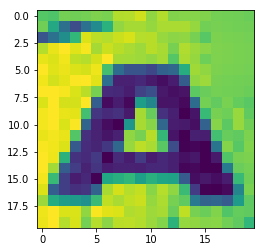

 
1
Was classified as an: A


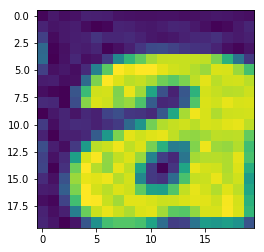

 
2
Was classified as an: A


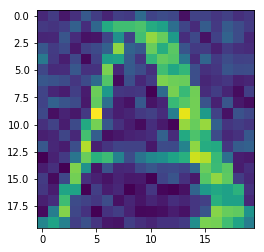

 
3
Was classified as an: A


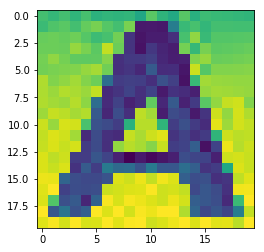

 
4
Was classified as an: A


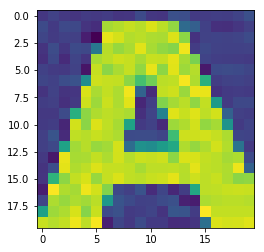

 
5
Was classified as an: A


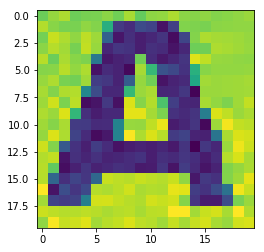

 
6
Was classified as an: A


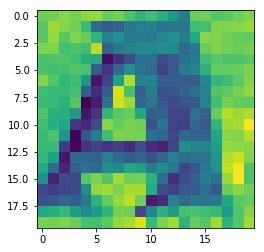

 
7
Was classified as an: A


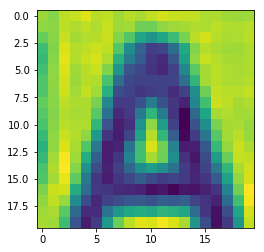

 
8
Was classified as an: A


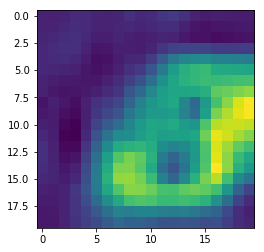

 
9
Was classified as an: A


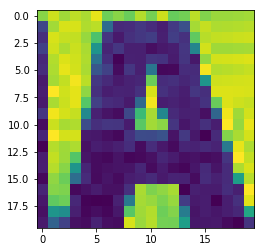

 
10
Was classified as an: A


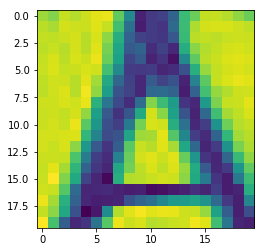

 
11
Was classified as an: A


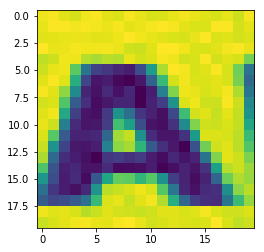

 
12
Was classified as an: A


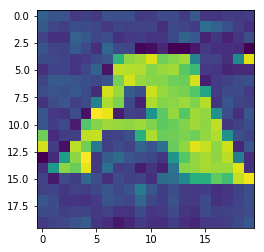

 
13
Was classified as an: A


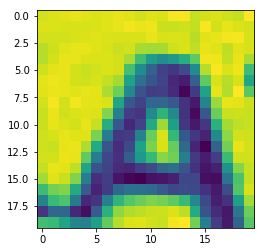

 
14
Was classified as an: A


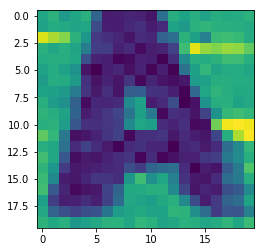

 
15
Was classified as an: A


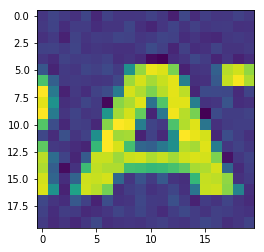

 
16
Was classified as an: A


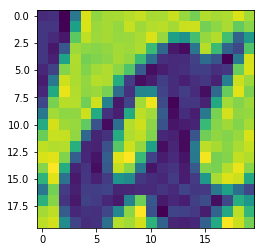

 
17
Was classified as an: A


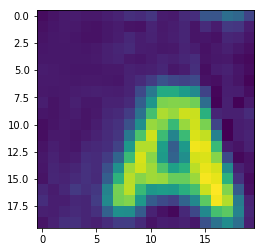

 
18
Was classified as an: A


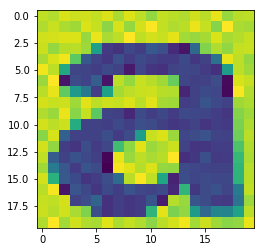

 
19
Was classified as an: A


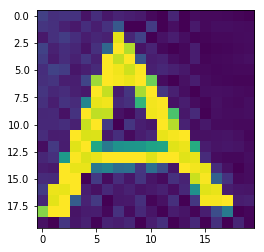

 
20
Was classified as an: A


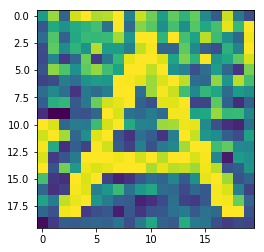

 
21
Was classified as an: A


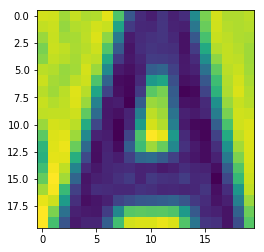

 
22
Was classified as an: A


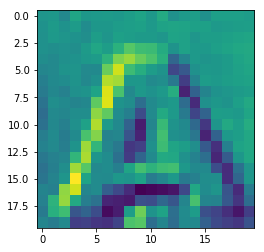

 
23
Was classified as an: A


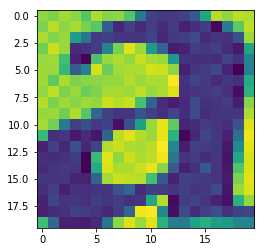

 
24
Was classified as an: A


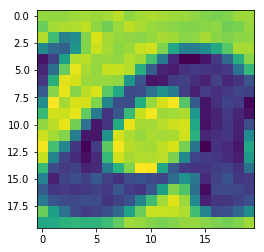

 
25
Was classified as an: A


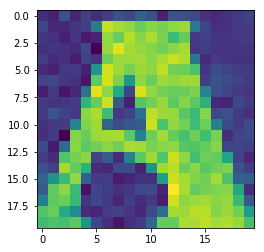

 
26
Was classified as an: A


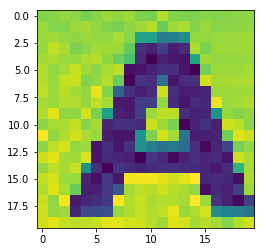

 
27
Was classified as an: A


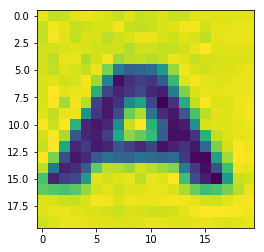

 
28
Was classified as an: A


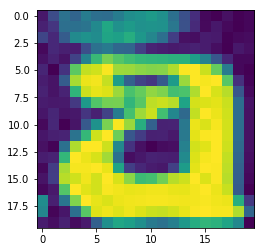

 
29
Was classified as an: A


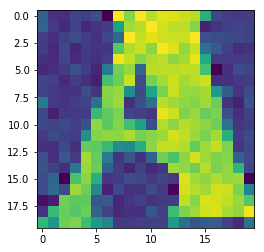

 
30
Was classified as an: A


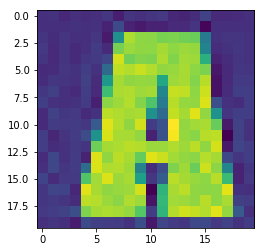

 
31
Was classified as an: A


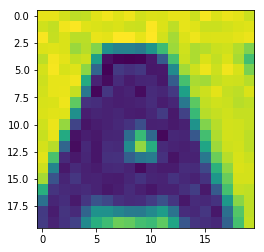

 
32
Was classified as an: A


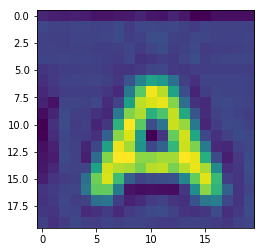

 
33
Was classified as an: A


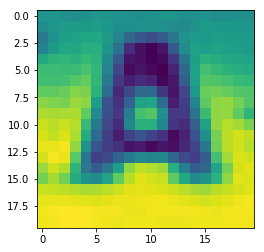

 
34
Was classified as an: A


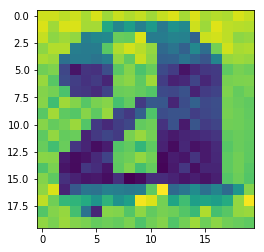

 
35
Was classified as an: A


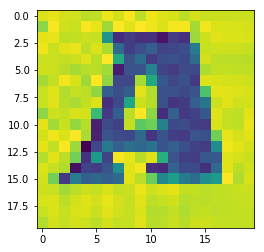

 
36
Was classified as an: A


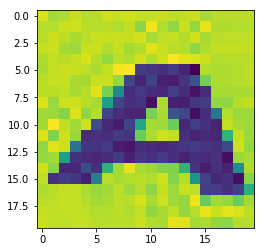

 
37
Was classified as an: A


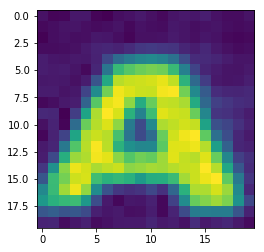

 
38
Was classified as an: A


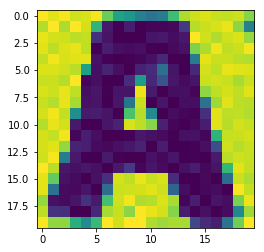

 
39
Was classified as an: A


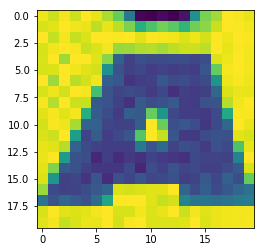

 
40
Was classified as an: A


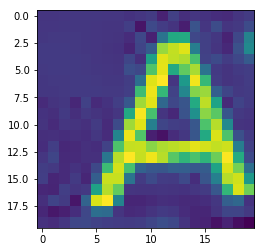

 
41
Was classified as an: A


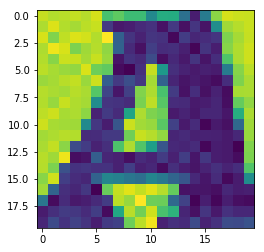

 
42
Was classified as an: A


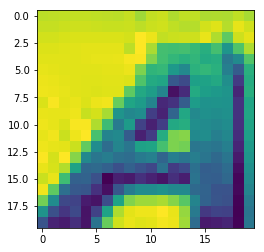

 
43
Was classified as an: A


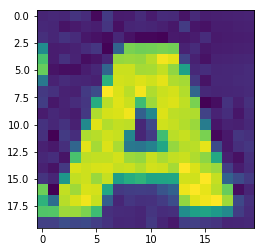

 
44
Was classified as an: A


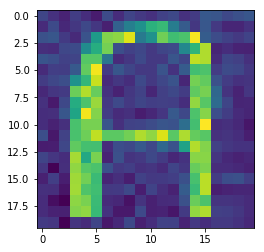

 
45
Was classified as an: A


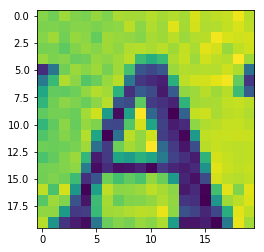

 
46
Was classified as an: A


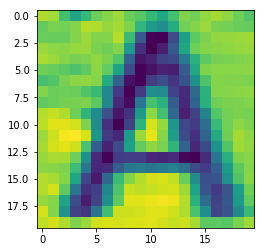

 
47
Was classified as an: A


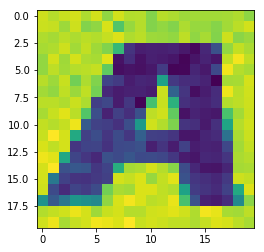

 
48
Was classified as an: A


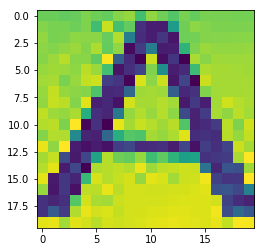

 
49
Was classified as an: A


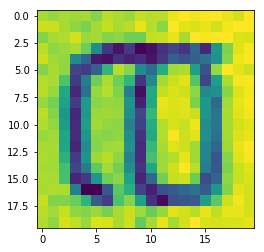

 
50
Was classified as an: A


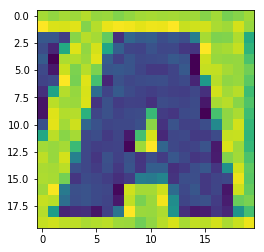

 
51
Was classified as an: A


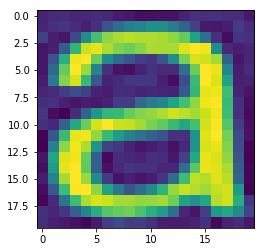

 
52
Was classified as an: A


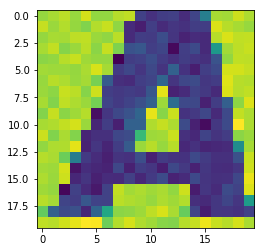

 
53
Was classified as an: A


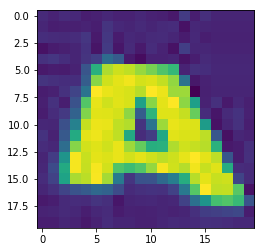

 
54
Was classified as an: A


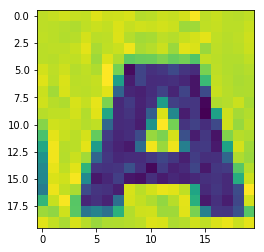

 
55
Was classified as an: A


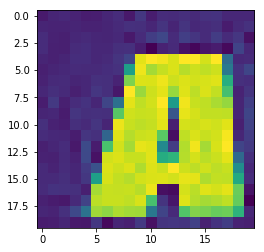

 
56
Was classified as an: A


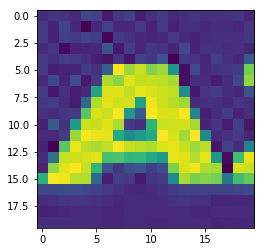

 
57
Was classified as an: A


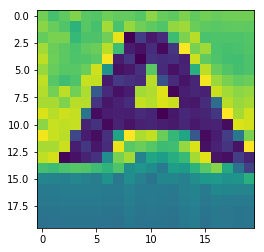

 
58
Was classified as an: A


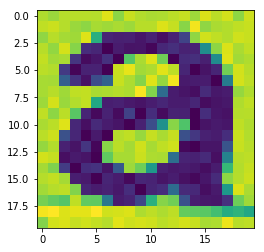

 
59
Was classified as an: A


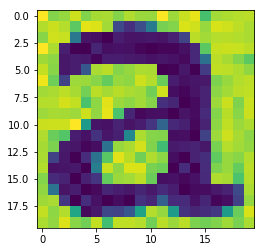

 
60
Was classified as an: A


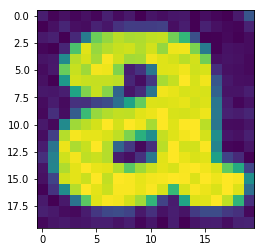

 
61
Was classified as an: A


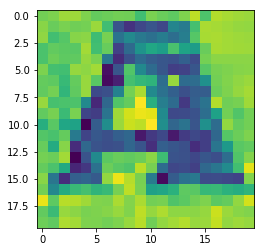

 
62
Was classified as an: A


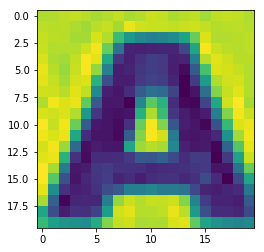

 
63
Was classified as an: A


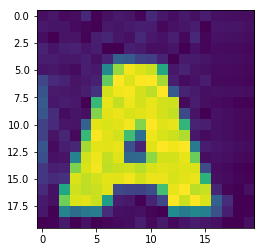

 
64
Was classified as an: A


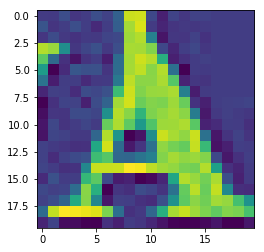

 
65
Was classified as an: A


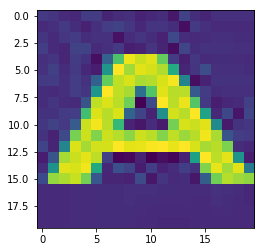

 
66
Was classified as an: A


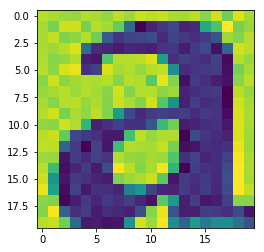

 
67
Was classified as an: A


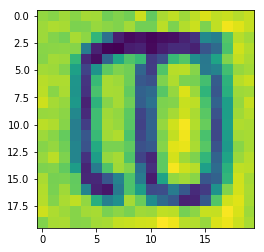

 
68
Was classified as an: A


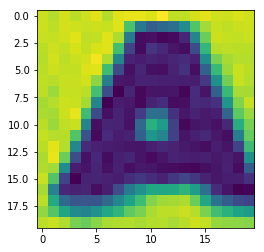

 
69
Was classified as an: A


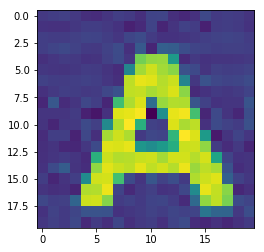

 
70
Was classified as an: A


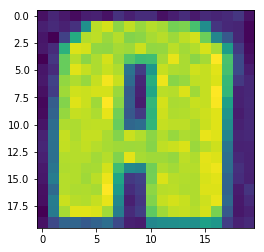

 
71
Was classified as an: A


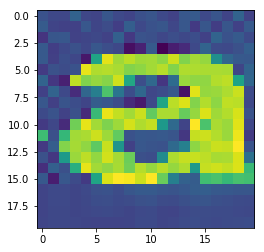

 
72
Was classified as an: A


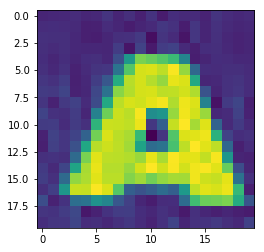

 
73
Was classified as an: A


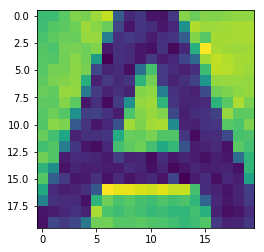

 
74
Was classified as an: A


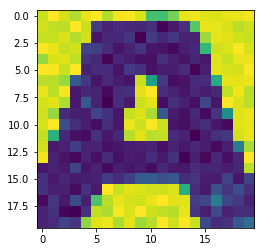

 
75
Was classified as an: A


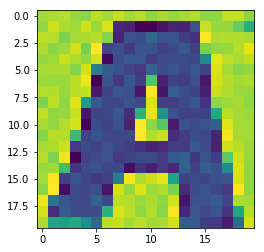

 
76
Was classified as an: A


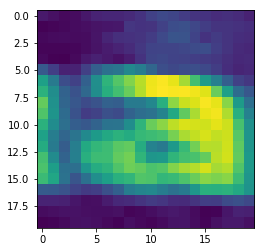

 
77
Was classified as an: A


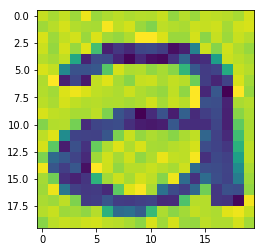

 
78
Was classified as an: A


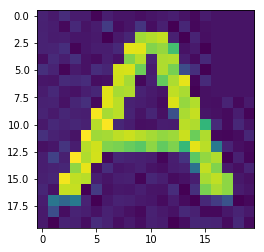

 
79
Was classified as an: A


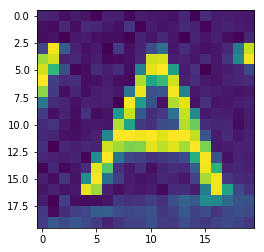

 
80
Was classified as an: A


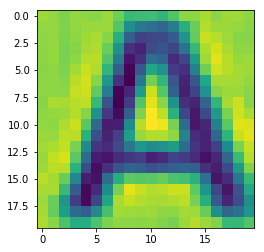

 
81
Was classified as an: A


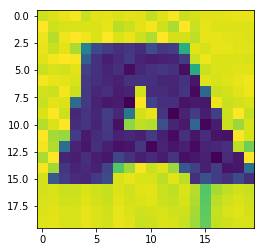

 
82
Was classified as an: A


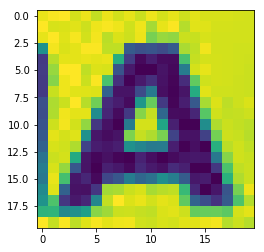

 
83
Was classified as an: A


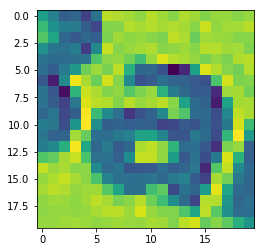

 
84
Was classified as an: A


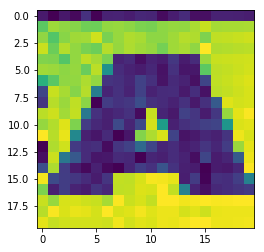

 
85
Was classified as an: A


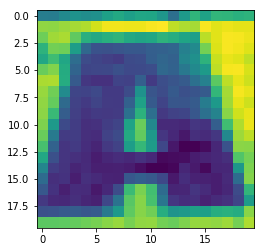

 
86
Was classified as an: A


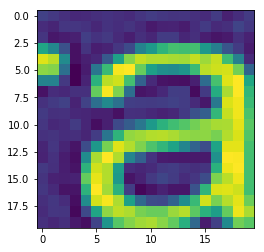

 
87
Was classified as an: A


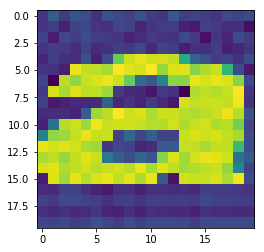

 
88
Was classified as an: A


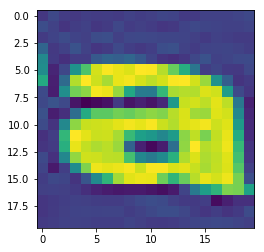

 
89
Was classified as an: A


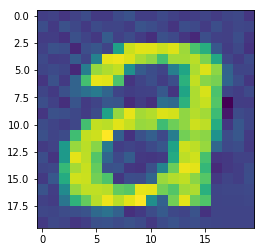

 
90
Was classified as an: A


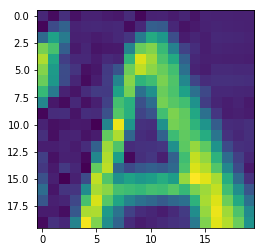

 
91
Was classified as an: A


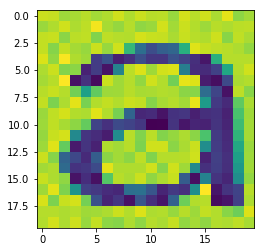

 
92
Was classified as an: A


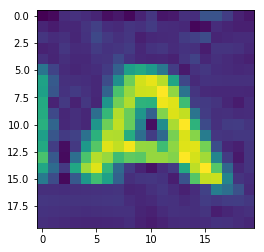

 
93
Was classified as an: A


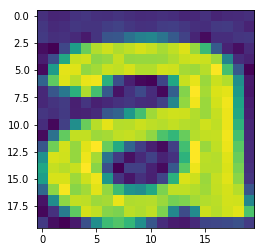

 
94
Was classified as an: A


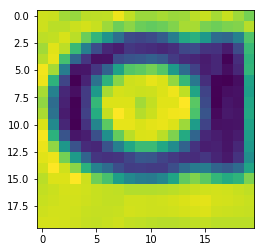

 
95
Was classified as an: A


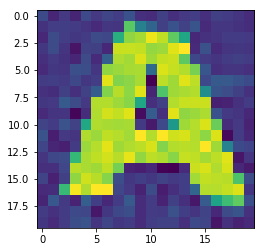

 
96
Was classified as an: A


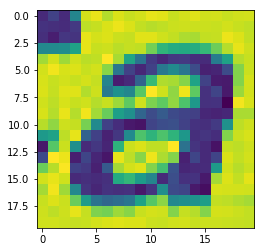

 
97
Was classified as an: A


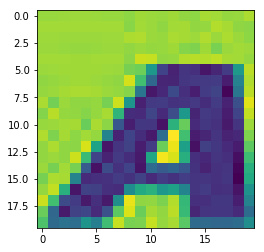

 
98
Was classified as an: A


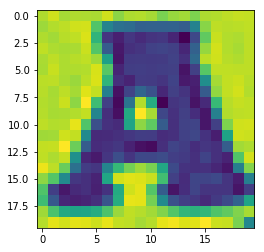

 
99
Was classified as an: A


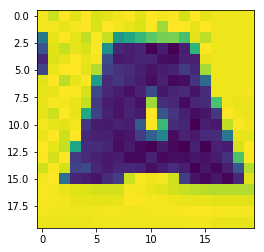

 
100
Was classified as an: A


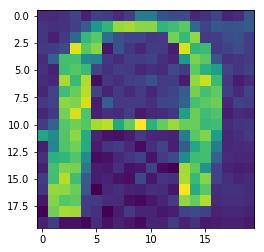

 
101
Was classified as an: A


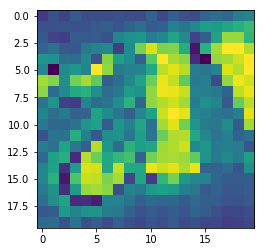

 
102
Was classified as an: A


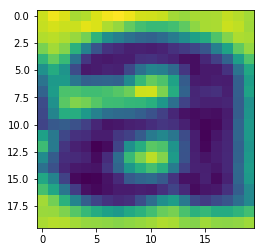

 
103
Was classified as an: A


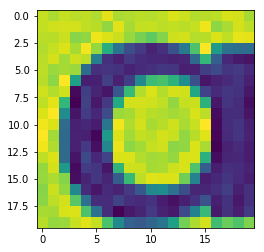

 
104
Was classified as an: A


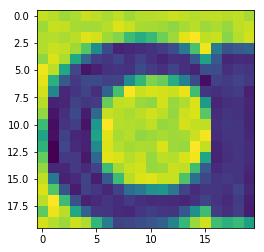

 
105
Was classified as an: A


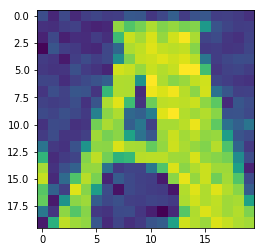

 
106
Was classified as an: A


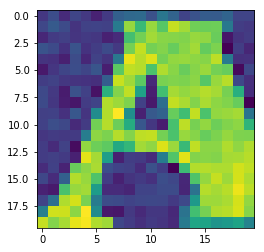

 
107
Was classified as an: A


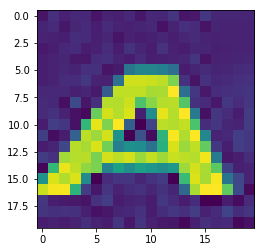

 
108
Was classified as an: A


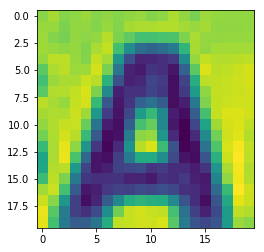

 
109
Was classified as an: A


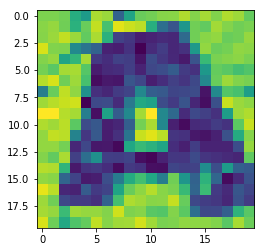

 
110
Was classified as an: E


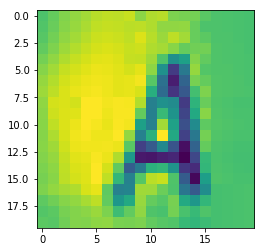

 
111
Was classified as an: A


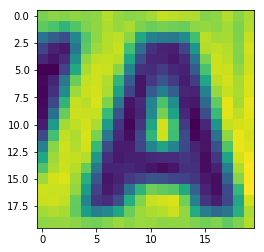

 
112
Was classified as an: A


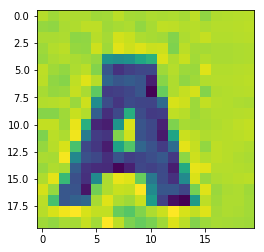

 
113
Was classified as an: A


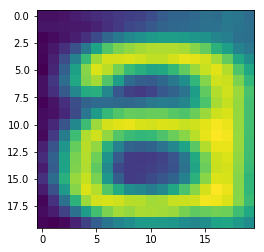

 
114
Was classified as an: A


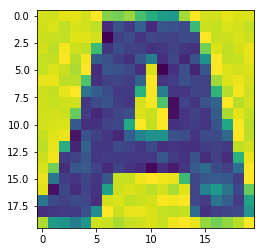

 
115
Was classified as an: A


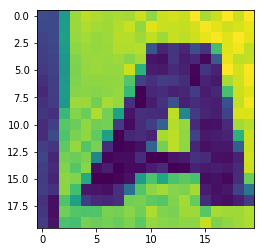

 
116
Was classified as an: A


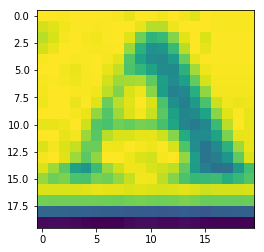

 
117
Was classified as an: A


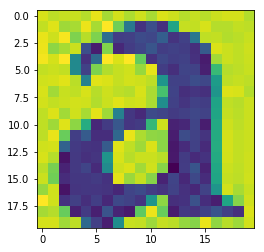

 
118
Was classified as an: A


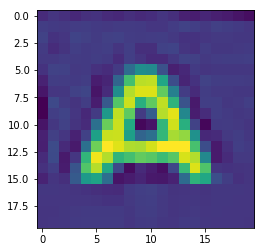

 
119
Was classified as an: A


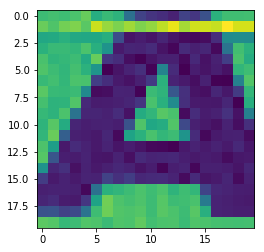

 
120
Was classified as an: A


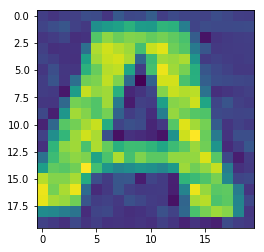

 
121
Was classified as an: A


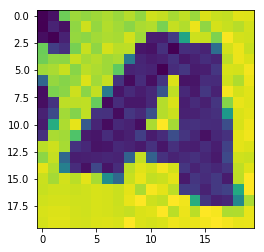

 
122
Was classified as an: A


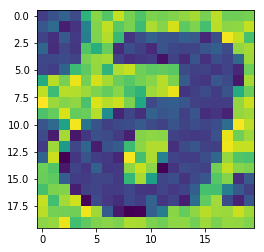

 
123
Was classified as an: A


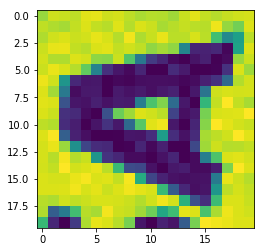

 
124
Was classified as an: A


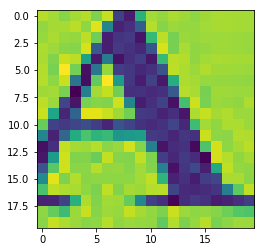

 
125
Was classified as an: A


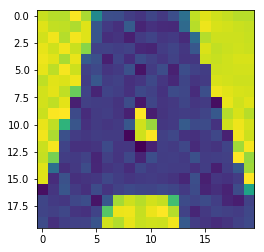

 
126
Was classified as an: A


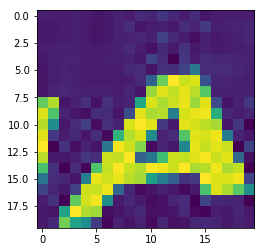

 
127
Was classified as an: A


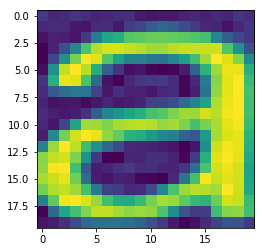

 
128
Was classified as an: A


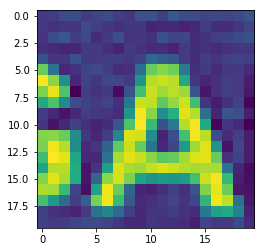

 
129
Was classified as an: A


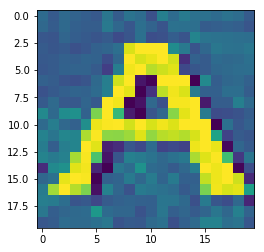

 
130
Was classified as an: A


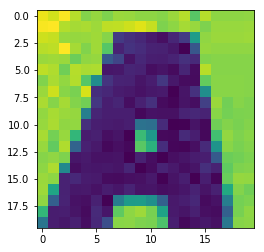

 
131
Was classified as an: A


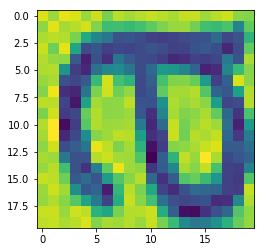

 
132
Was classified as an: A


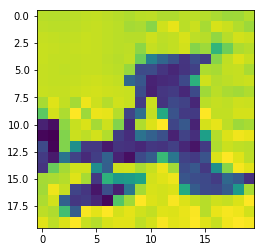

 
133
Was classified as an: A


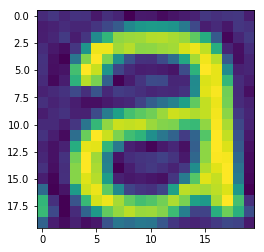

 
134
Was classified as an: A


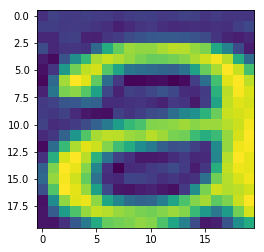

 
135
Was classified as an: A


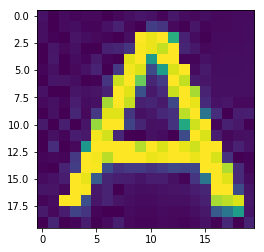

 
136
Was classified as an: A


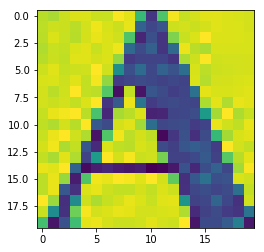

 
137
Was classified as an: A


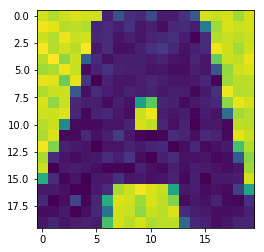

 
138
Was classified as an: A


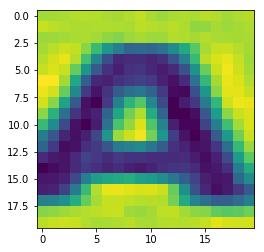

 
139
Was classified as an: A


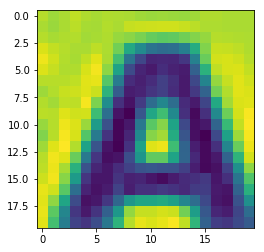

 
140
Was classified as an: A


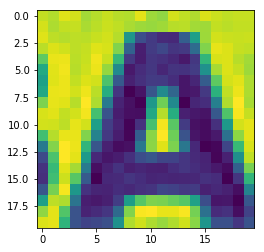

 
141
Was classified as an: A


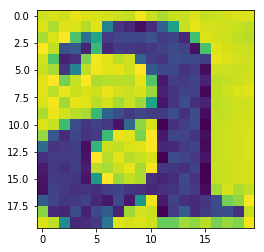

 
142
Was classified as an: B


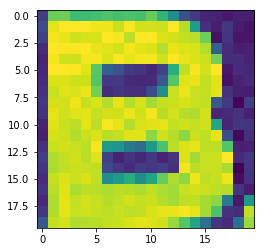

 
143
Was classified as an: B


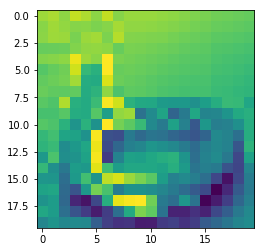

 
144
Was classified as an: B


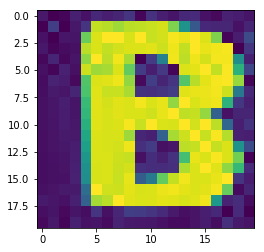

 
145
Was classified as an: B


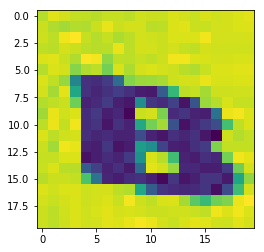

 
146
Was classified as an: B


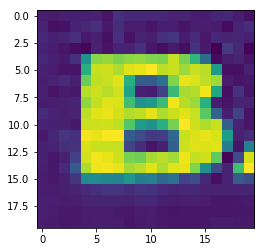

 
147
Was classified as an: B


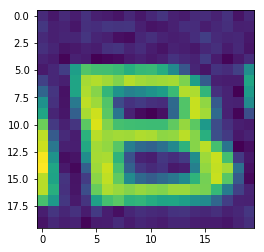

 
148
Was classified as an: B


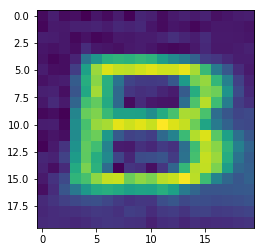

 
149
Was classified as an: B


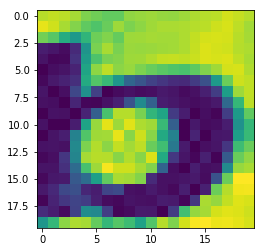

 
150
Was classified as an: B


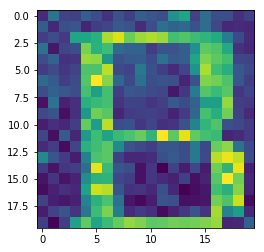

 
151
Was classified as an: B


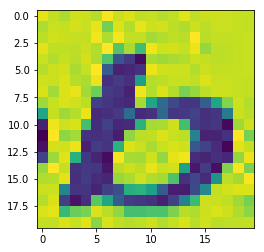

 
152
Was classified as an: B


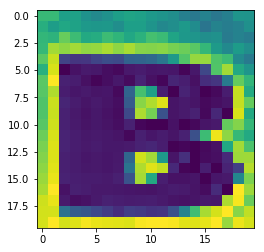

 
153
Was classified as an: E


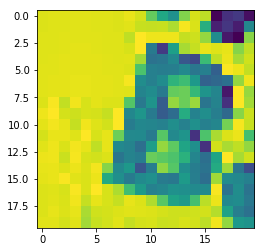

 
154
Was classified as an: B


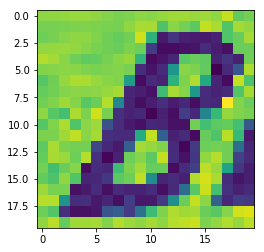

 
155
Was classified as an: B


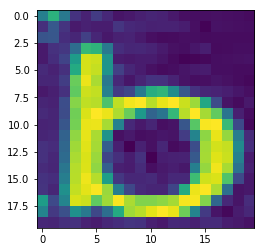

 
156
Was classified as an: B


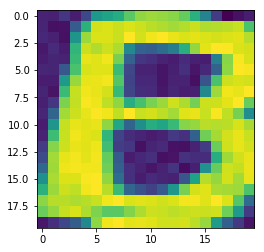

 
157
Was classified as an: B


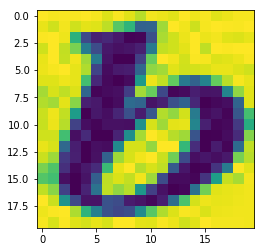

 
158
Was classified as an: B


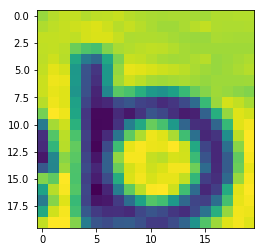

 
159
Was classified as an: B


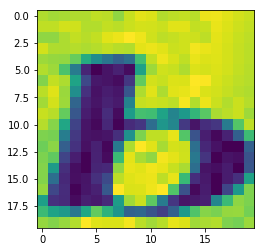

 
160
Was classified as an: B


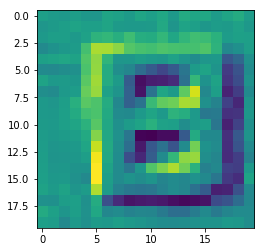

 
161
Was classified as an: A


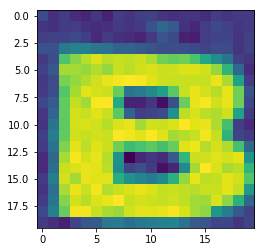

 
162
Was classified as an: B


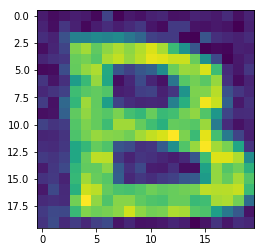

 
163
Was classified as an: B


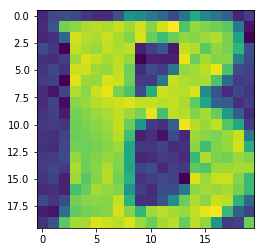

 
164
Was classified as an: B


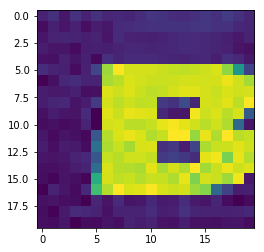

 
165
Was classified as an: B


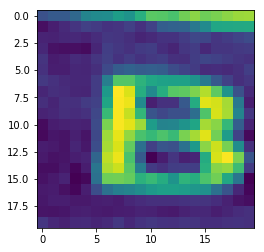

 
166
Was classified as an: B


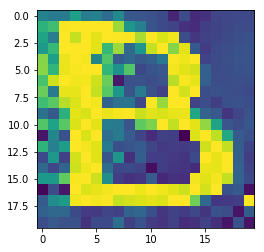

 
167
Was classified as an: B


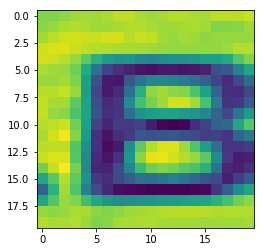

 
168
Was classified as an: B


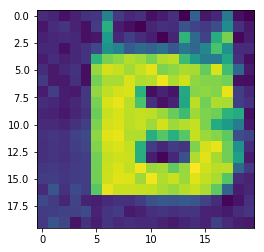

 
169
Was classified as an: B


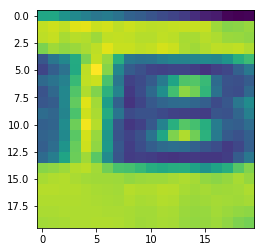

 
170
Was classified as an: B


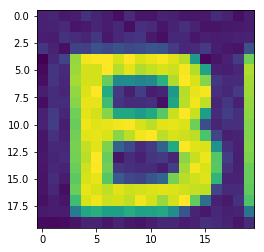

 
171
Was classified as an: B


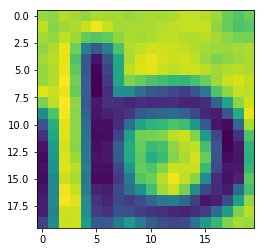

 
172
Was classified as an: B


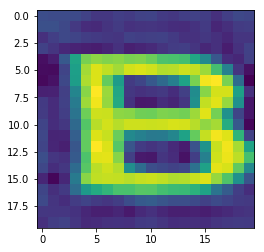

 
173
Was classified as an: C


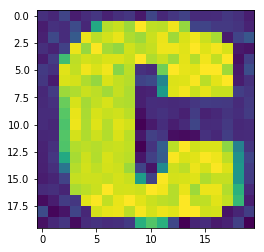

 
174
Was classified as an: C


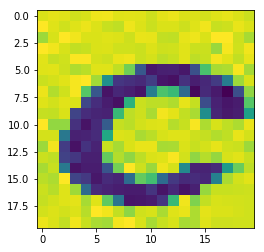

 
175
Was classified as an: C


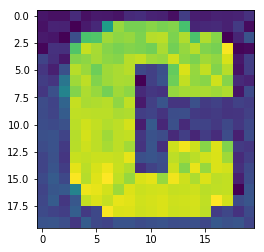

 
176
Was classified as an: C


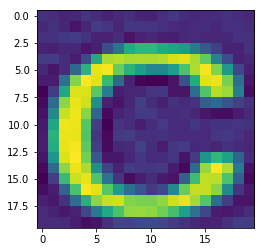

 
177
Was classified as an: C


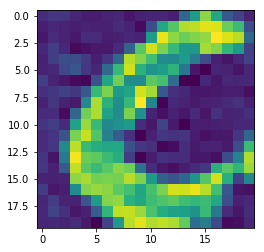

 
178
Was classified as an: C


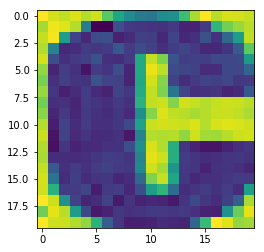

 
179
Was classified as an: C


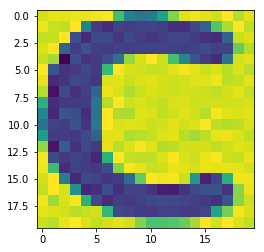

 
180
Was classified as an: C


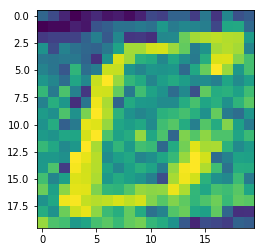

 
181
Was classified as an: C


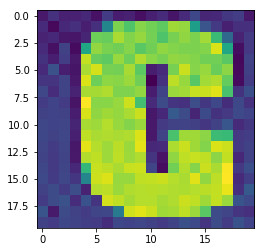

 
182
Was classified as an: C


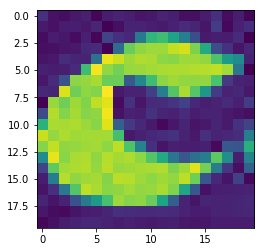

 
183
Was classified as an: C


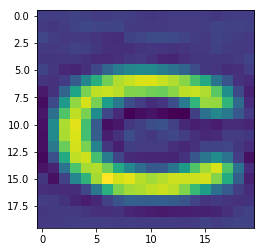

 
184
Was classified as an: O


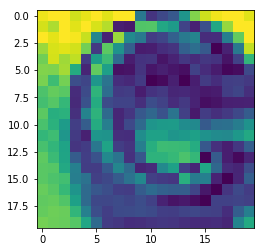

 
185
Was classified as an: C


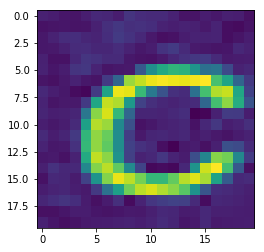

 
186
Was classified as an: C


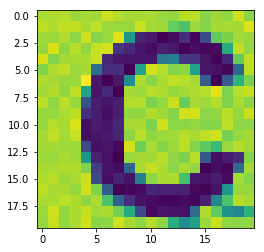

 
187
Was classified as an: C


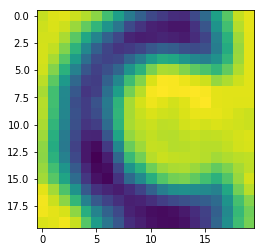

 
188
Was classified as an: C


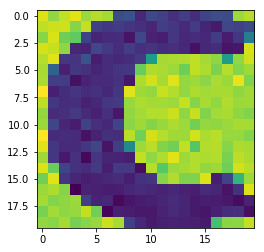

 
189
Was classified as an: C


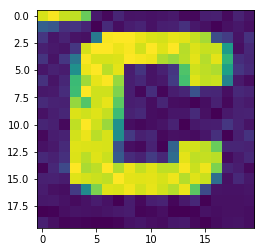

 
190
Was classified as an: C


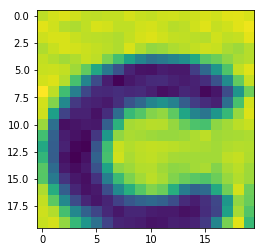

 
191
Was classified as an: C


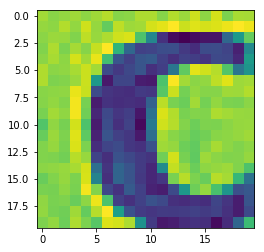

 
192
Was classified as an: C


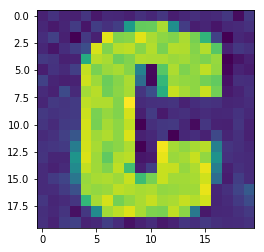

 
193
Was classified as an: C


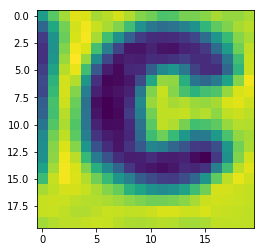

 
194
Was classified as an: C


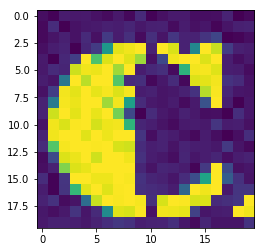

 
195
Was classified as an: C


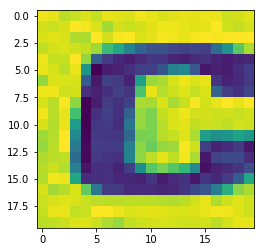

 
196
Was classified as an: C


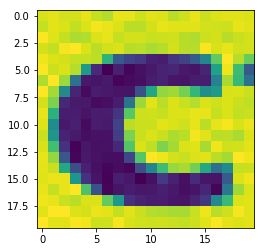

 
197
Was classified as an: C


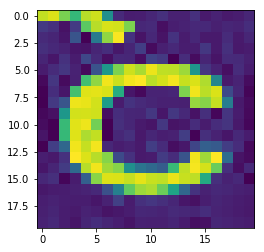

 
198
Was classified as an: C


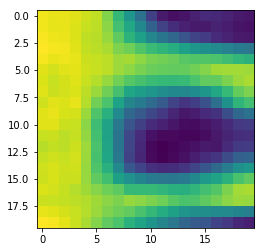

 
199
Was classified as an: C


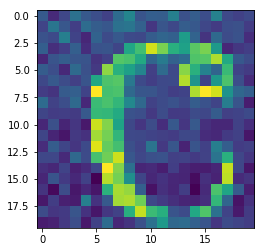

 
200
Was classified as an: C


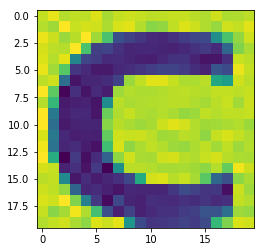

 
201
Was classified as an: C


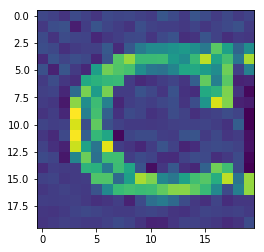

 
202
Was classified as an: C


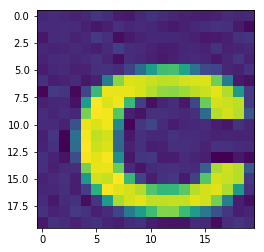

 
203
Was classified as an: C


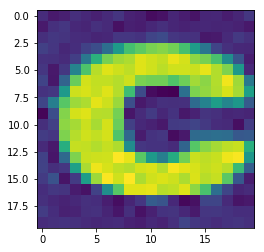

 
204
Was classified as an: C


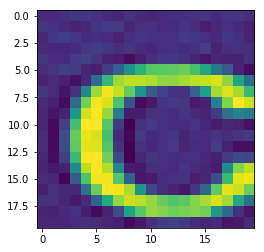

 
205
Was classified as an: C


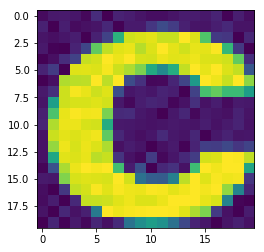

 
206
Was classified as an: C


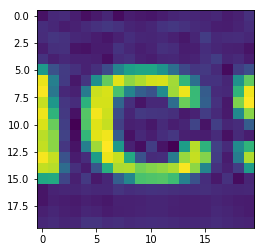

 
207
Was classified as an: C


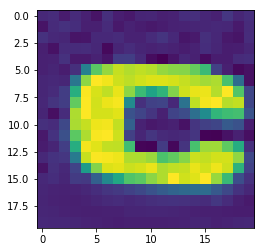

 
208
Was classified as an: C


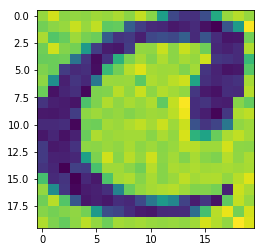

 
209
Was classified as an: C


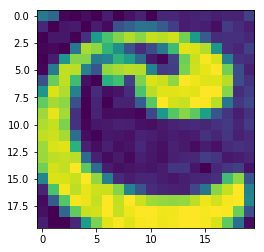

 
210
Was classified as an: C


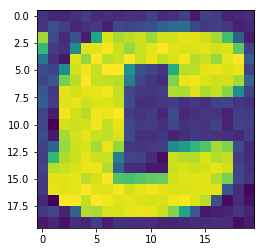

 
211
Was classified as an: C


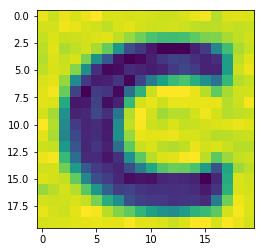

 
212
Was classified as an: C


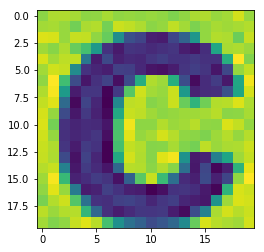

 
213
Was classified as an: C


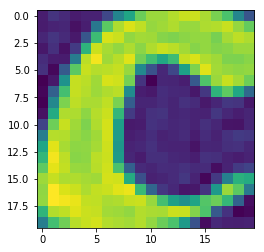

 
214
Was classified as an: C


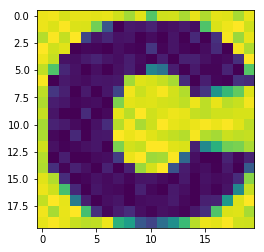

 
215
Was classified as an: C


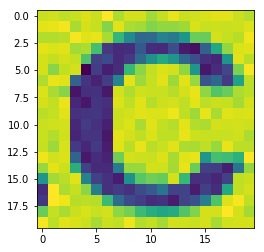

 
216
Was classified as an: C


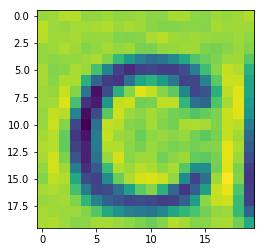

 
217
Was classified as an: C


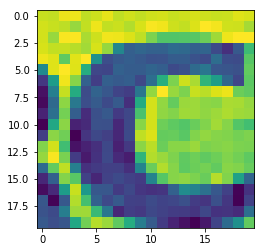

 
218
Was classified as an: C


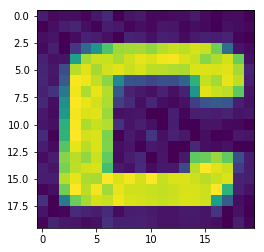

 
219
Was classified as an: C


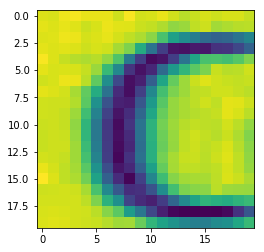

 
220
Was classified as an: C


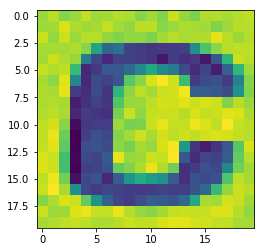

 
221
Was classified as an: C


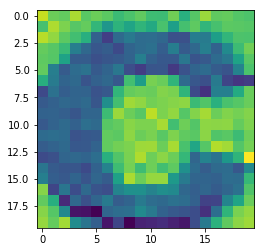

 
222
Was classified as an: C


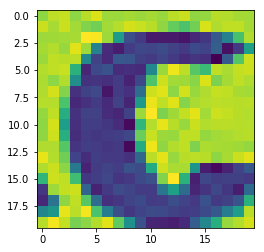

 
223
Was classified as an: C


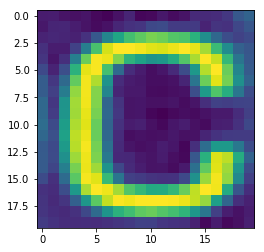

 
224
Was classified as an: C


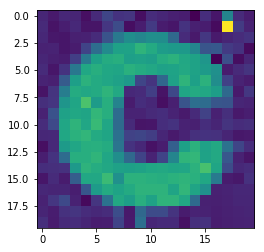

 
225
Was classified as an: C


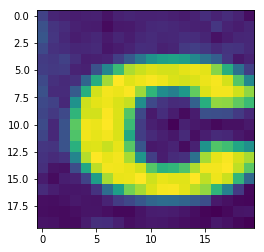

 
226
Was classified as an: C


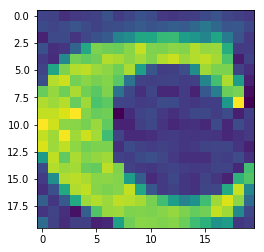

 
227
Was classified as an: C


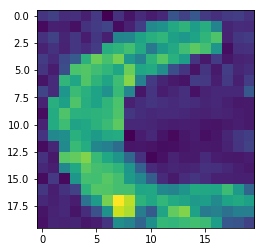

 
228
Was classified as an: C


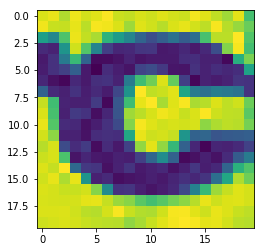

 
229
Was classified as an: D


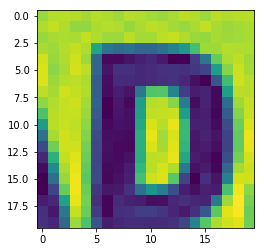

 
230
Was classified as an: O


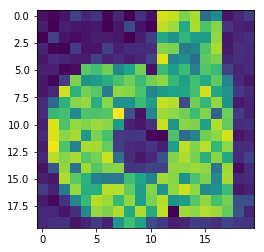

 
231
Was classified as an: D


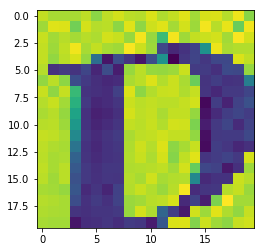

 
232
Was classified as an: D


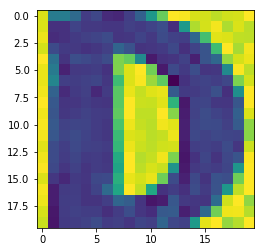

 
233
Was classified as an: D


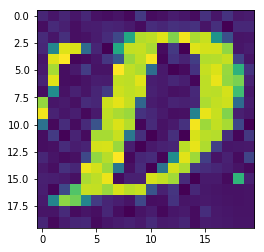

 
234
Was classified as an: D


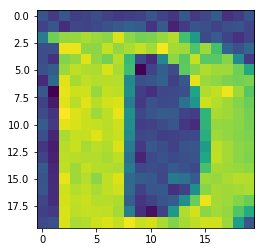

 
235
Was classified as an: O


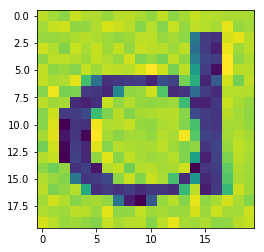

 
236
Was classified as an: D


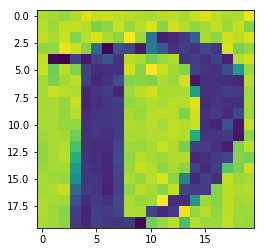

 
237
Was classified as an: D


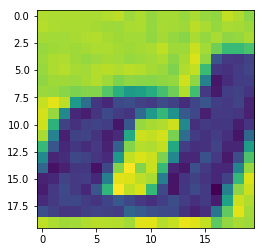

 
238
Was classified as an: D


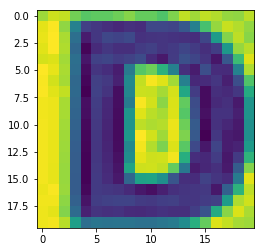

 
239
Was classified as an: O


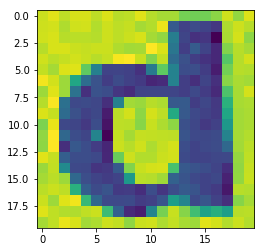

 
240
Was classified as an: D


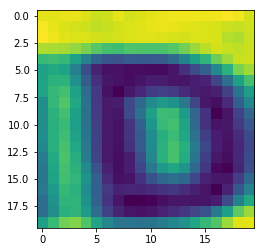

 
241
Was classified as an: A


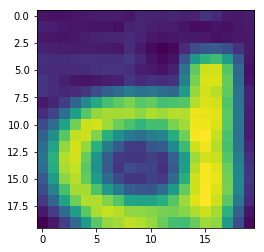

 
242
Was classified as an: D


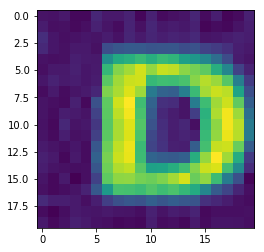

 
243
Was classified as an: O


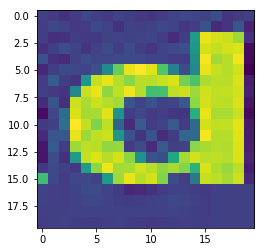

 
244
Was classified as an: D


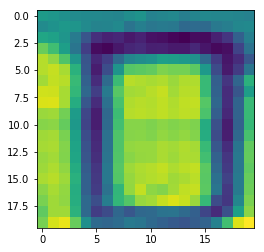

 
245
Was classified as an: D


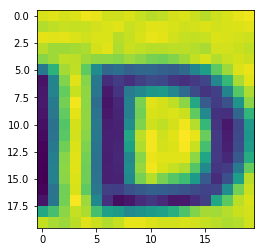

 
246
Was classified as an: D


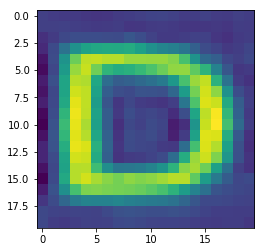

 
247
Was classified as an: D


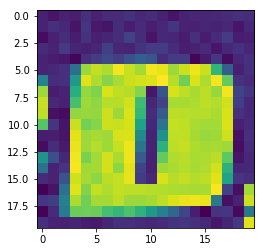

 
248
Was classified as an: D


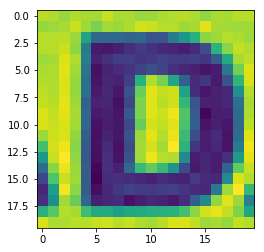

 
249
Was classified as an: D


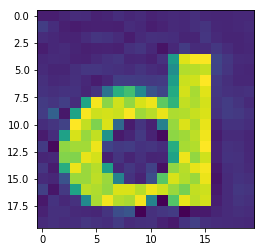

 
250
Was classified as an: D


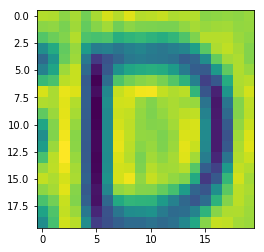

 
251
Was classified as an: D


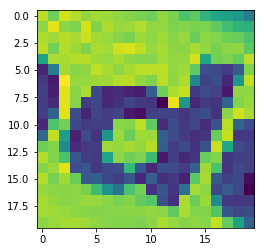

 
252
Was classified as an: D


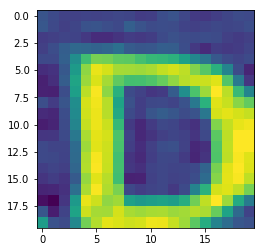

 
253
Was classified as an: D


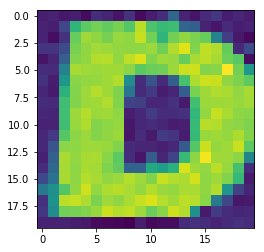

 
254
Was classified as an: D


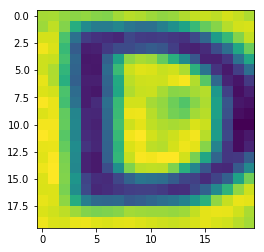

 
255
Was classified as an: A


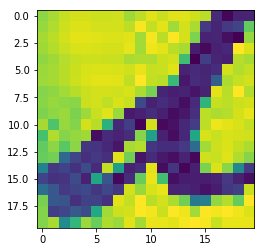

 
256
Was classified as an: D


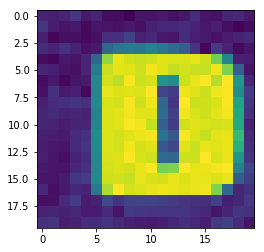

 
257
Was classified as an: D


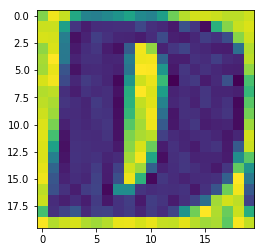

 
258
Was classified as an: D


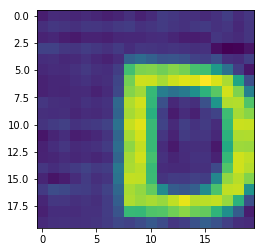

 
259
Was classified as an: D


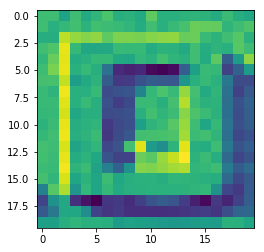

 
260
Was classified as an: D


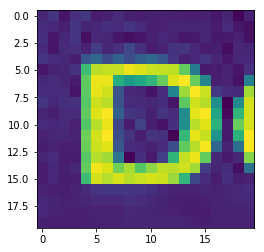

 
261
Was classified as an: D


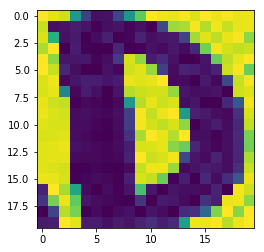

 
262
Was classified as an: D


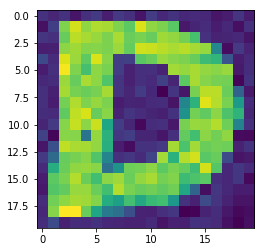

 
263
Was classified as an: D


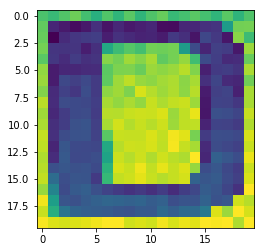

 
264
Was classified as an: D


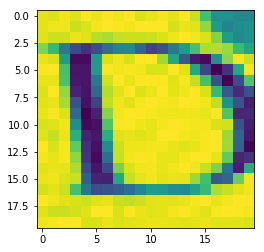

 
265
Was classified as an: D


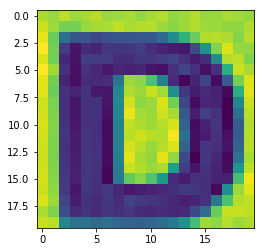

 
266
Was classified as an: D


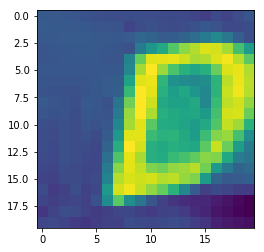

 
267
Was classified as an: D


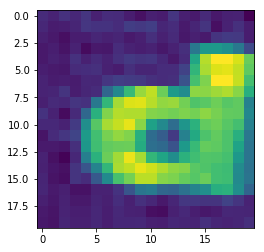

 
268
Was classified as an: D


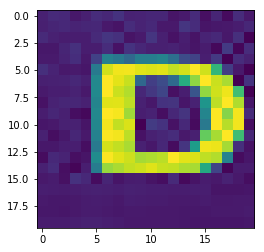

 
269
Was classified as an: D


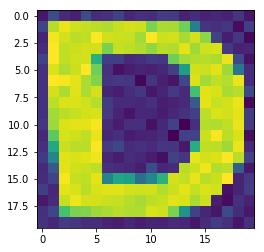

 
270
Was classified as an: D


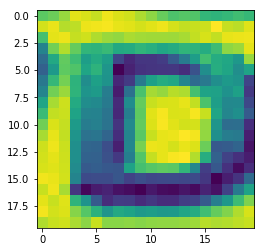

 
271
Was classified as an: D


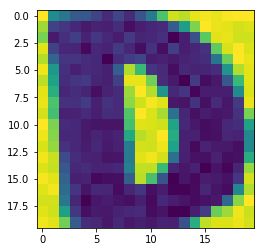

 
272
Was classified as an: D


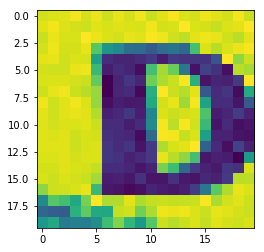

 
273
Was classified as an: H


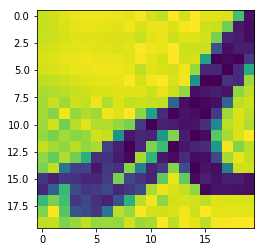

 
274
Was classified as an: D


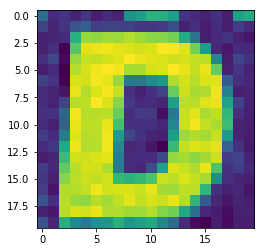

 
275
Was classified as an: D


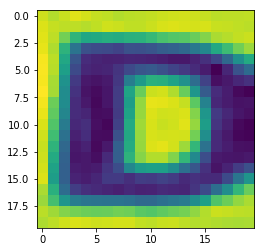

 
276
Was classified as an: D


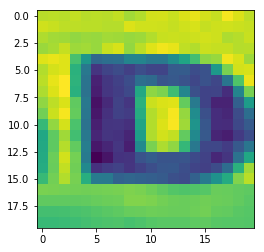

 
277
Was classified as an: E


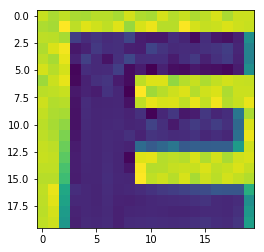

 
278
Was classified as an: E


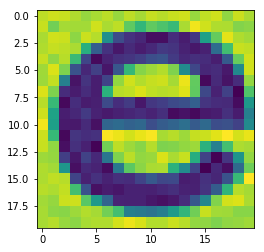

 
279
Was classified as an: E


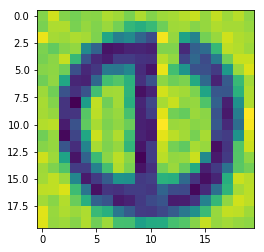

 
280
Was classified as an: E


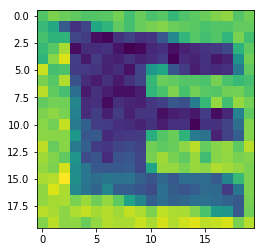

 
281
Was classified as an: E


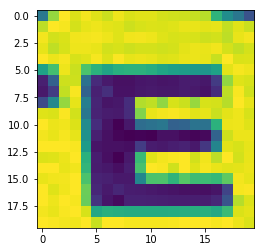

 
282
Was classified as an: F


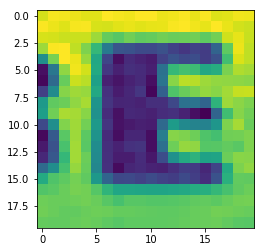

 
283
Was classified as an: C


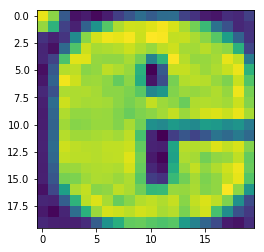

 
284
Was classified as an: E


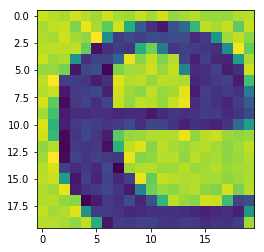

 
285
Was classified as an: A


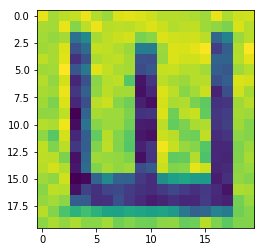

 
286
Was classified as an: E


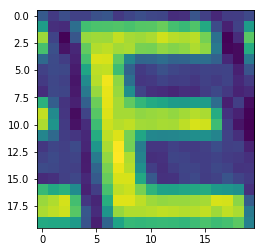

 
287
Was classified as an: E


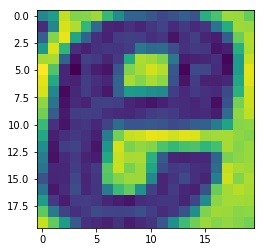

 
288
Was classified as an: E


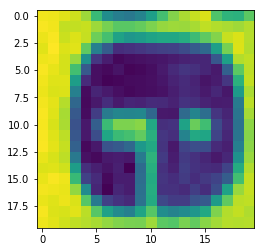

 
289
Was classified as an: E


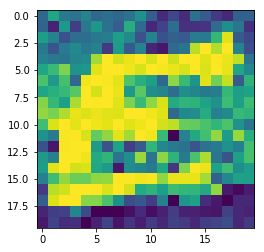

 
290
Was classified as an: E


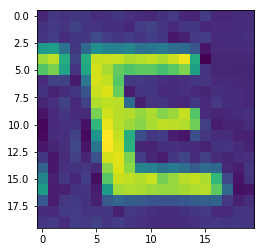

 
291
Was classified as an: E


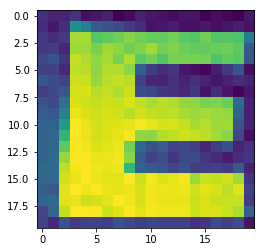

 
292
Was classified as an: E


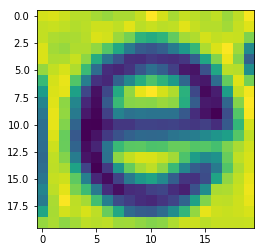

 
293
Was classified as an: E


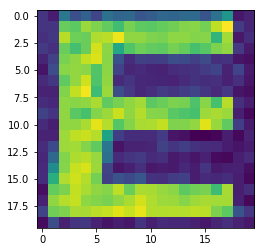

 
294
Was classified as an: E


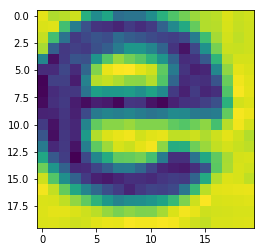

 
295
Was classified as an: E


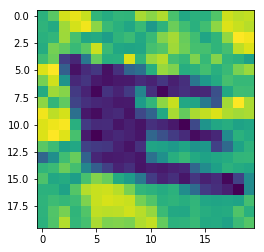

 
296
Was classified as an: E


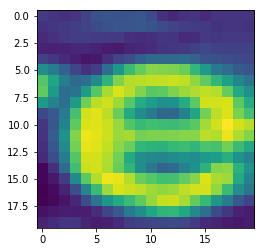

 
297
Was classified as an: E


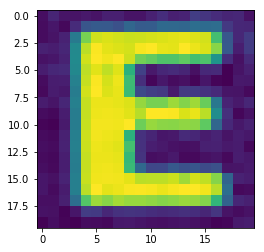

 
298
Was classified as an: E


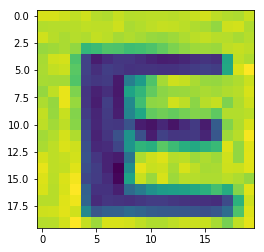

 
299
Was classified as an: E


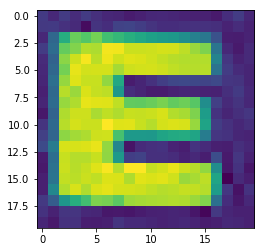

 
300
Was classified as an: E


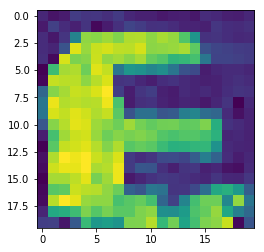

 
301
Was classified as an: E


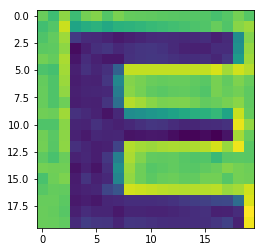

 
302
Was classified as an: C


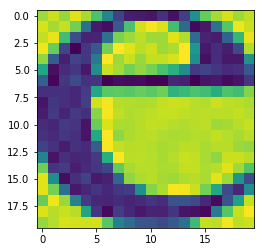

 
303
Was classified as an: E


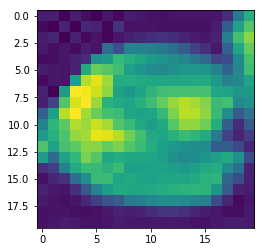

 
304
Was classified as an: E


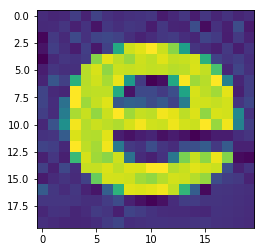

 
305
Was classified as an: E


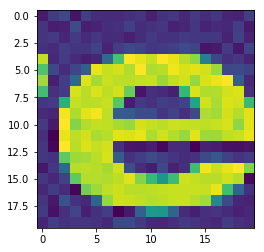

 
306
Was classified as an: E


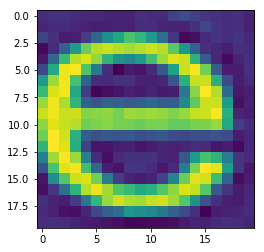

 
307
Was classified as an: E


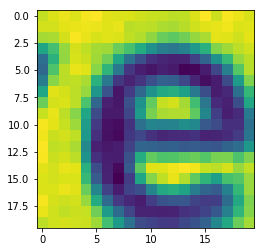

 
308
Was classified as an: E


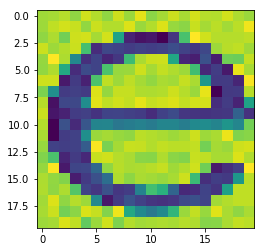

 
309
Was classified as an: E


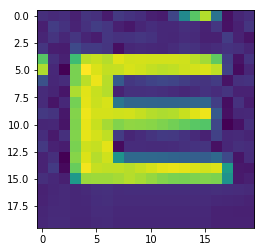

 
310
Was classified as an: E


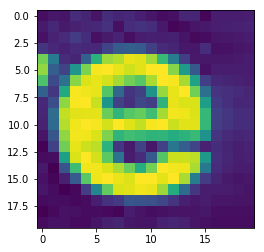

 
311
Was classified as an: E


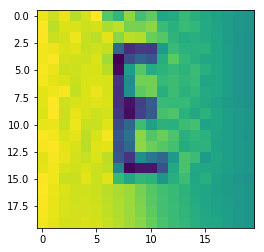

 
312
Was classified as an: E


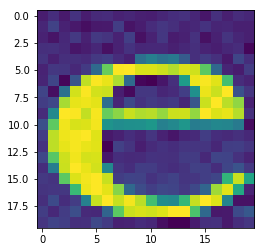

 
313
Was classified as an: E


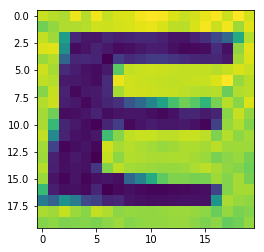

 
314
Was classified as an: E


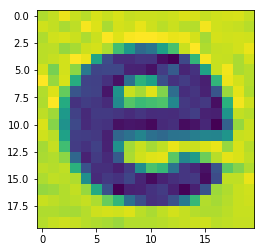

 
315
Was classified as an: E


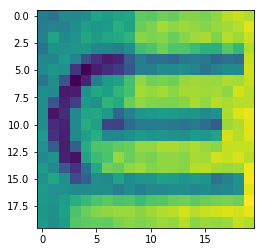

 
316
Was classified as an: E


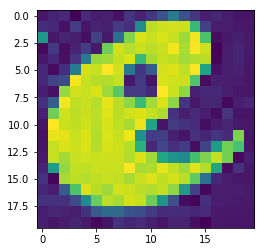

 
317
Was classified as an: E


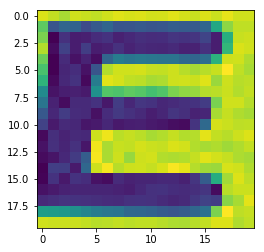

 
318
Was classified as an: E


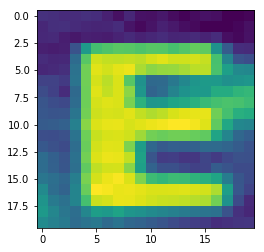

 
319
Was classified as an: E


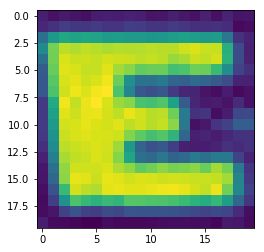

 
320
Was classified as an: E


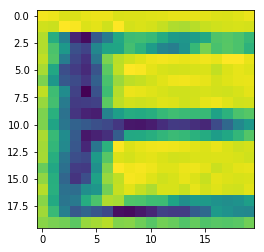

 
321
Was classified as an: E


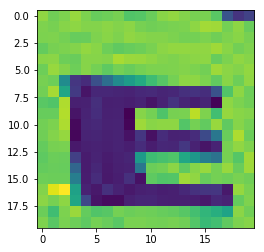

 
322
Was classified as an: A


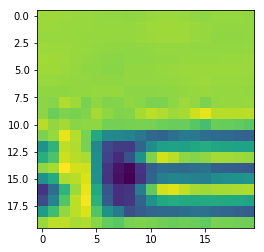

 
323
Was classified as an: E


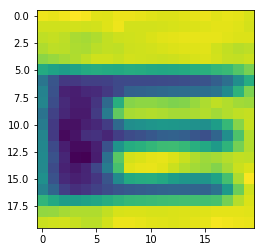

 
324
Was classified as an: E


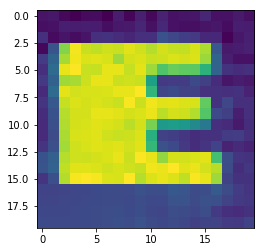

 
325
Was classified as an: E


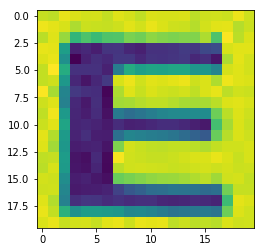

 
326
Was classified as an: B


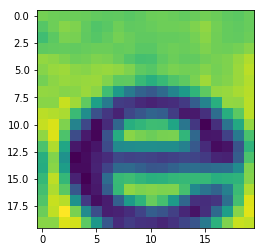

 
327
Was classified as an: E


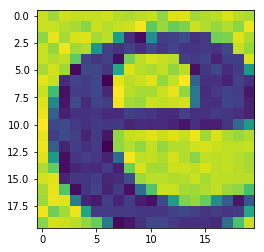

 
328
Was classified as an: E


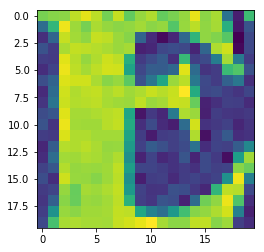

 
329
Was classified as an: F


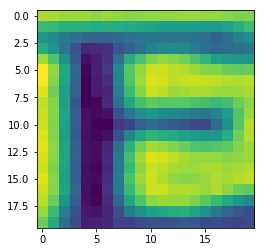

 
330
Was classified as an: E


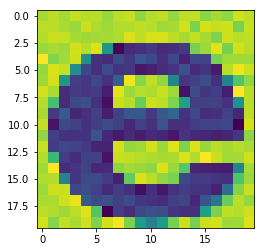

 
331
Was classified as an: E


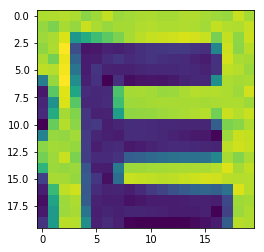

 
332
Was classified as an: E


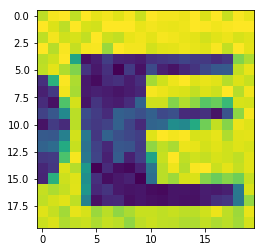

 
333
Was classified as an: E


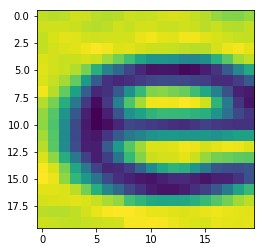

 
334
Was classified as an: E


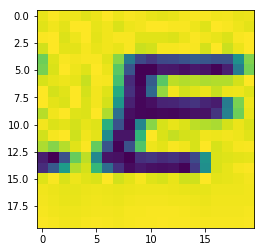

 
335
Was classified as an: E


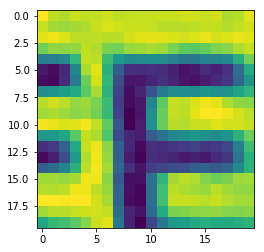

 
336
Was classified as an: E


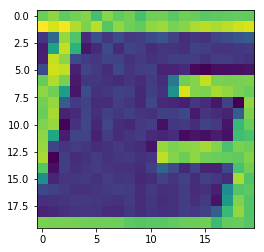

 
337
Was classified as an: E


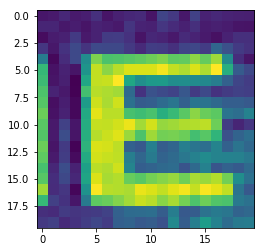

 
338
Was classified as an: E


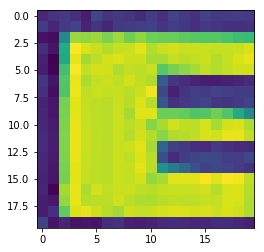

 
339
Was classified as an: E


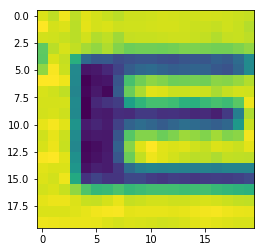

 
340
Was classified as an: E


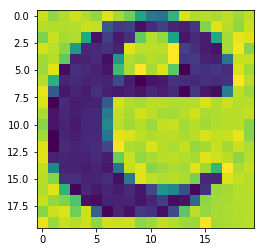

 
341
Was classified as an: E


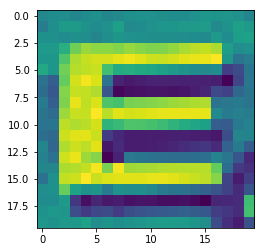

 
342
Was classified as an: E


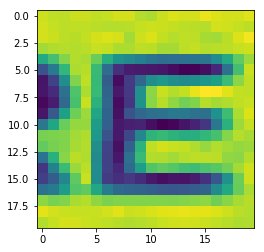

 
343
Was classified as an: E


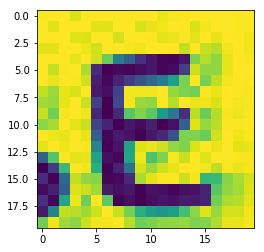

 
344
Was classified as an: E


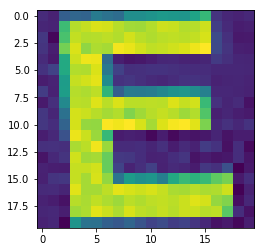

 
345
Was classified as an: E


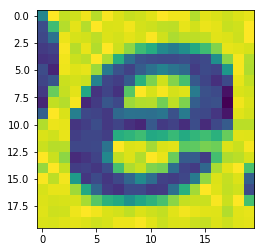

 
346
Was classified as an: E


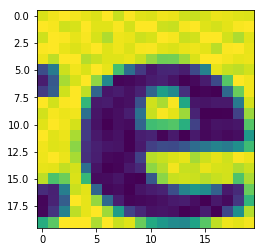

 
347
Was classified as an: E


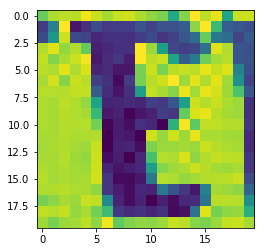

 
348
Was classified as an: E


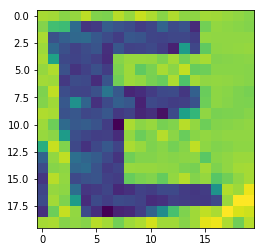

 
349
Was classified as an: E


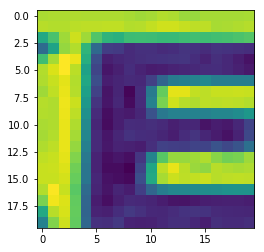

 
350
Was classified as an: E


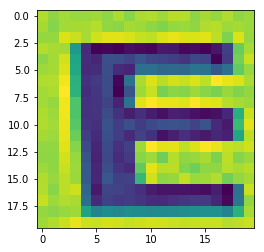

 
351
Was classified as an: E


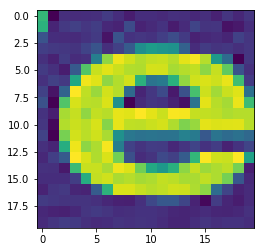

 
352
Was classified as an: E


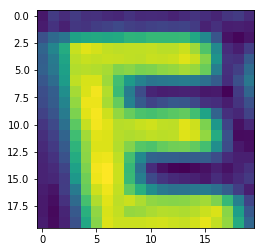

 
353
Was classified as an: E


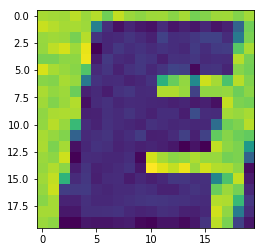

 
354
Was classified as an: E


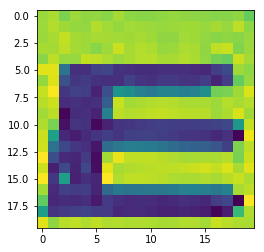

 
355
Was classified as an: E


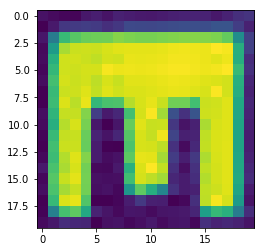

 
356
Was classified as an: E


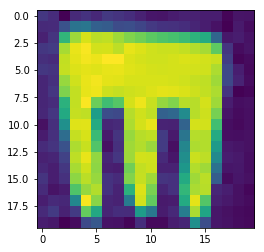

 
357
Was classified as an: E


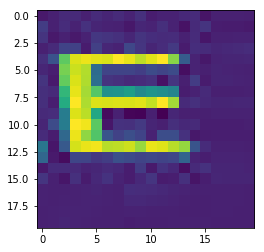

 
358
Was classified as an: E


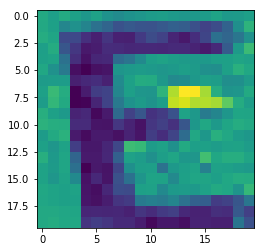

 
359
Was classified as an: E


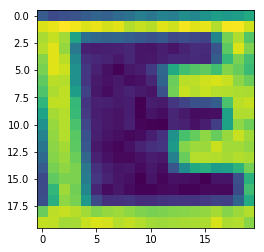

 
360
Was classified as an: E


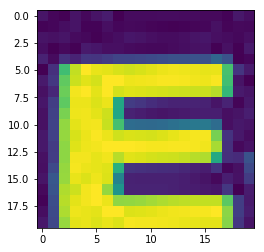

 
361
Was classified as an: E


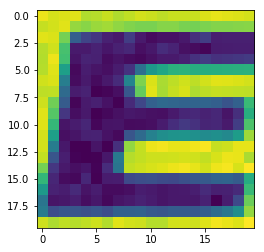

 
362
Was classified as an: E


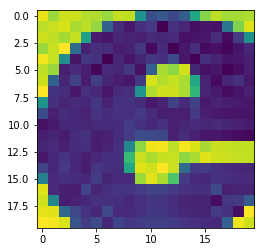

 
363
Was classified as an: E


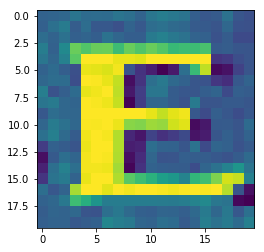

 
364
Was classified as an: E


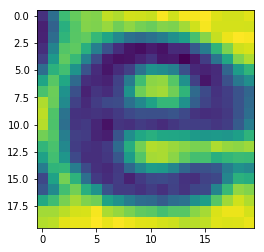

 
365
Was classified as an: E


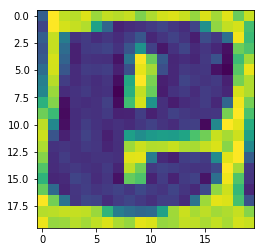

 
366
Was classified as an: E


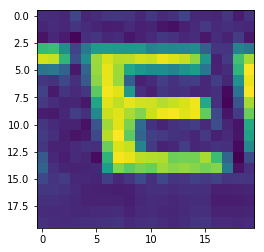

 
367
Was classified as an: F


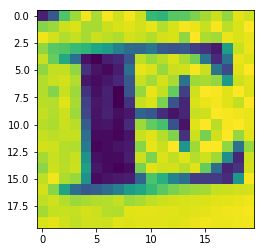

 
368
Was classified as an: E


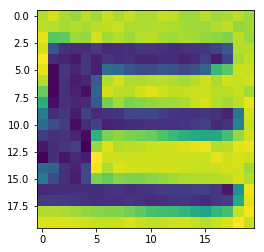

 
369
Was classified as an: E


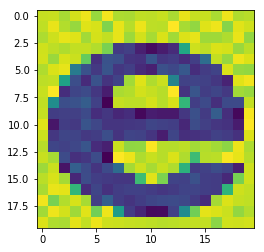

 
370
Was classified as an: E


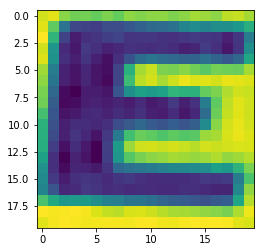

 
371
Was classified as an: E


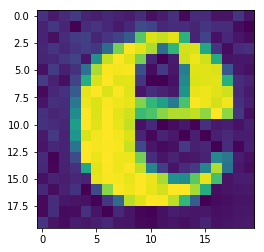

 
372
Was classified as an: E


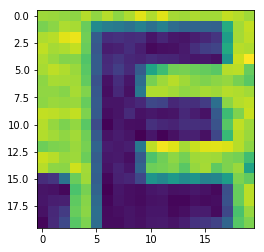

 
373
Was classified as an: E


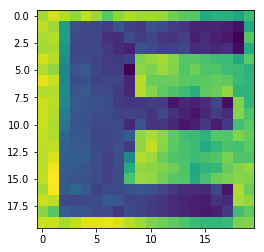

 
374
Was classified as an: E


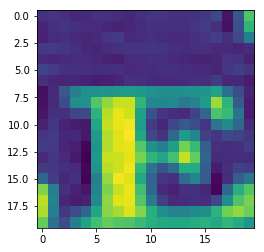

 
375
Was classified as an: E


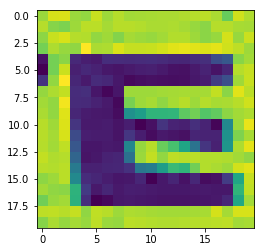

 
376
Was classified as an: E


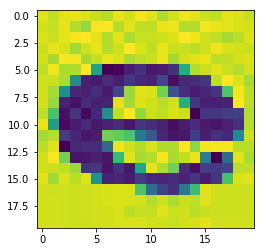

 
377
Was classified as an: E


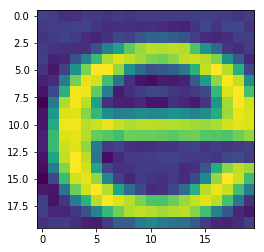

 
378
Was classified as an: E


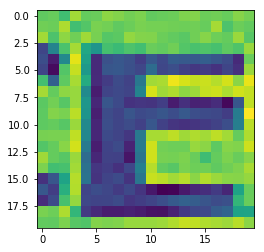

 
379
Was classified as an: E


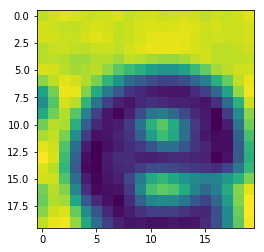

 
380
Was classified as an: E


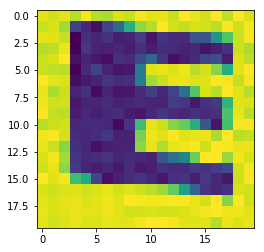

 
381
Was classified as an: E


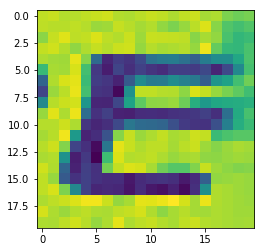

 
382
Was classified as an: E


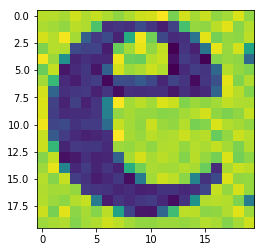

 
383
Was classified as an: E


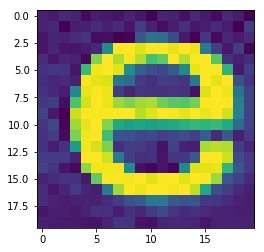

 
384
Was classified as an: E


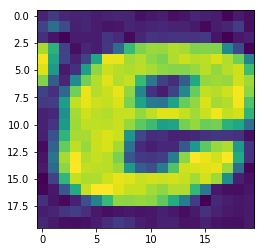

 
385
Was classified as an: E


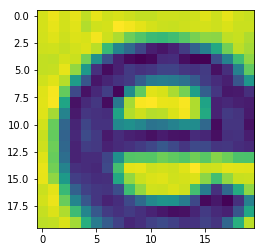

 
386
Was classified as an: E


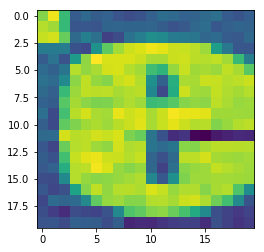

 
387
Was classified as an: E


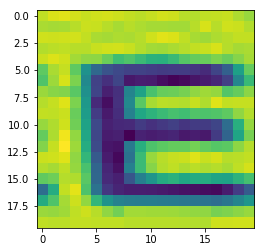

 
388
Was classified as an: E


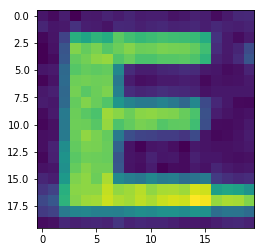

 
389
Was classified as an: O


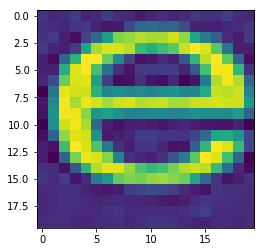

 
390
Was classified as an: E


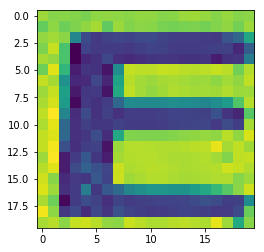

 
391
Was classified as an: E


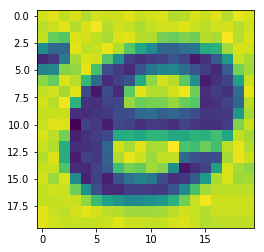

 
392
Was classified as an: E


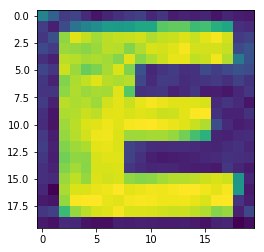

 
393
Was classified as an: E


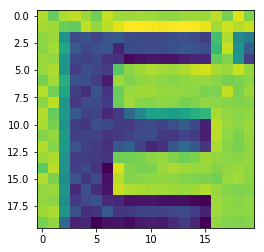

 
394
Was classified as an: E


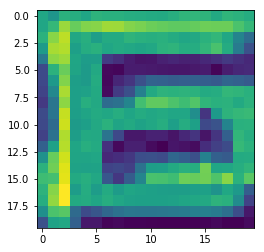

 
395
Was classified as an: E


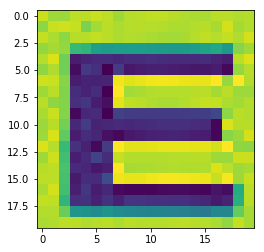

 
396
Was classified as an: E


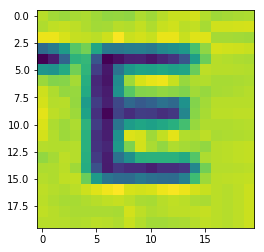

 
397
Was classified as an: R


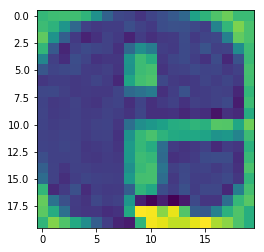

 
398
Was classified as an: E


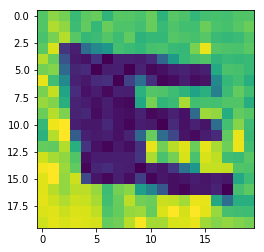

 
399
Was classified as an: E


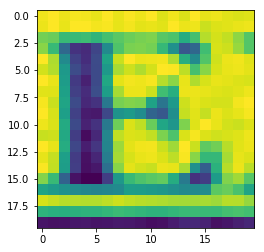

 
400
Was classified as an: E


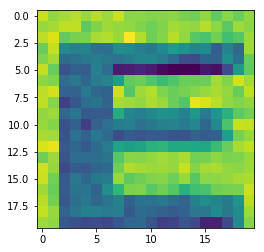

 
401
Was classified as an: E


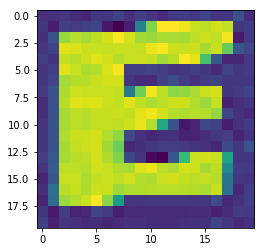

 
402
Was classified as an: E


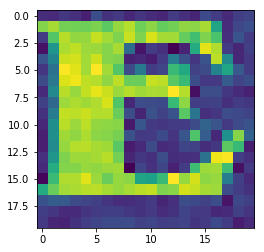

 
403
Was classified as an: E


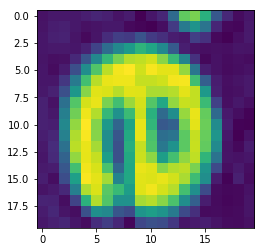

 
404
Was classified as an: E


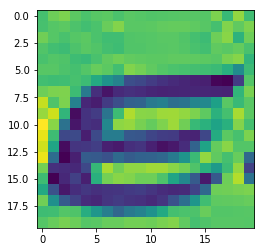

 
405
Was classified as an: E


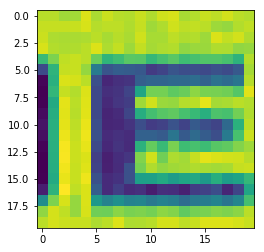

 
406
Was classified as an: E


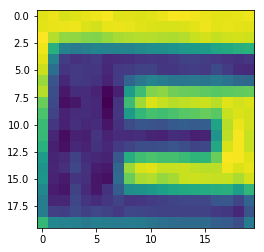

 
407
Was classified as an: E


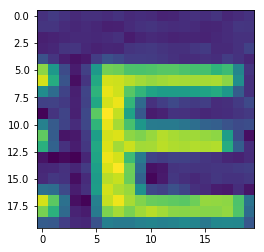

 
408
Was classified as an: E


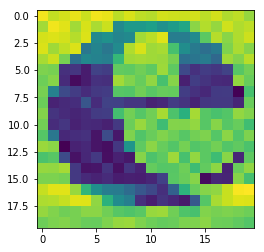

 
409
Was classified as an: E


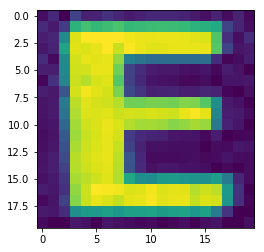

 
410
Was classified as an: E


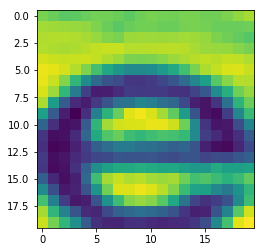

 
411
Was classified as an: E


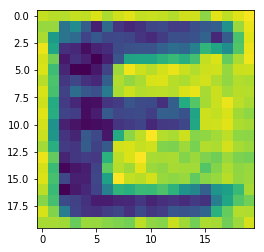

 
412
Was classified as an: F


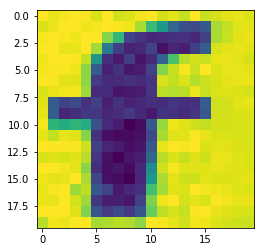

 
413
Was classified as an: F


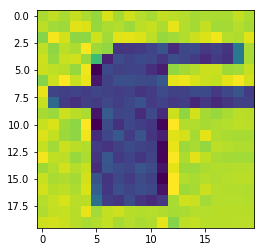

 
414
Was classified as an: F


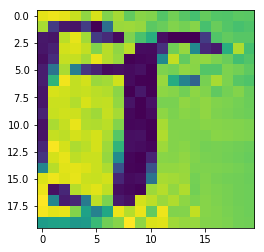

 
415
Was classified as an: F


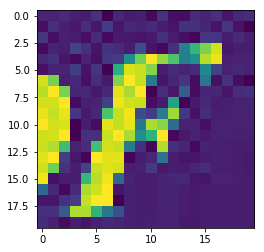

 
416
Was classified as an: F


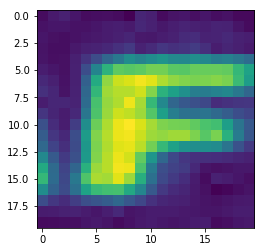

 
417
Was classified as an: F


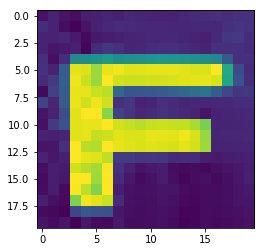

 
418
Was classified as an: F


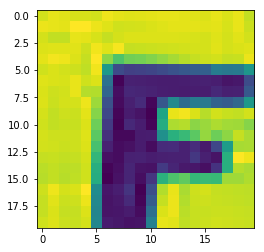

 
419
Was classified as an: F


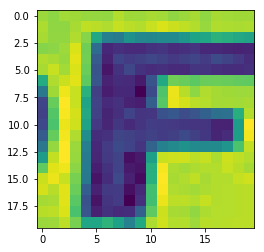

 
420
Was classified as an: F


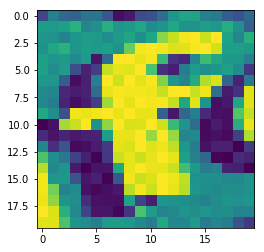

 
421
Was classified as an: F


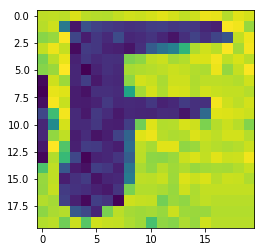

 
422
Was classified as an: D


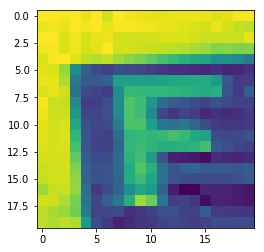

 
423
Was classified as an: R


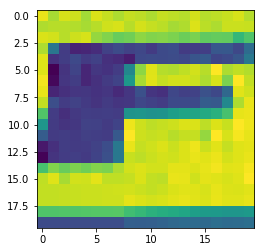

 
424
Was classified as an: F


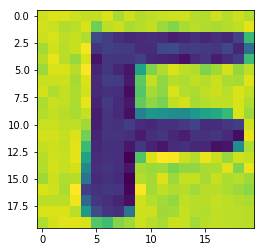

 
425
Was classified as an: F


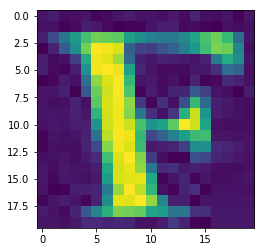

 
426
Was classified as an: F


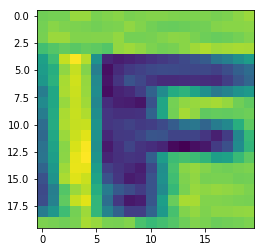

 
427
Was classified as an: O


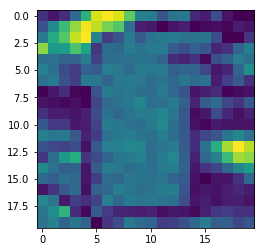

 
428
Was classified as an: F


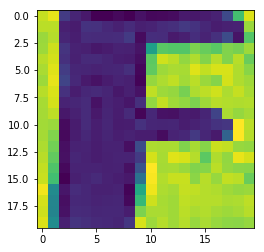

 
429
Was classified as an: F


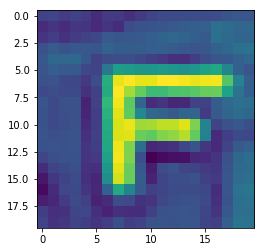

 
430
Was classified as an: F


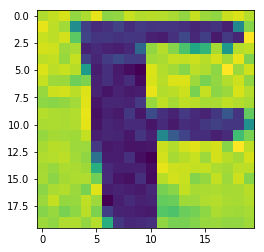

 
431
Was classified as an: F


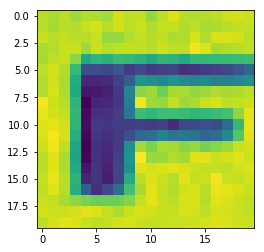

 
432
Was classified as an: F


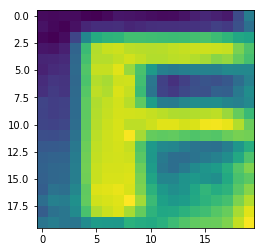

 
433
Was classified as an: F


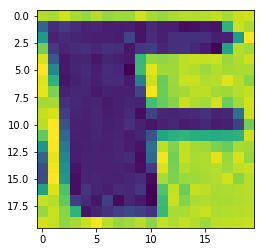

 
434
Was classified as an: F


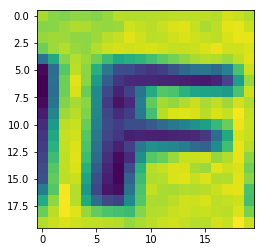

 
435
Was classified as an: T


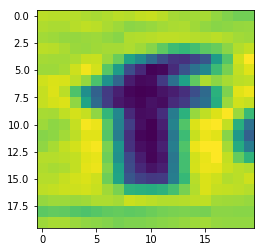

 
436
Was classified as an: G


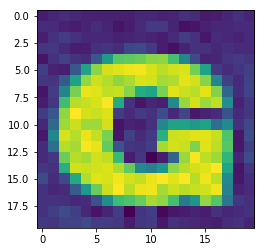

 
437
Was classified as an: G


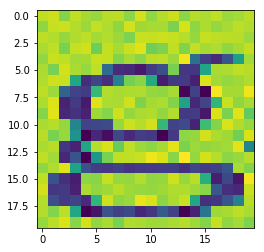

 
438
Was classified as an: G


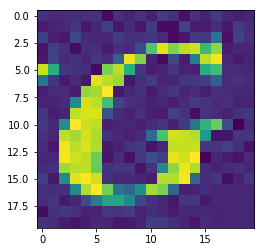

 
439
Was classified as an: G


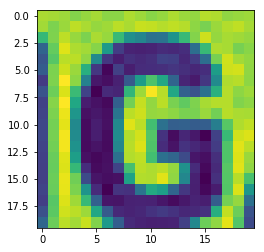

 
440
Was classified as an: G


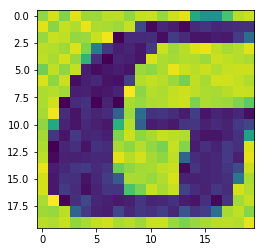

 
441
Was classified as an: G


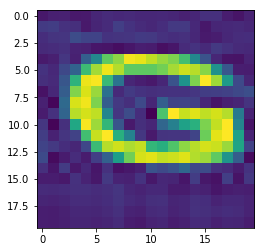

 
442
Was classified as an: G


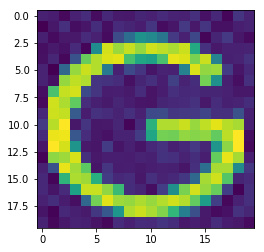

 
443
Was classified as an: G


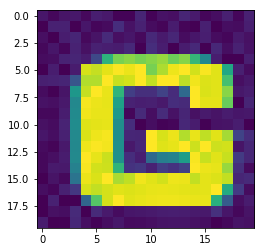

 
444
Was classified as an: G


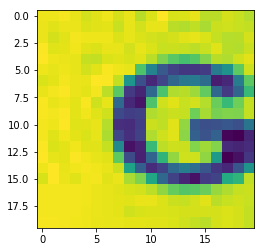

 
445
Was classified as an: G


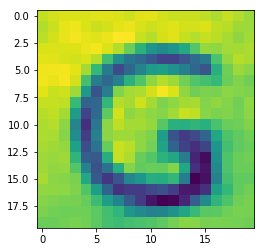

 
446
Was classified as an: G


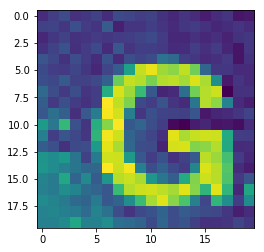

 
447
Was classified as an: G


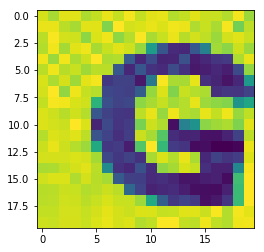

 
448
Was classified as an: G


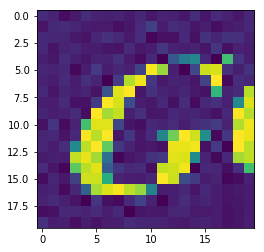

 
449
Was classified as an: G


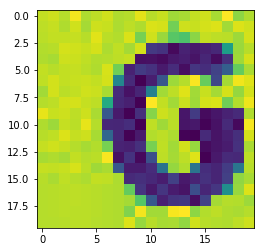

 
450
Was classified as an: O


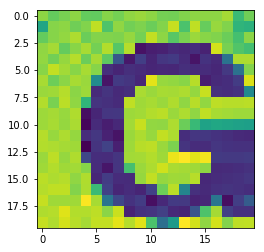

 
451
Was classified as an: G


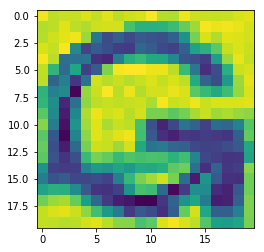

 
452
Was classified as an: G


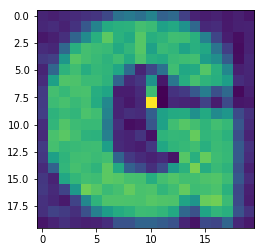

 
453
Was classified as an: G


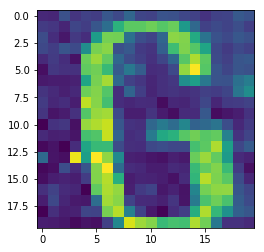

 
454
Was classified as an: G


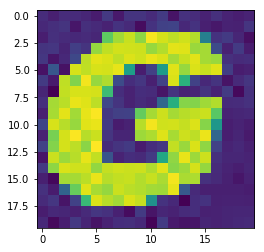

 
455
Was classified as an: P


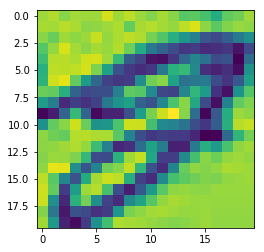

 
456
Was classified as an: G


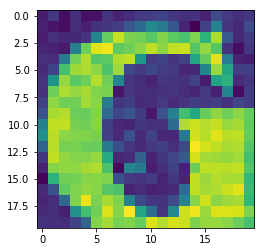

 
457
Was classified as an: G


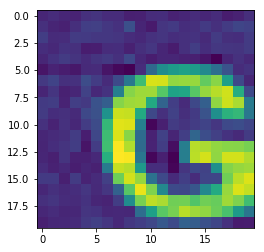

 
458
Was classified as an: G


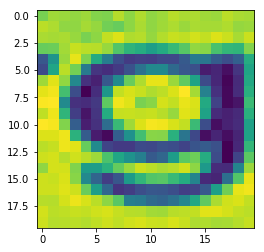

 
459
Was classified as an: G


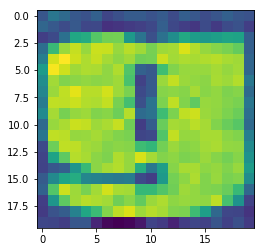

 
460
Was classified as an: G


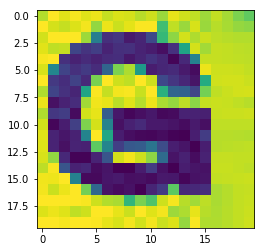

 
461
Was classified as an: G


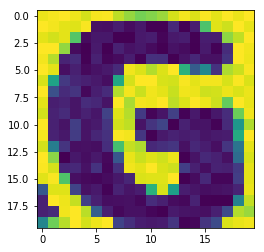

 
462
Was classified as an: G


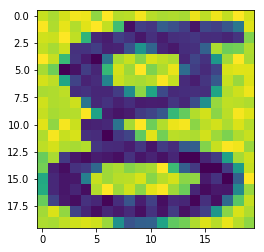

 
463
Was classified as an: G


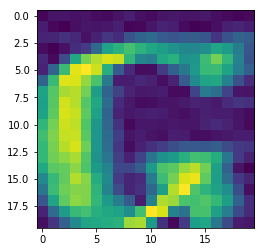

 
464
Was classified as an: G


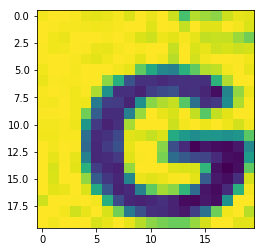

 
465
Was classified as an: O


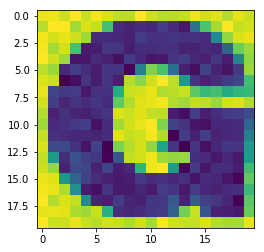

 
466
Was classified as an: G


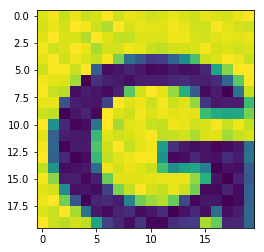

 
467
Was classified as an: S


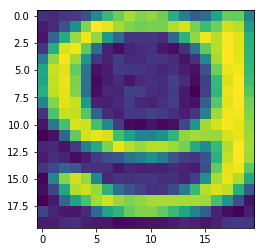

 
468
Was classified as an: G


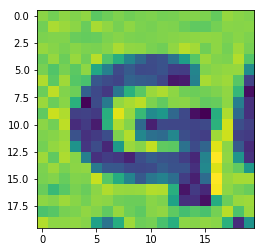

 
469
Was classified as an: G


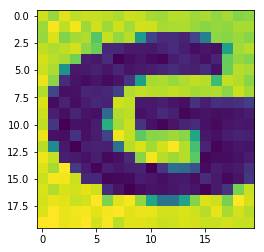

 
470
Was classified as an: O


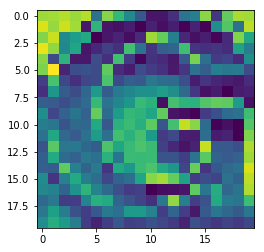

 
471
Was classified as an: G


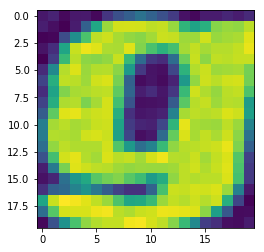

 
472
Was classified as an: H


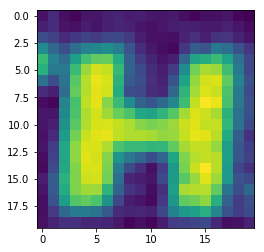

 
473
Was classified as an: H


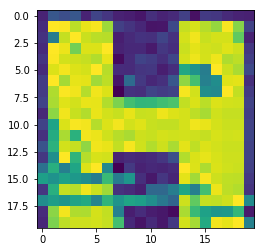

 
474
Was classified as an: H


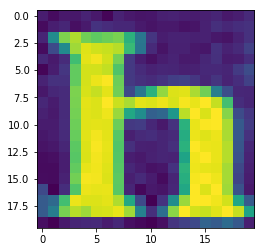

 
475
Was classified as an: H


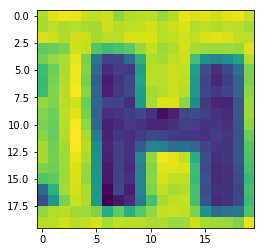

 
476
Was classified as an: H


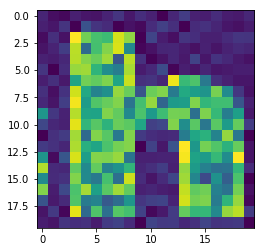

 
477
Was classified as an: H


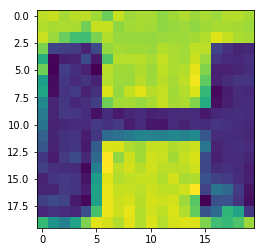

 
478
Was classified as an: H


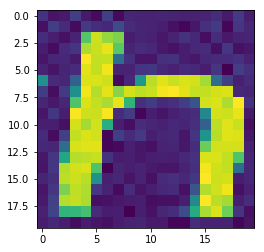

 
479
Was classified as an: H


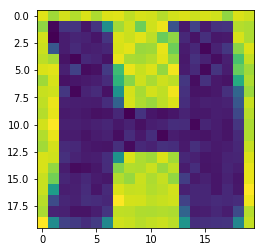

 
480
Was classified as an: H


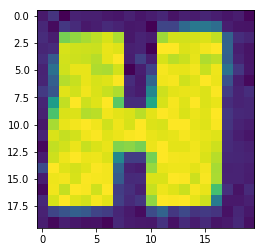

 
481
Was classified as an: H


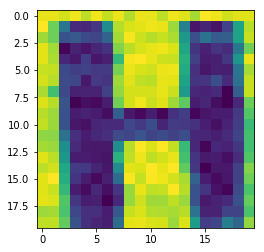

 
482
Was classified as an: H


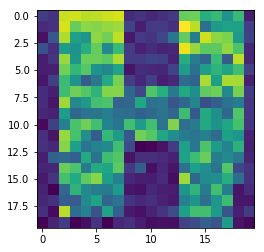

 
483
Was classified as an: H


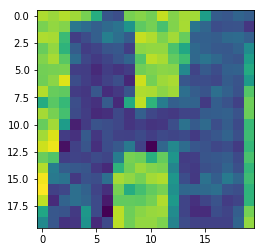

 
484
Was classified as an: H


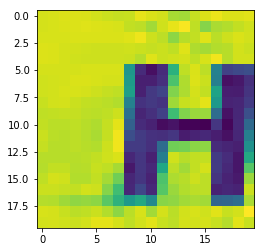

 
485
Was classified as an: H


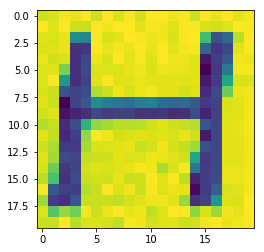

 
486
Was classified as an: H


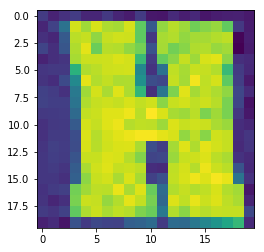

 
487
Was classified as an: H


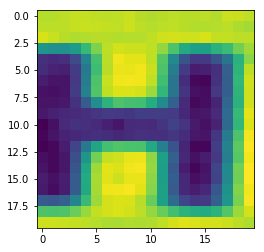

 
488
Was classified as an: H


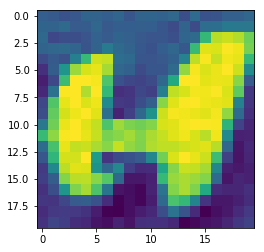

 
489
Was classified as an: H


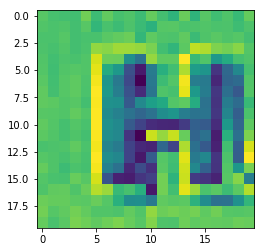

 
490
Was classified as an: H


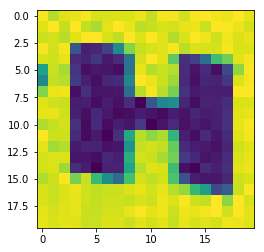

 
491
Was classified as an: H


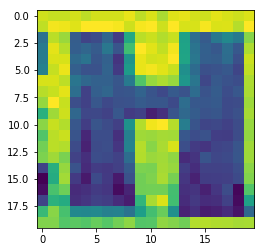

 
492
Was classified as an: H


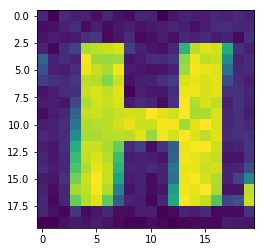

 
493
Was classified as an: H


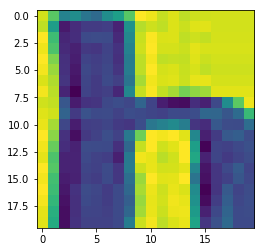

 
494
Was classified as an: H


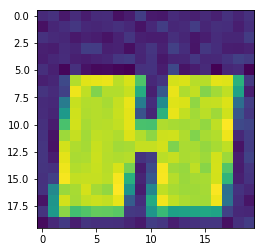

 
495
Was classified as an: H


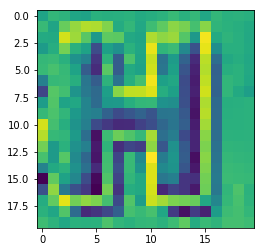

 
496
Was classified as an: H


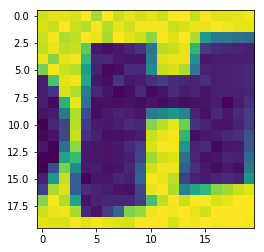

 
497
Was classified as an: H


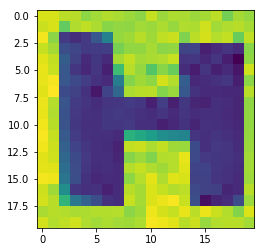

 
498
Was classified as an: H


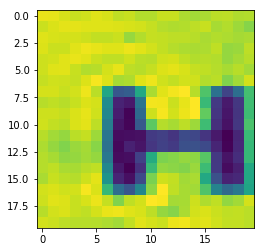

 
499
Was classified as an: H


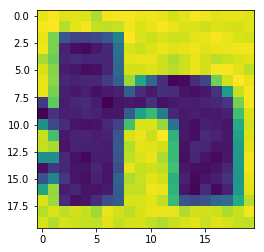

 
500
Was classified as an: H


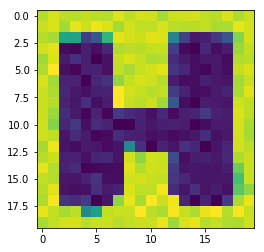

 
501
Was classified as an: H


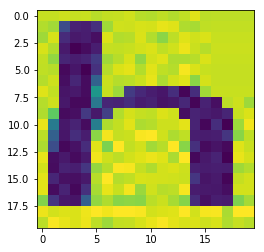

 
502
Was classified as an: H


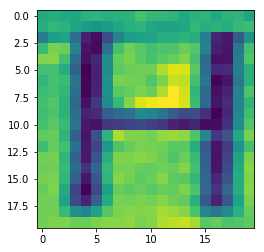

 
503
Was classified as an: H


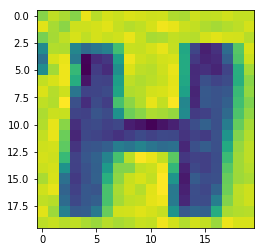

 
504
Was classified as an: N


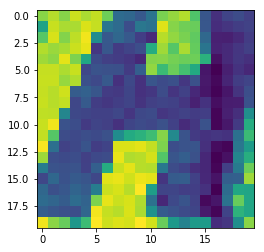

 
505
Was classified as an: H


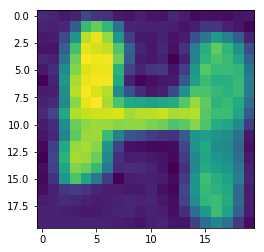

 
506
Was classified as an: C


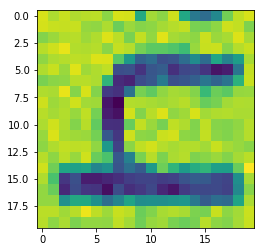

 
507
Was classified as an: F


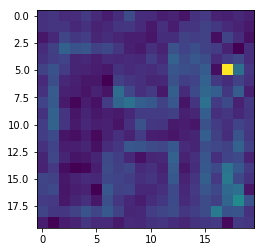

 
508
Was classified as an: H


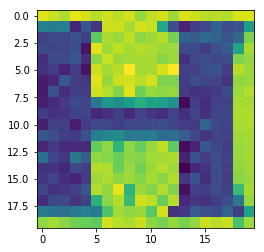

 
509
Was classified as an: H


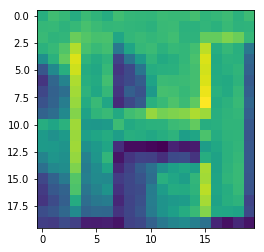

 
510
Was classified as an: H


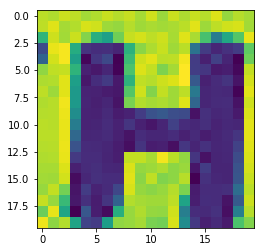

 
511
Was classified as an: N


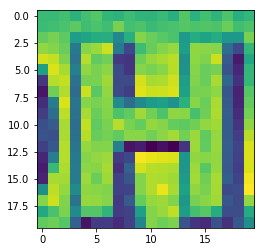

 
512
Was classified as an: H


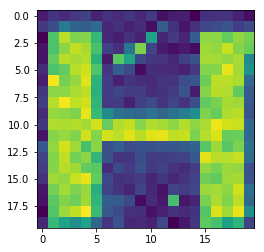

 
513
Was classified as an: H


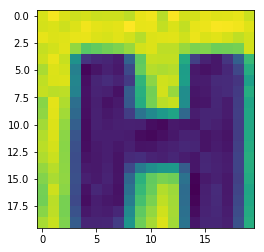

 
514
Was classified as an: H


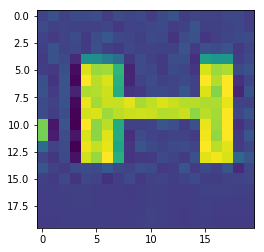

 
515
Was classified as an: H


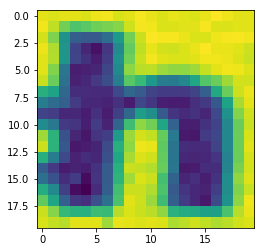

 
516
Was classified as an: H


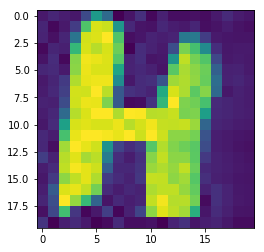

 
517
Was classified as an: H


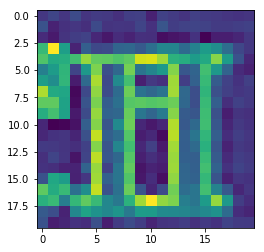

 
518
Was classified as an: H


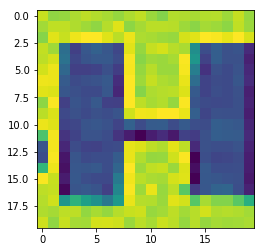

 
519
Was classified as an: H


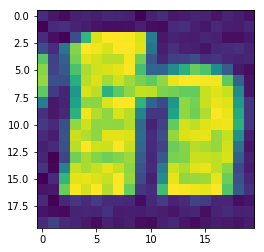

 
520
Was classified as an: H


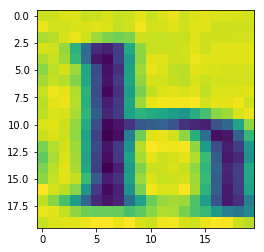

 
521
Was classified as an: I


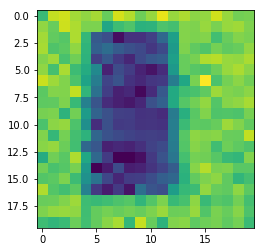

 
522
Was classified as an: I


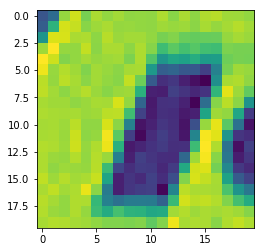

 
523
Was classified as an: I


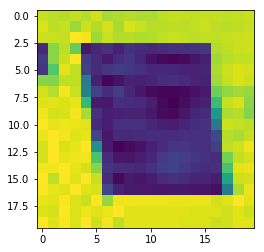

 
524
Was classified as an: I


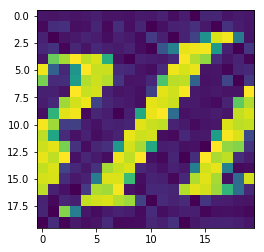

 
525
Was classified as an: I


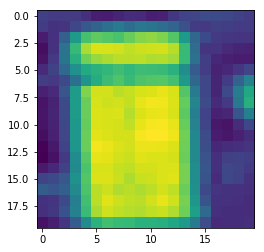

 
526
Was classified as an: I


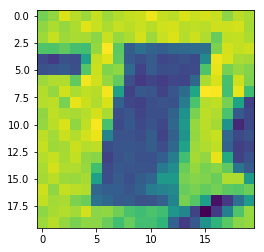

 
527
Was classified as an: L


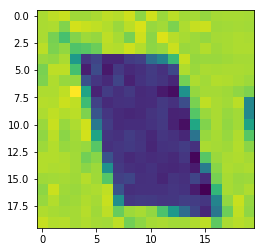

 
528
Was classified as an: I


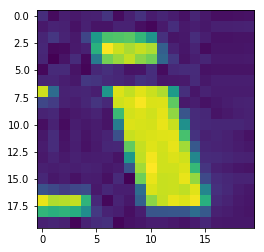

 
529
Was classified as an: I


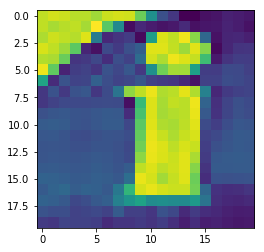

 
530
Was classified as an: I


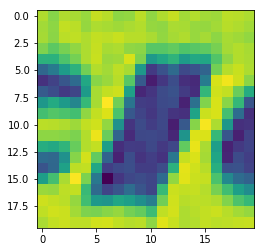

 
531
Was classified as an: I


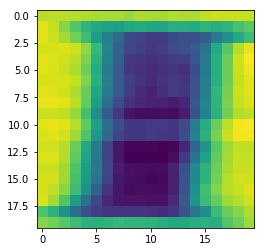

 
532
Was classified as an: I


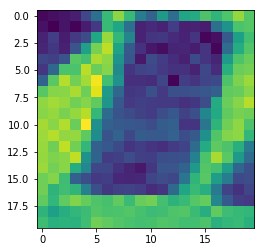

 
533
Was classified as an: I


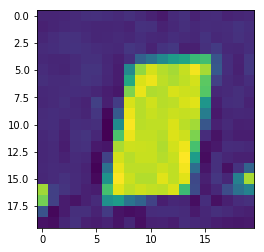

 
534
Was classified as an: I


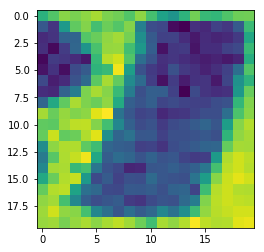

 
535
Was classified as an: I


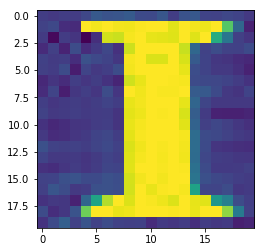

 
536
Was classified as an: I


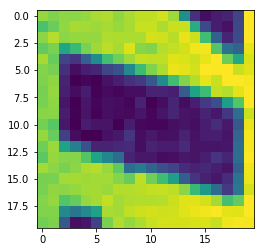

 
537
Was classified as an: I


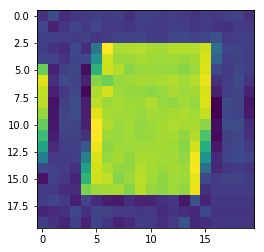

 
538
Was classified as an: I


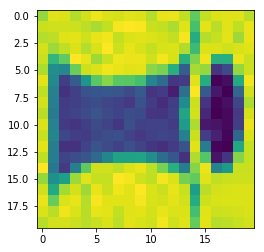

 
539
Was classified as an: F


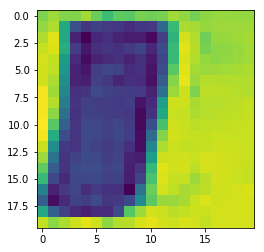

 
540
Was classified as an: I


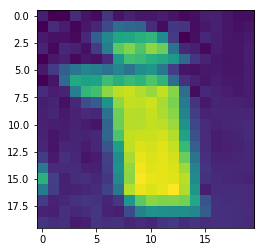

 
541
Was classified as an: I


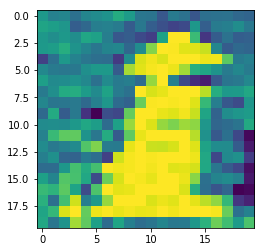

 
542
Was classified as an: I


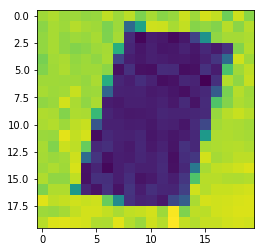

 
543
Was classified as an: I


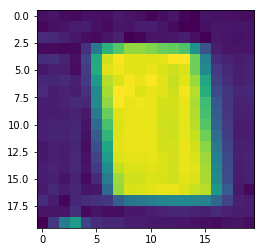

 
544
Was classified as an: I


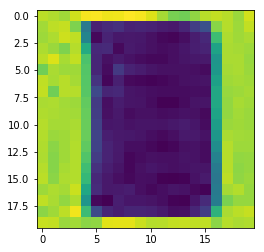

 
545
Was classified as an: T


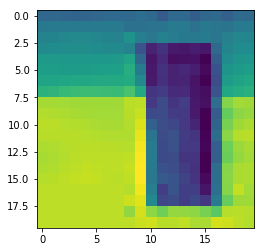

 
546
Was classified as an: I


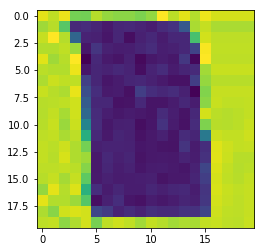

 
547
Was classified as an: I


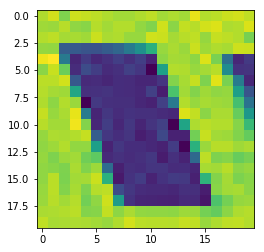

 
548
Was classified as an: I


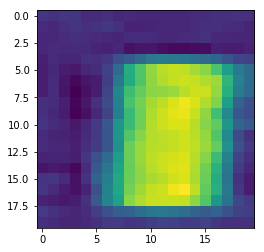

 
549
Was classified as an: I


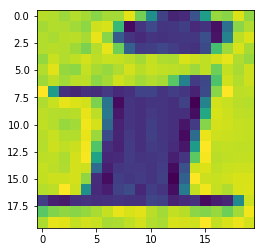

 
550
Was classified as an: I


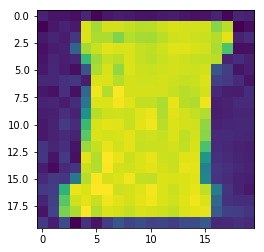

 
551
Was classified as an: I


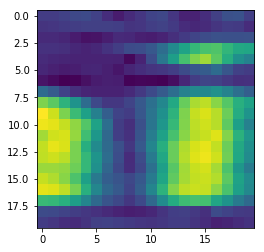

 
552
Was classified as an: I


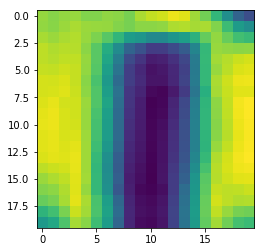

 
553
Was classified as an: I


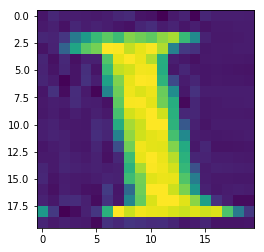

 
554
Was classified as an: I


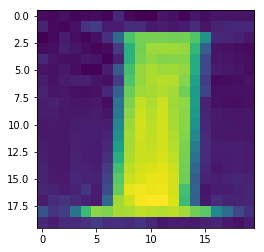

 
555
Was classified as an: I


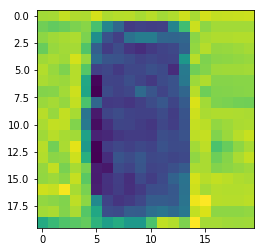

 
556
Was classified as an: I


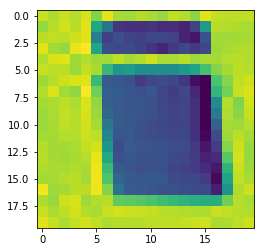

 
557
Was classified as an: L


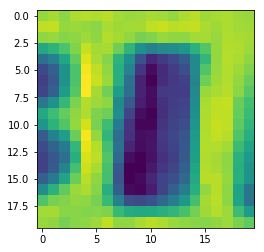

 
558
Was classified as an: I


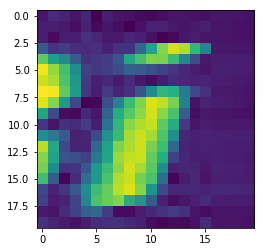

 
559
Was classified as an: I


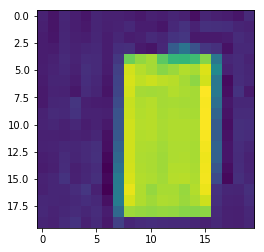

 
560
Was classified as an: I


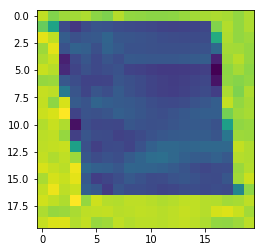

 
561
Was classified as an: I


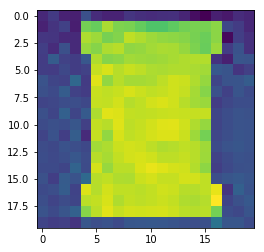

 
562
Was classified as an: I


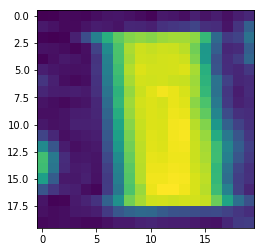

 
563
Was classified as an: I


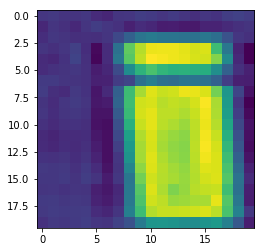

 
564
Was classified as an: I


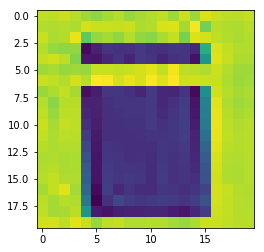

 
565
Was classified as an: I


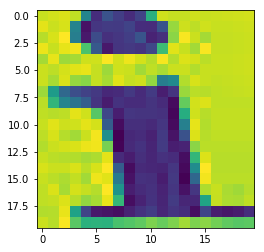

 
566
Was classified as an: I


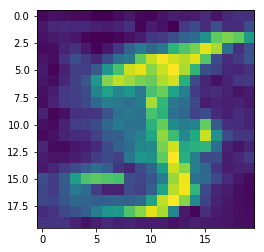

 
567
Was classified as an: I


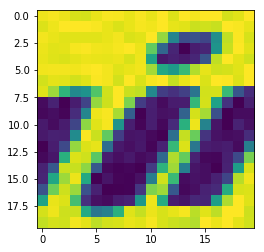

 
568
Was classified as an: I


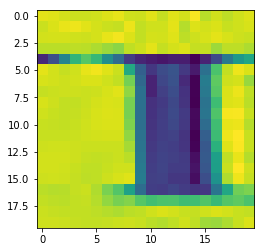

 
569
Was classified as an: I


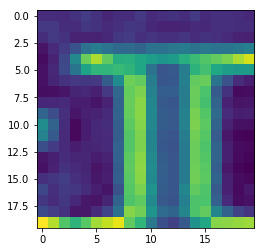

 
570
Was classified as an: I


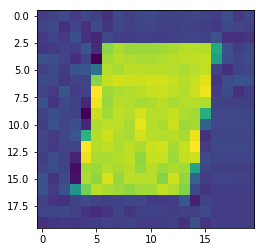

 
571
Was classified as an: I


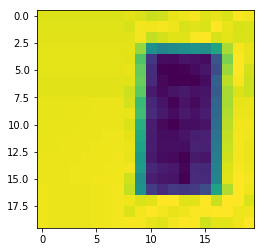

 
572
Was classified as an: I


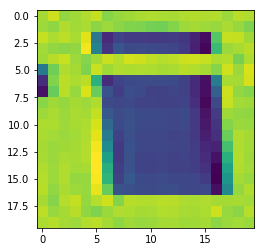

 
573
Was classified as an: I


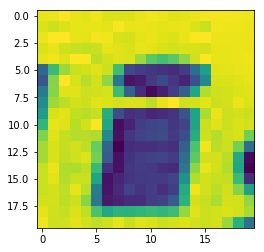

 
574
Was classified as an: I


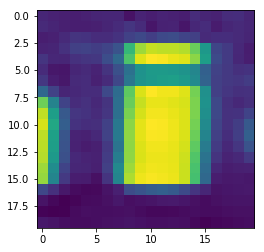

 
575
Was classified as an: I


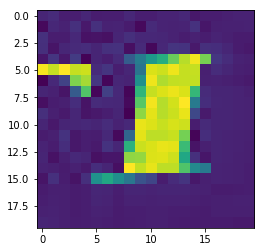

 
576
Was classified as an: I


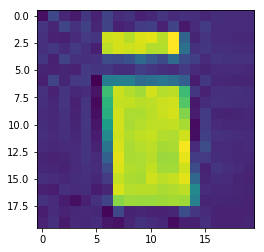

 
577
Was classified as an: A


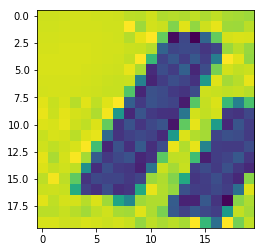

 
578
Was classified as an: T


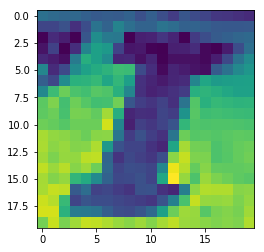

 
579
Was classified as an: I


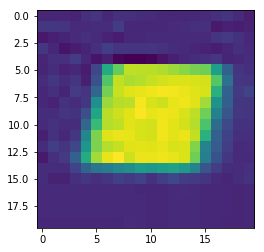

 
580
Was classified as an: I


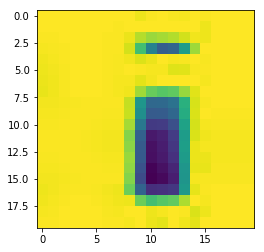

 
581
Was classified as an: I


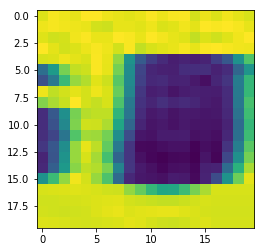

 
582
Was classified as an: I


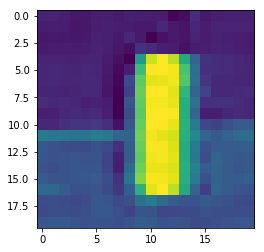

 
583
Was classified as an: I


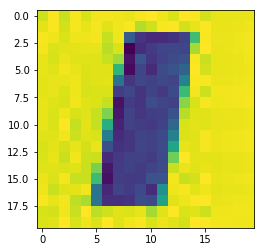

 
584
Was classified as an: L


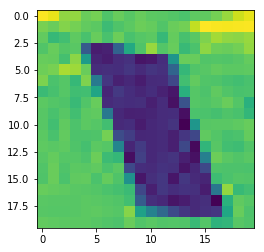

 
585
Was classified as an: I


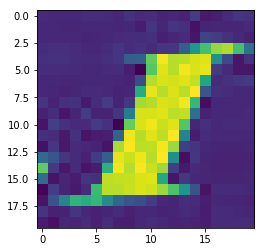

 
586
Was classified as an: I


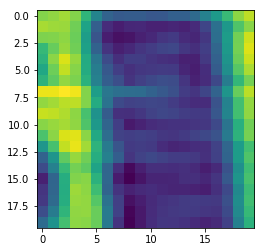

 
587
Was classified as an: I


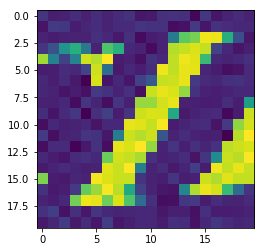

 
588
Was classified as an: I


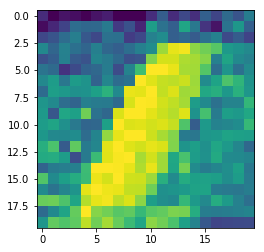

 
589
Was classified as an: I


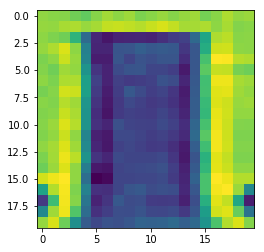

 
590
Was classified as an: I


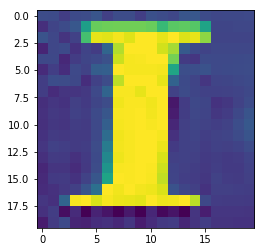

 
591
Was classified as an: I


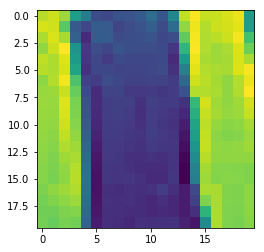

 
592
Was classified as an: E


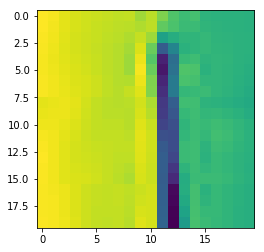

 
593
Was classified as an: I


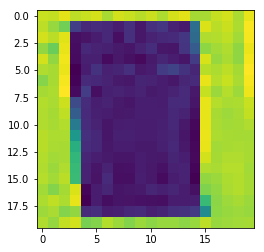

 
594
Was classified as an: L


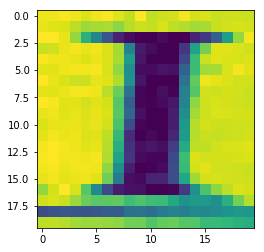

 
595
Was classified as an: I


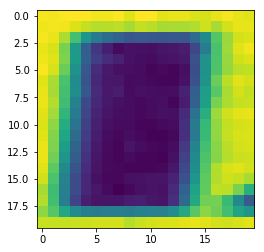

 
596
Was classified as an: I


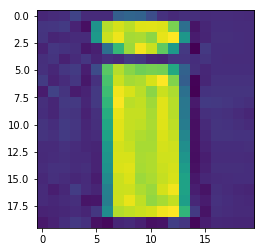

 
597
Was classified as an: I


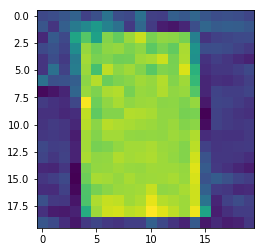

 
598
Was classified as an: L


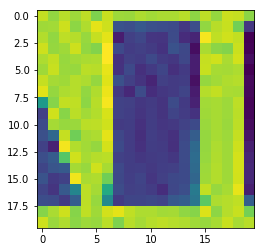

 
599
Was classified as an: I


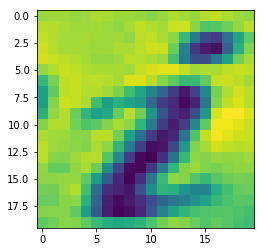

 
600
Was classified as an: I


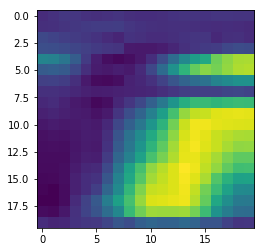

 
601
Was classified as an: I


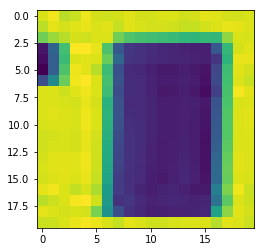

 
602
Was classified as an: L


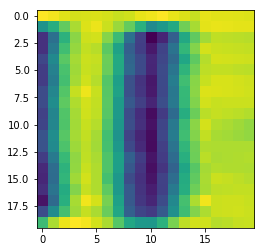

 
603
Was classified as an: I


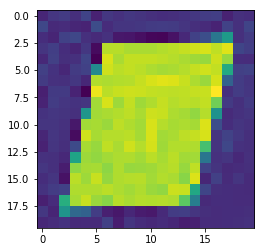

 
604
Was classified as an: I


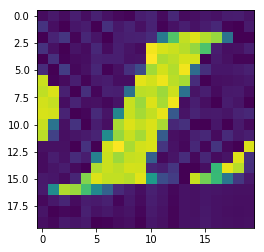

 
605
Was classified as an: I


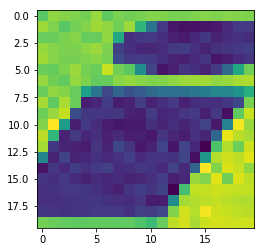

 
606
Was classified as an: I


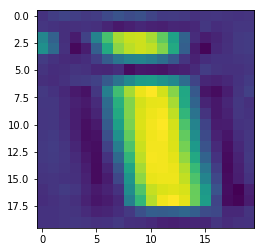

 
607
Was classified as an: I


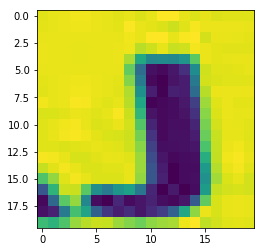

 
608
Was classified as an: B


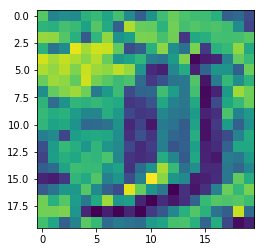

 
609
Was classified as an: I


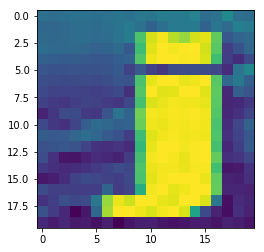

 
610
Was classified as an: I


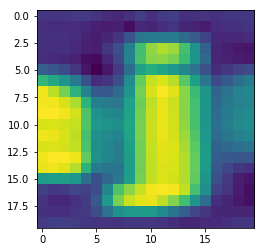

 
611
Was classified as an: A


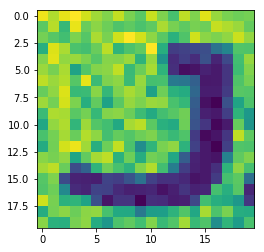

 
612
Was classified as an: G


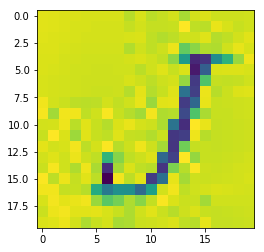

 
613
Was classified as an: J


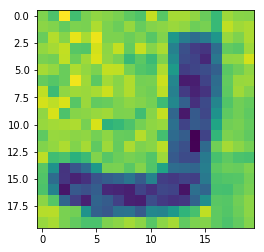

 
614
Was classified as an: L


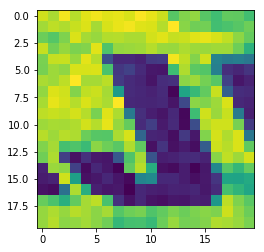

 
615
Was classified as an: J


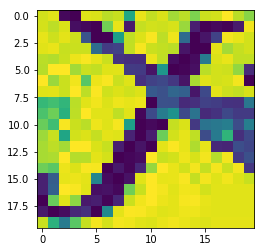

 
616
Was classified as an: J


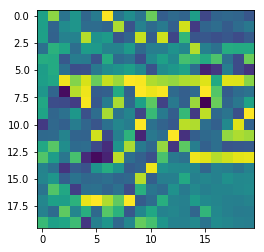

 
617
Was classified as an: J


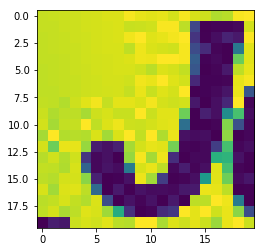

 
618
Was classified as an: J


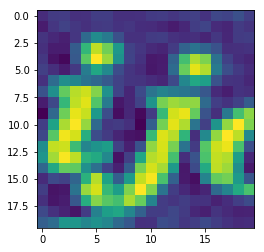

 
619
Was classified as an: A


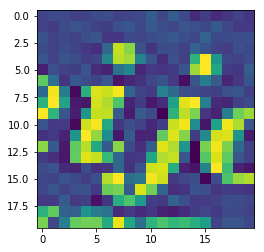

 
620
Was classified as an: I


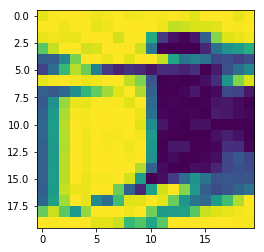

 
621
Was classified as an: A


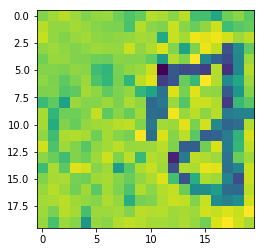

 
622
Was classified as an: I


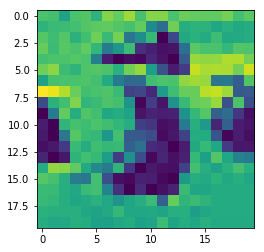

 
623
Was classified as an: O


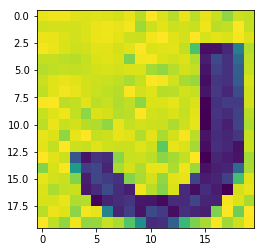

 
624
Was classified as an: I


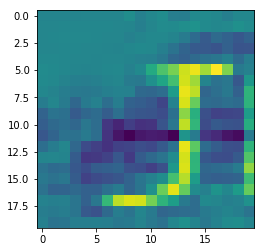

 
625
Was classified as an: J


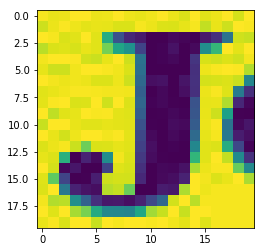

 
626
Was classified as an: M


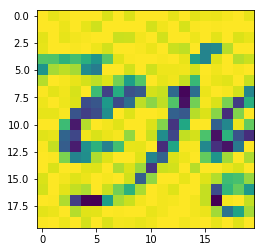

 
627
Was classified as an: D


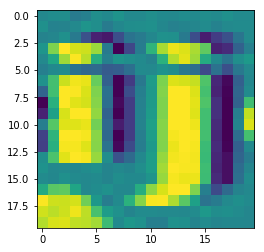

 
628
Was classified as an: J


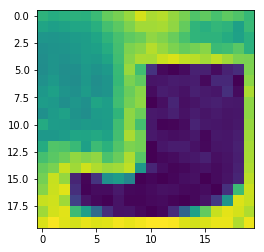

 
629
Was classified as an: K


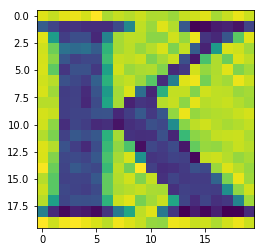

 
630
Was classified as an: K


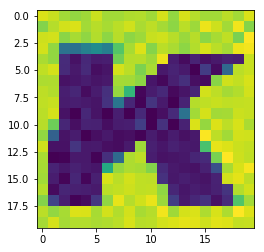

 
631
Was classified as an: K


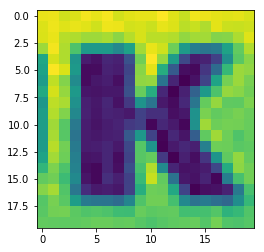

 
632
Was classified as an: K


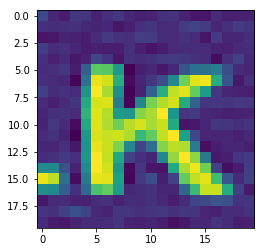

 
633
Was classified as an: K


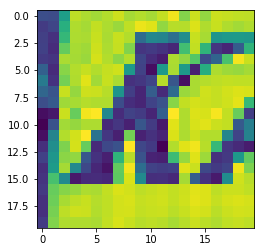

 
634
Was classified as an: K


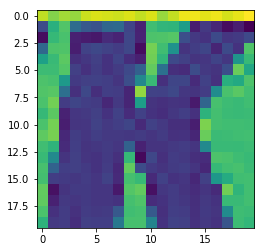

 
635
Was classified as an: K


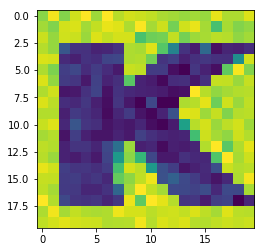

 
636
Was classified as an: K


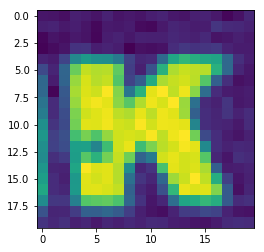

 
637
Was classified as an: K


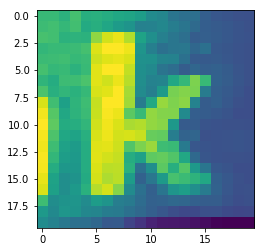

 
638
Was classified as an: K


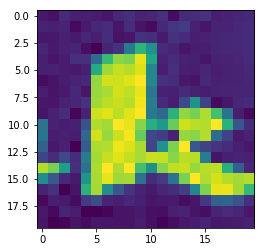

 
639
Was classified as an: K


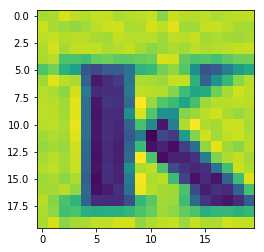

 
640
Was classified as an: K


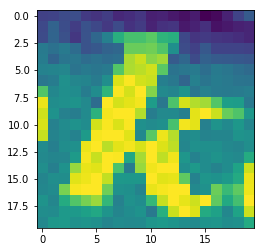

 
641
Was classified as an: K


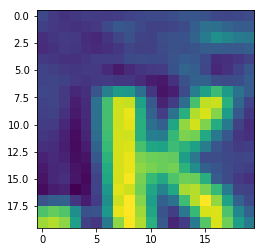

 
642
Was classified as an: K


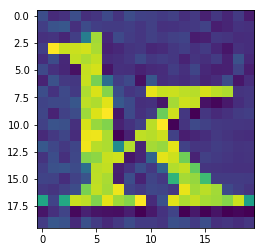

 
643
Was classified as an: K


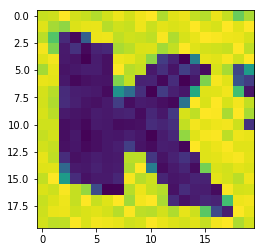

 
644
Was classified as an: K


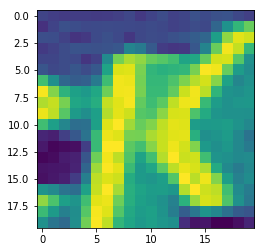

 
645
Was classified as an: K


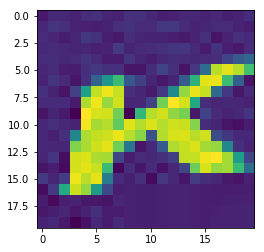

 
646
Was classified as an: K


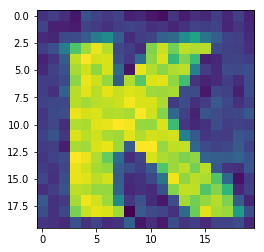

 
647
Was classified as an: K


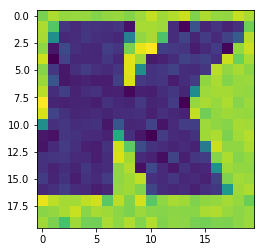

 
648
Was classified as an: K


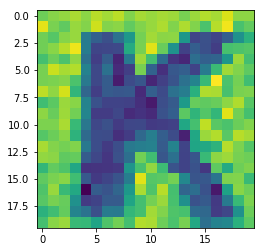

 
649
Was classified as an: K


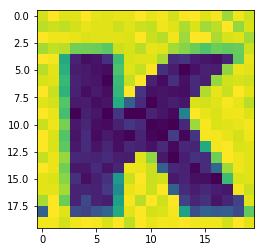

 
650
Was classified as an: K


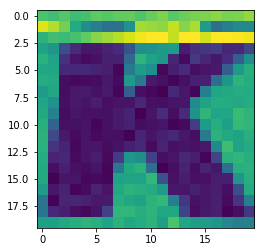

 
651
Was classified as an: K


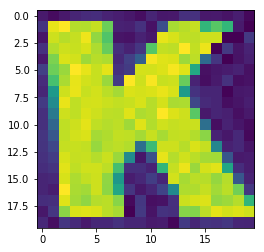

 
652
Was classified as an: K


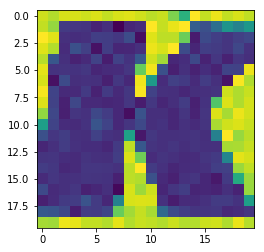

 
653
Was classified as an: K


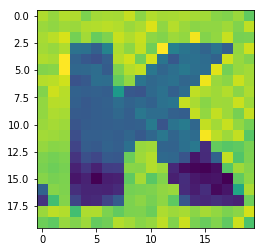

 
654
Was classified as an: K


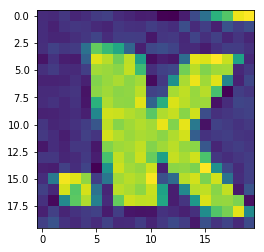

 
655
Was classified as an: L


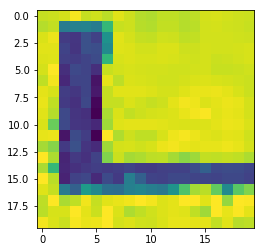

 
656
Was classified as an: L


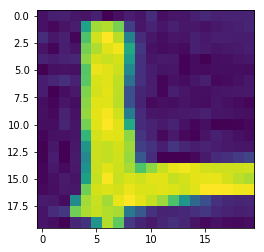

 
657
Was classified as an: L


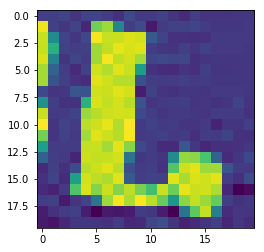

 
658
Was classified as an: L


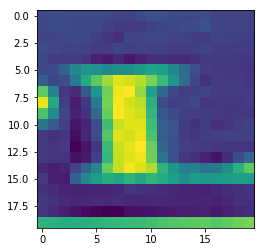

 
659
Was classified as an: L


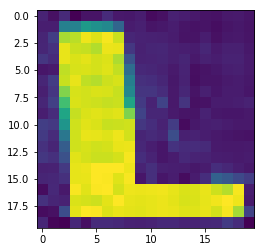

 
660
Was classified as an: L


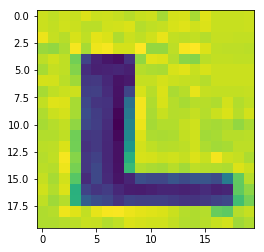

 
661
Was classified as an: L


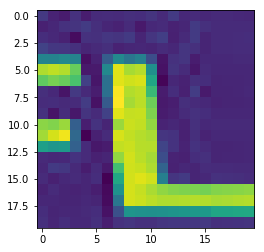

 
662
Was classified as an: I


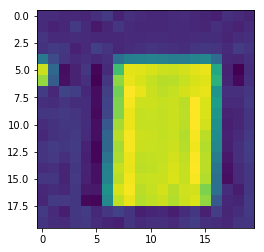

 
663
Was classified as an: L


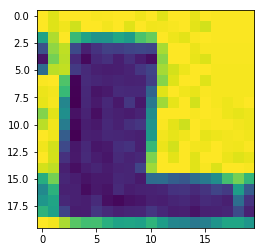

 
664
Was classified as an: L


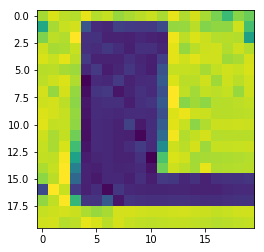

 
665
Was classified as an: L


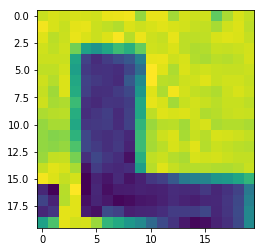

 
666
Was classified as an: L


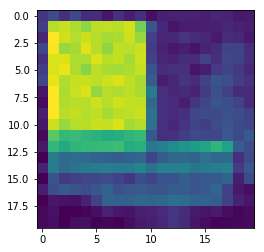

 
667
Was classified as an: L


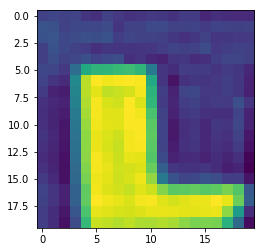

 
668
Was classified as an: L


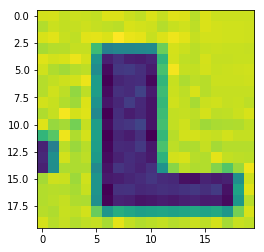

 
669
Was classified as an: L


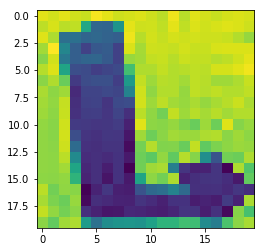

 
670
Was classified as an: L


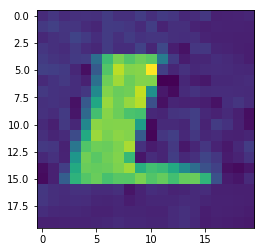

 
671
Was classified as an: L


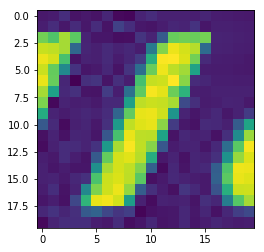

 
672
Was classified as an: L


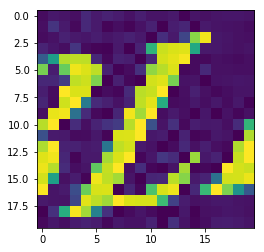

 
673
Was classified as an: L


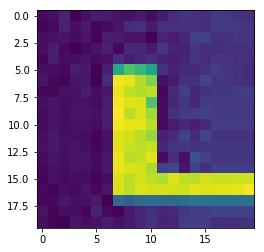

 
674
Was classified as an: L


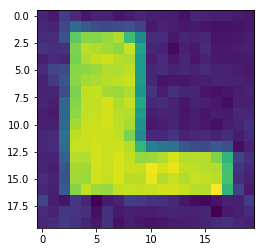

 
675
Was classified as an: L


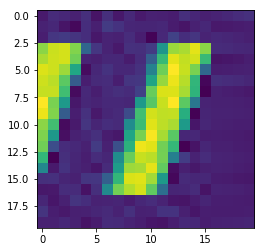

 
676
Was classified as an: L


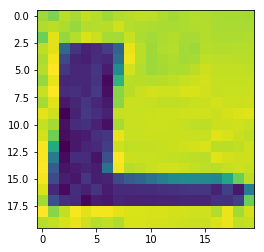

 
677
Was classified as an: L


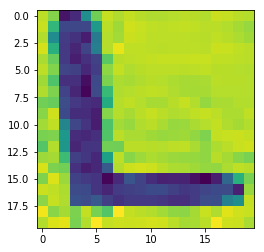

 
678
Was classified as an: L


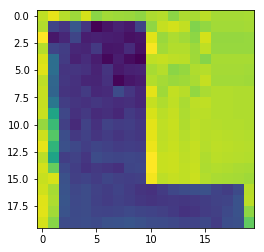

 
679
Was classified as an: L


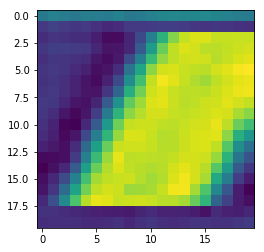

 
680
Was classified as an: L


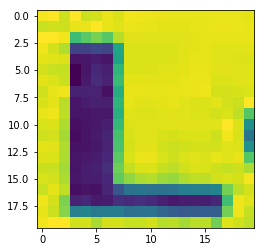

 
681
Was classified as an: L


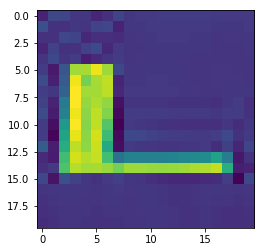

 
682
Was classified as an: L


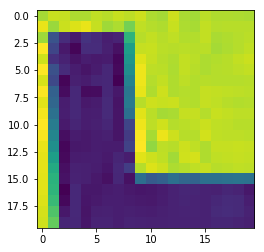

 
683
Was classified as an: I


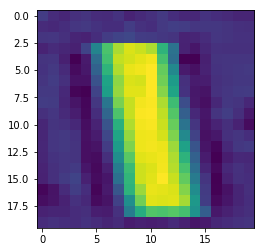

 
684
Was classified as an: L


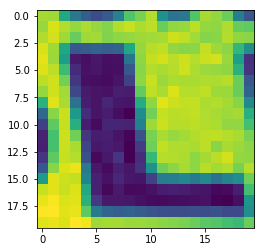

 
685
Was classified as an: L


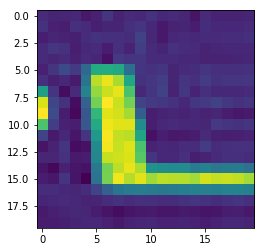

 
686
Was classified as an: L


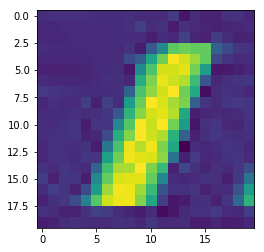

 
687
Was classified as an: L


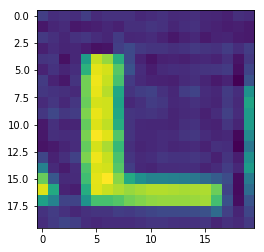

 
688
Was classified as an: L


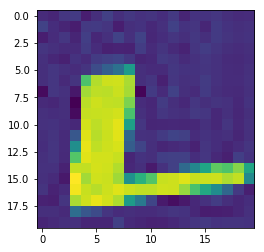

 
689
Was classified as an: L


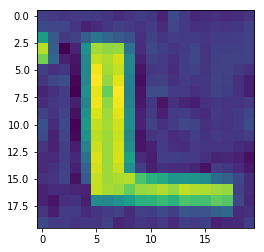

 
690
Was classified as an: L


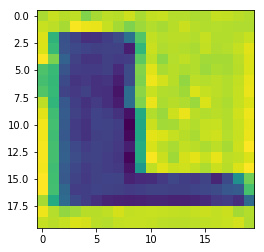

 
691
Was classified as an: L


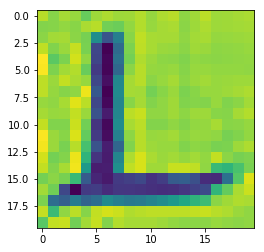

 
692
Was classified as an: L


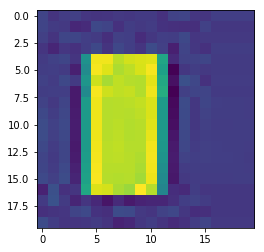

 
693
Was classified as an: L


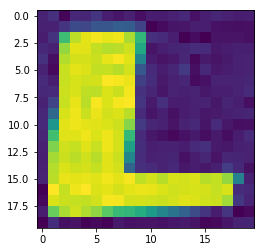

 
694
Was classified as an: L


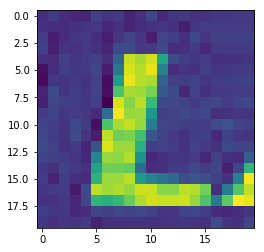

 
695
Was classified as an: L


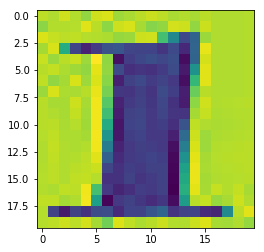

 
696
Was classified as an: L


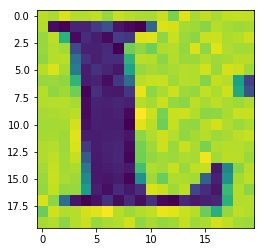

 
697
Was classified as an: L


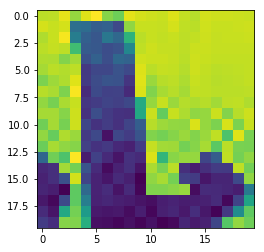

 
698
Was classified as an: L


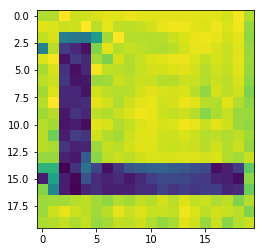

 
699
Was classified as an: L


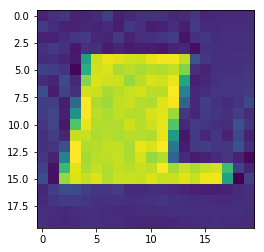

 
700
Was classified as an: I


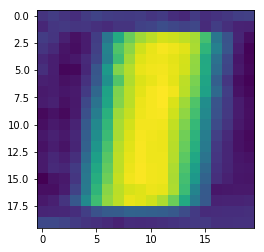

 
701
Was classified as an: L


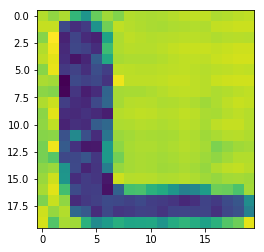

 
702
Was classified as an: L


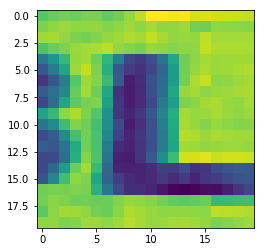

 
703
Was classified as an: L


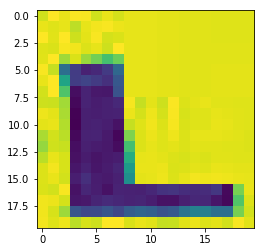

 
704
Was classified as an: L


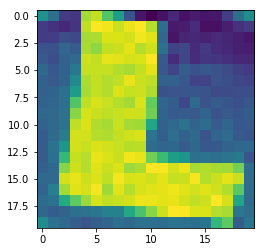

 
705
Was classified as an: L


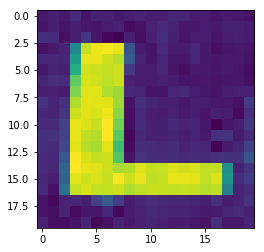

 
706
Was classified as an: L


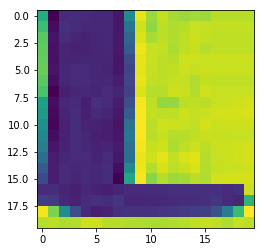

 
707
Was classified as an: L


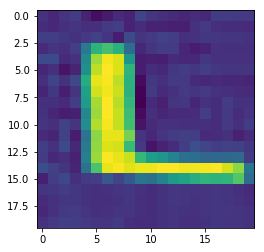

 
708
Was classified as an: I


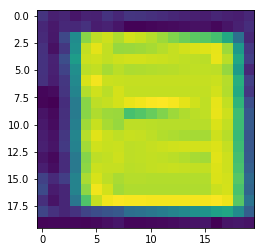

 
709
Was classified as an: L


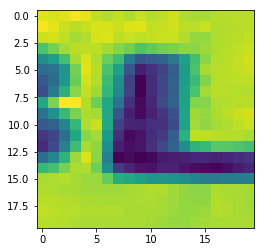

 
710
Was classified as an: M


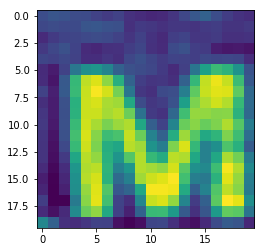

 
711
Was classified as an: M


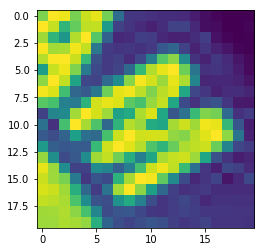

 
712
Was classified as an: M


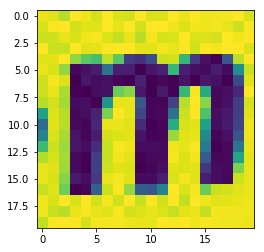

 
713
Was classified as an: M


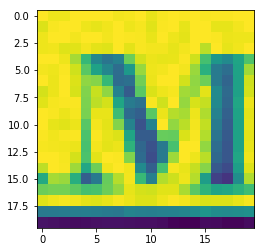

 
714
Was classified as an: M


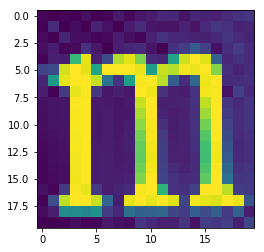

 
715
Was classified as an: M


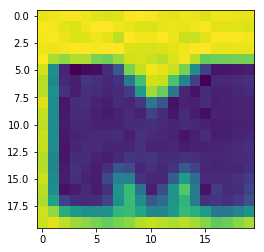

 
716
Was classified as an: O


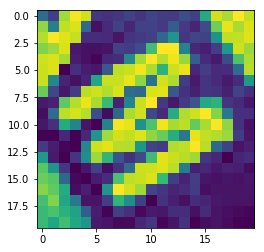

 
717
Was classified as an: M


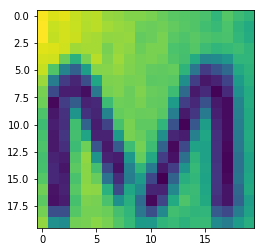

 
718
Was classified as an: M


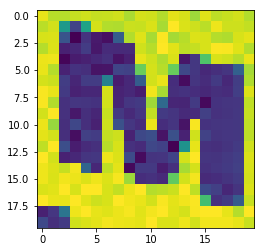

 
719
Was classified as an: M


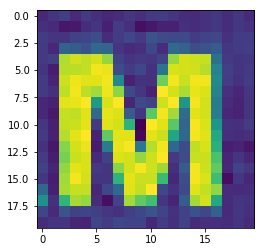

 
720
Was classified as an: N


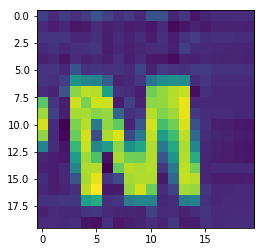

 
721
Was classified as an: M


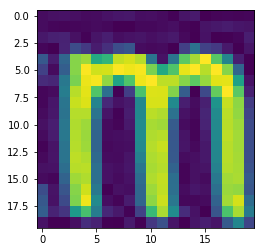

 
722
Was classified as an: M


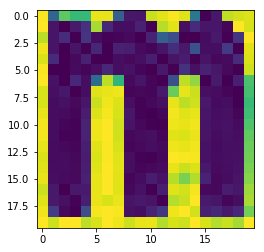

 
723
Was classified as an: M


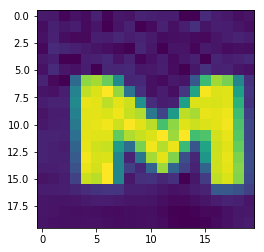

 
724
Was classified as an: M


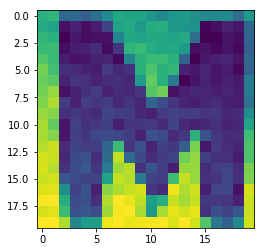

 
725
Was classified as an: M


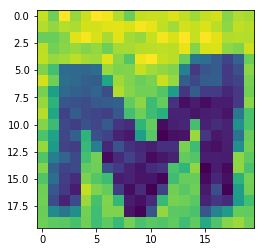

 
726
Was classified as an: M


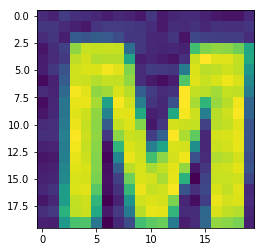

 
727
Was classified as an: N


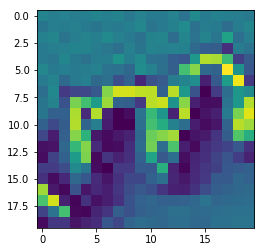

 
728
Was classified as an: M


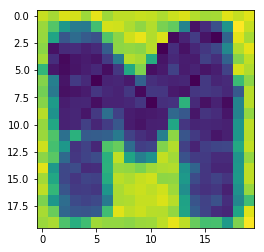

 
729
Was classified as an: H


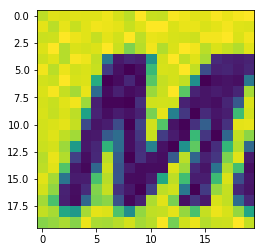

 
730
Was classified as an: M


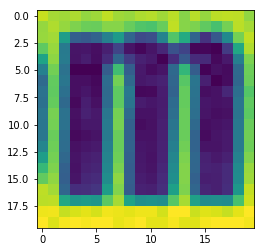

 
731
Was classified as an: M


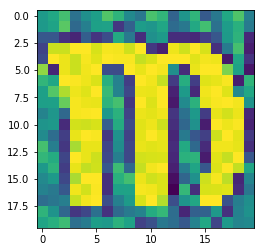

 
732
Was classified as an: M


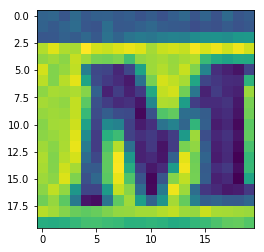

 
733
Was classified as an: M


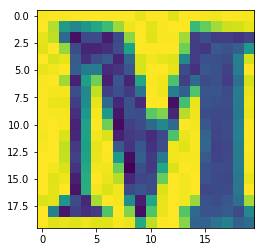

 
734
Was classified as an: M


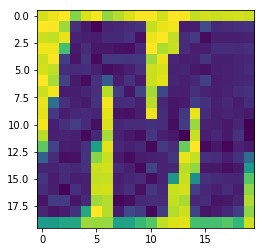

 
735
Was classified as an: M


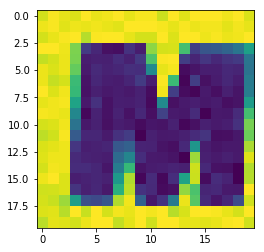

 
736
Was classified as an: M


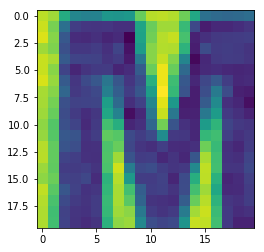

 
737
Was classified as an: M


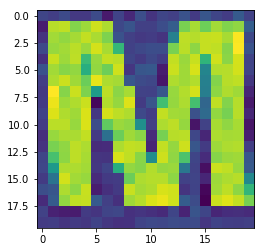

 
738
Was classified as an: M


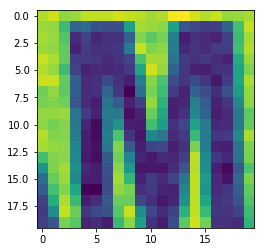

 
739
Was classified as an: N


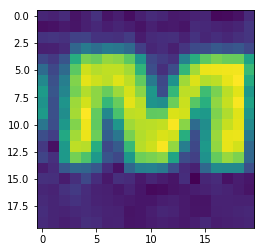

 
740
Was classified as an: R


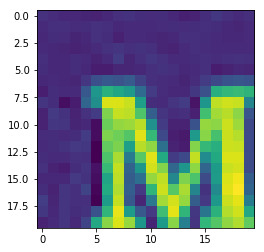

 
741
Was classified as an: M


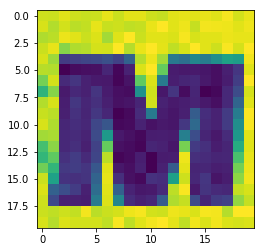

 
742
Was classified as an: M


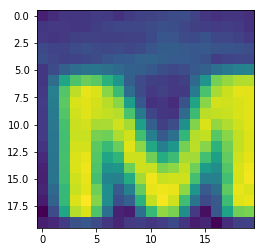

 
743
Was classified as an: M


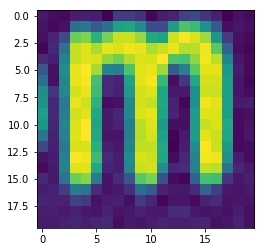

 
744
Was classified as an: M


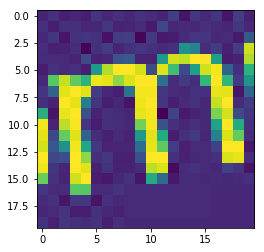

 
745
Was classified as an: M


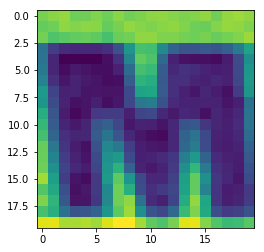

 
746
Was classified as an: M


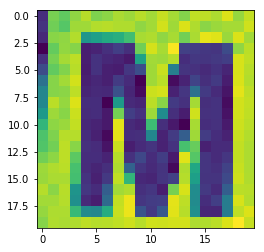

 
747
Was classified as an: M


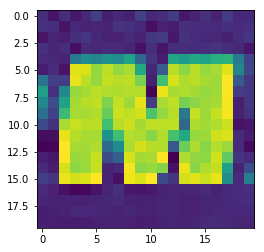

 
748
Was classified as an: M


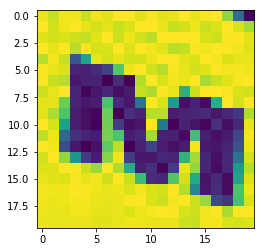

 
749
Was classified as an: N


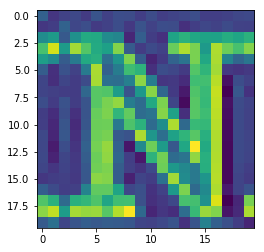

 
750
Was classified as an: N


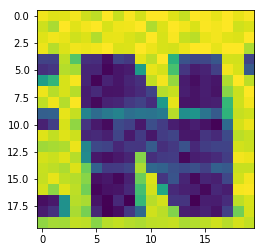

 
751
Was classified as an: N


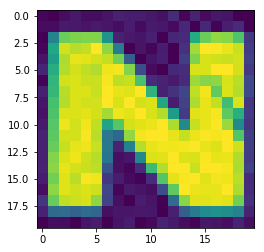

 
752
Was classified as an: N


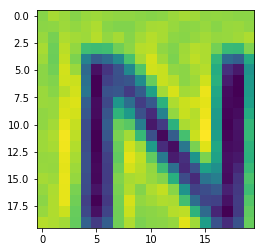

 
753
Was classified as an: K


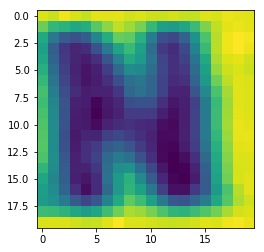

 
754
Was classified as an: N


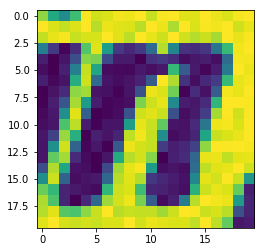

 
755
Was classified as an: N


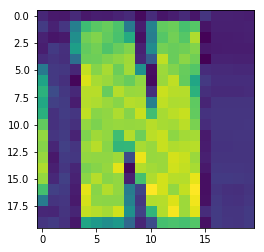

 
756
Was classified as an: R


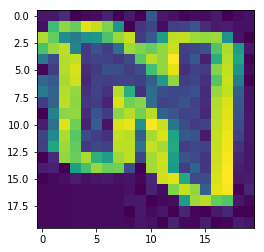

 
757
Was classified as an: N


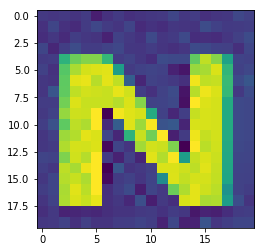

 
758
Was classified as an: N


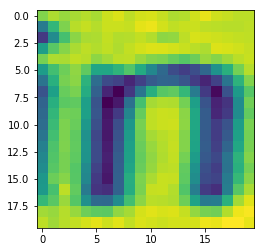

 
759
Was classified as an: N


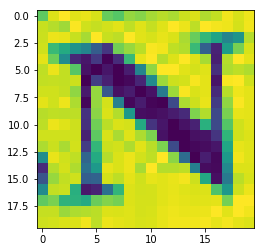

 
760
Was classified as an: N


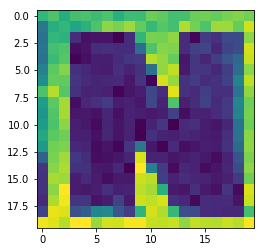

 
761
Was classified as an: N


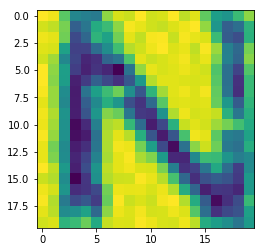

 
762
Was classified as an: N


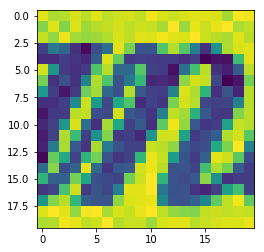

 
763
Was classified as an: N


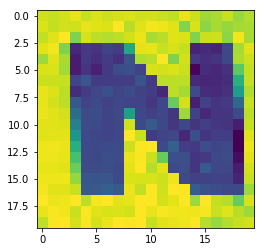

 
764
Was classified as an: N


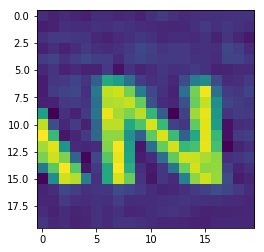

 
765
Was classified as an: N


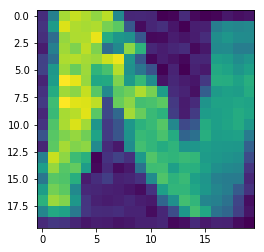

 
766
Was classified as an: N


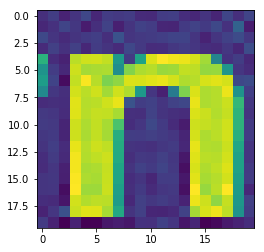

 
767
Was classified as an: N


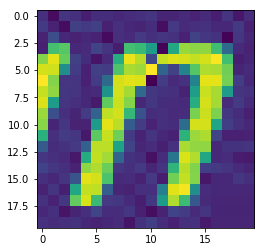

 
768
Was classified as an: N


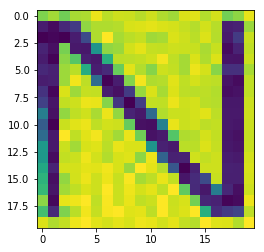

 
769
Was classified as an: N


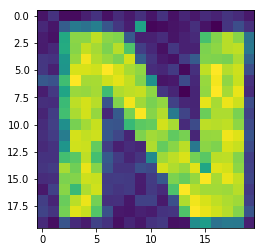

 
770
Was classified as an: N


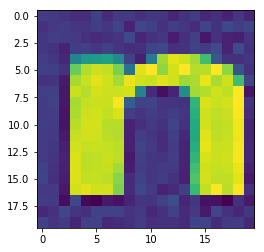

 
771
Was classified as an: N


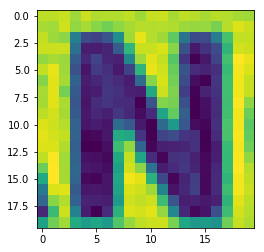

 
772
Was classified as an: N


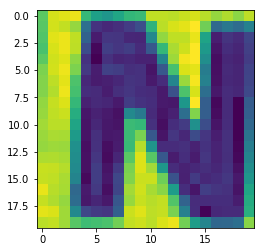

 
773
Was classified as an: N


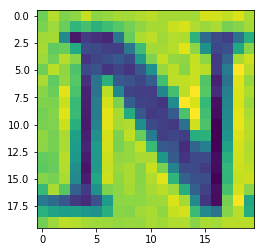

 
774
Was classified as an: N


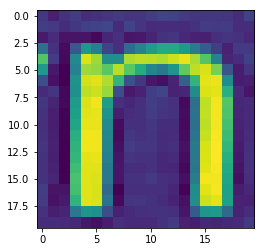

 
775
Was classified as an: A


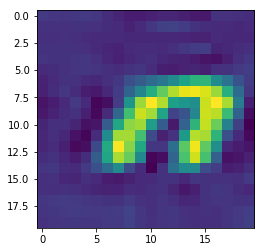

 
776
Was classified as an: N


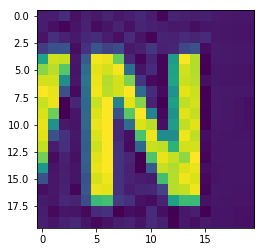

 
777
Was classified as an: N


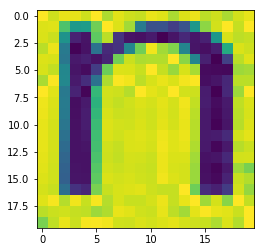

 
778
Was classified as an: N


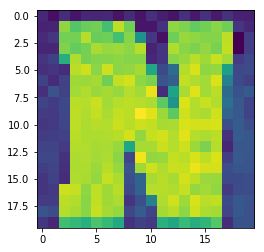

 
779
Was classified as an: N


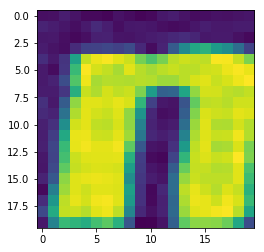

 
780
Was classified as an: N


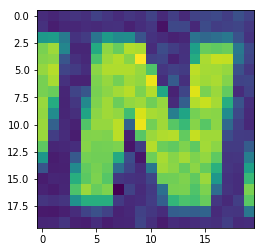

 
781
Was classified as an: N


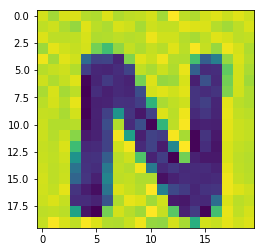

 
782
Was classified as an: N


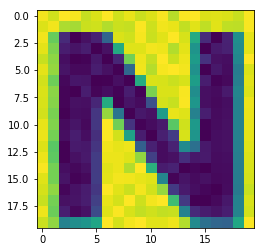

 
783
Was classified as an: N


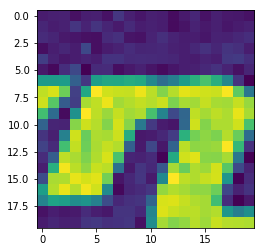

 
784
Was classified as an: N


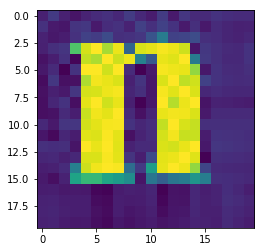

 
785
Was classified as an: N


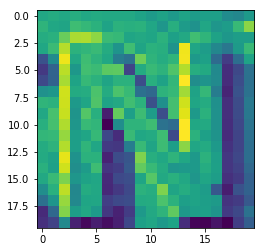

 
786
Was classified as an: N


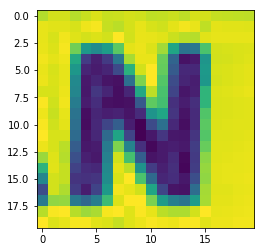

 
787
Was classified as an: N


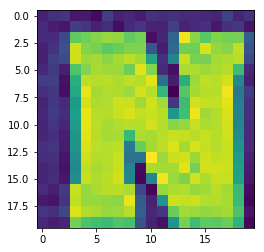

 
788
Was classified as an: N


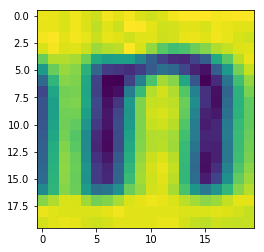

 
789
Was classified as an: N


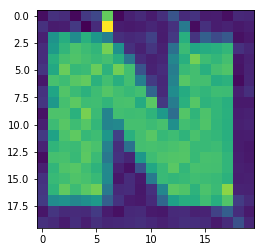

 
790
Was classified as an: N


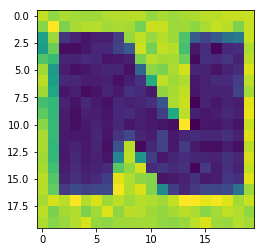

 
791
Was classified as an: N


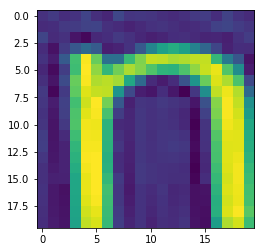

 
792
Was classified as an: N


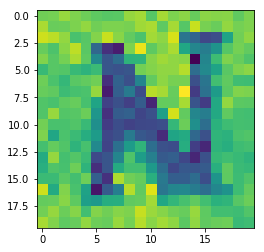

 
793
Was classified as an: N


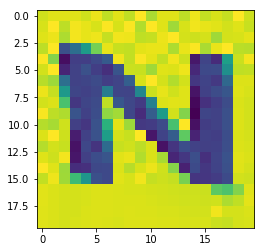

 
794
Was classified as an: N


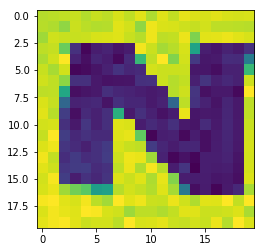

 
795
Was classified as an: N


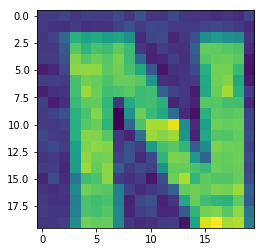

 
796
Was classified as an: N


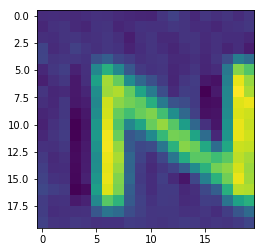

 
797
Was classified as an: N


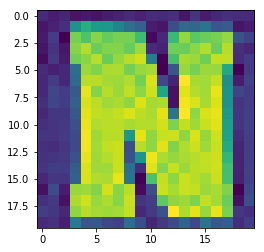

 
798
Was classified as an: N


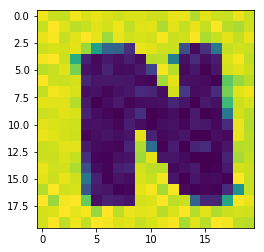

 
799
Was classified as an: N


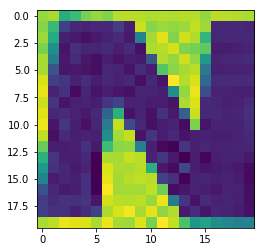

 
800
Was classified as an: N


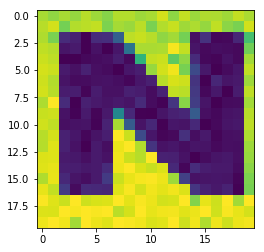

 
801
Was classified as an: N


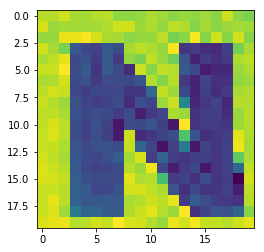

 
802
Was classified as an: N


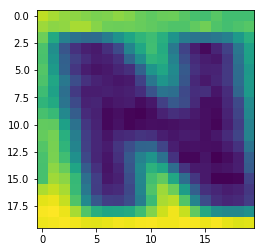

 
803
Was classified as an: N


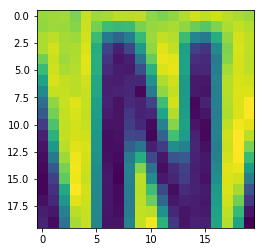

 
804
Was classified as an: N


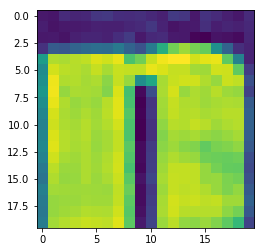

 
805
Was classified as an: N


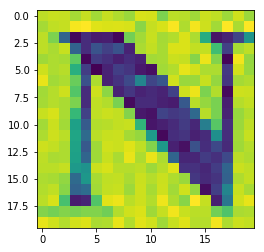

 
806
Was classified as an: N


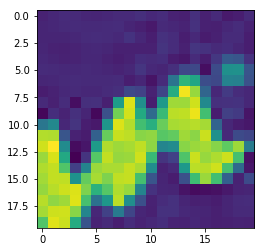

 
807
Was classified as an: N


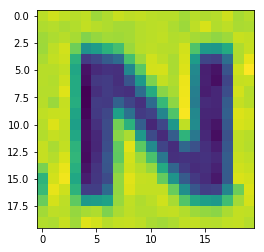

 
808
Was classified as an: N


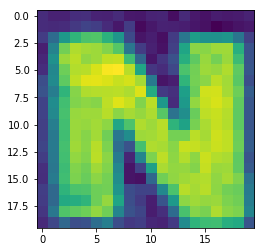

 
809
Was classified as an: N


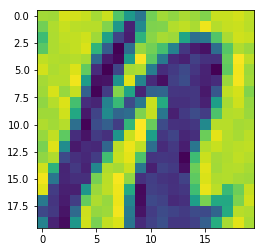

 
810
Was classified as an: N


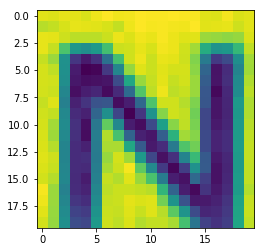

 
811
Was classified as an: N


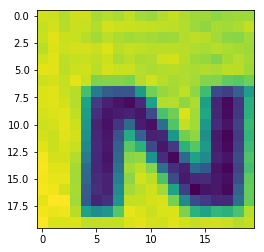

 
812
Was classified as an: N


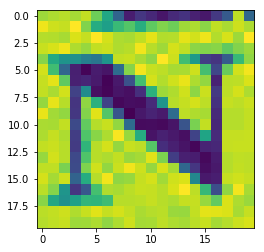

 
813
Was classified as an: N


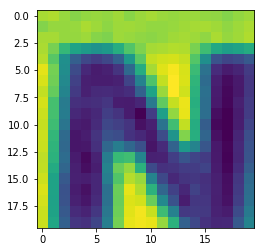

 
814
Was classified as an: N


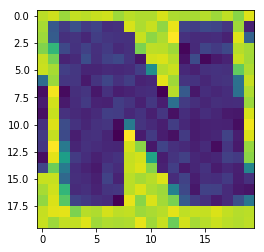

 
815
Was classified as an: N


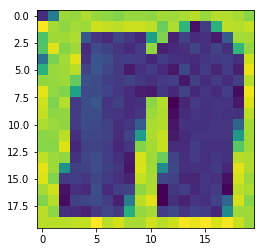

 
816
Was classified as an: N


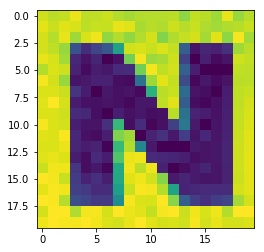

 
817
Was classified as an: N


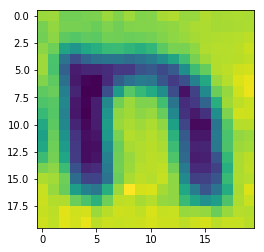

 
818
Was classified as an: N


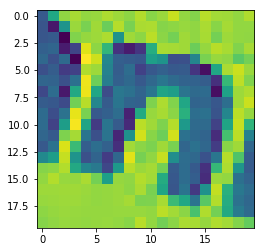

 
819
Was classified as an: N


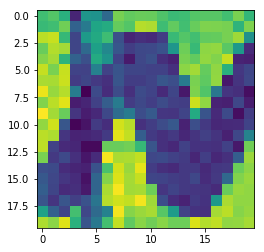

 
820
Was classified as an: N


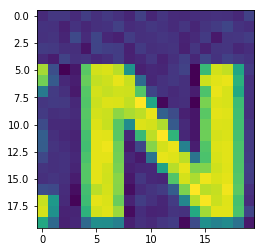

 
821
Was classified as an: N


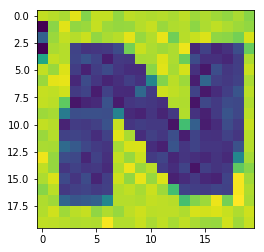

 
822
Was classified as an: N


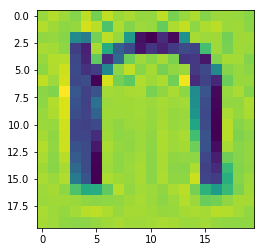

 
823
Was classified as an: N


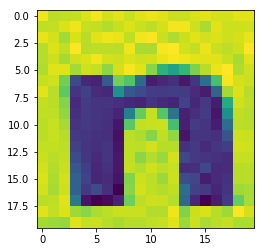

 
824
Was classified as an: N


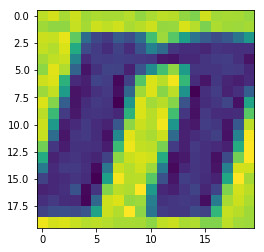

 
825
Was classified as an: N


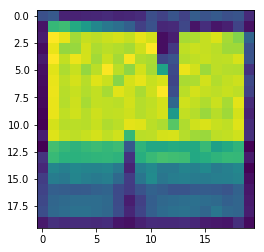

 
826
Was classified as an: N


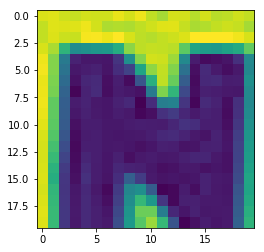

 
827
Was classified as an: N


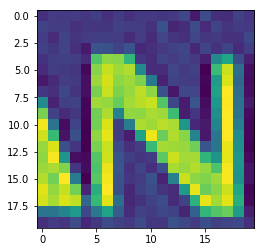

 
828
Was classified as an: N


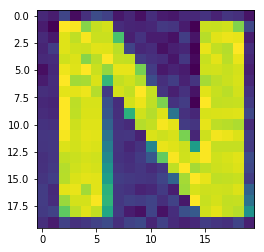

 
829
Was classified as an: N


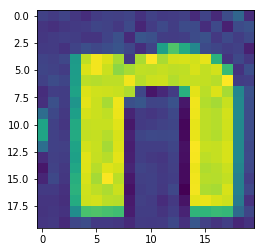

 
830
Was classified as an: N


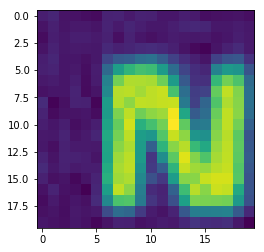

 
831
Was classified as an: N


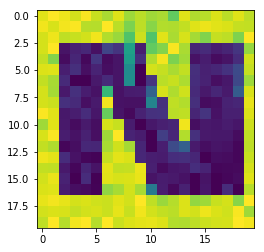

 
832
Was classified as an: N


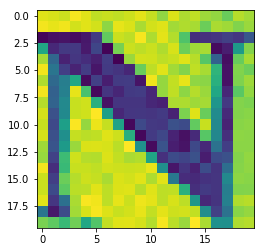

 
833
Was classified as an: N


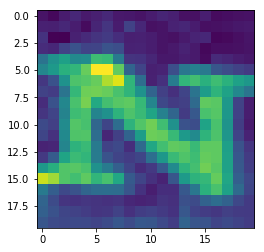

 
834
Was classified as an: N


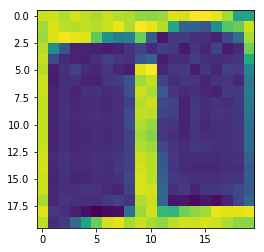

 
835
Was classified as an: N


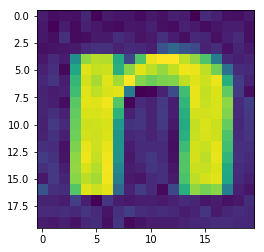

 
836
Was classified as an: N


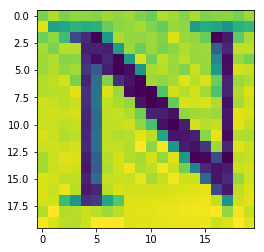

 
837
Was classified as an: N


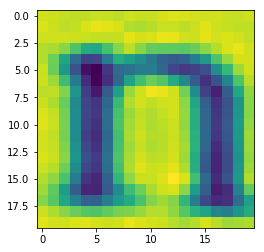

 
838
Was classified as an: N


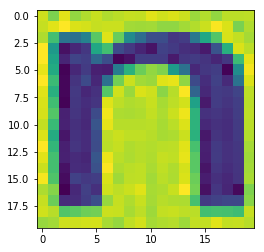

 
839
Was classified as an: N


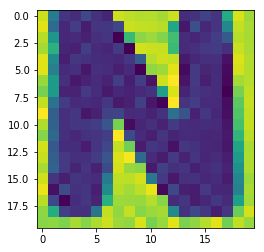

 
840
Was classified as an: N


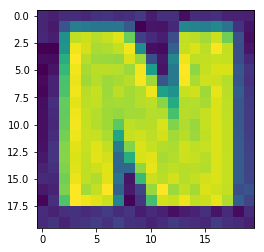

 
841
Was classified as an: N


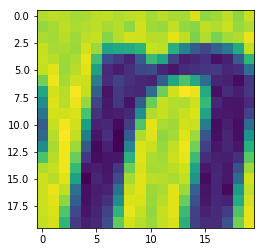

 
842
Was classified as an: N


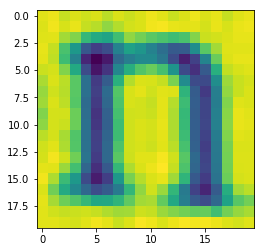

 
843
Was classified as an: N


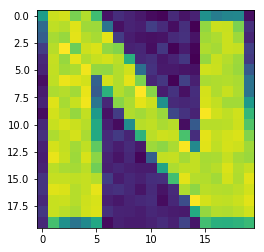

 
844
Was classified as an: N


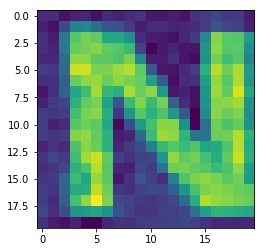

 
845
Was classified as an: N


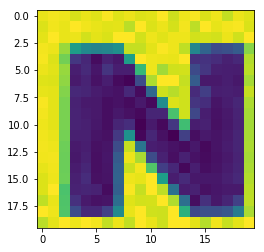

 
846
Was classified as an: N


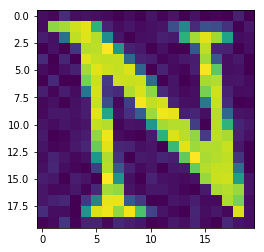

 
847
Was classified as an: N


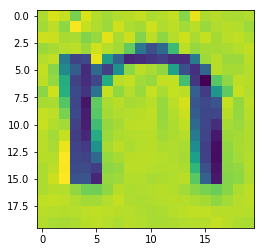

 
848
Was classified as an: N


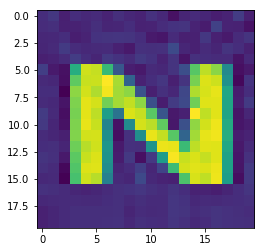

 
849
Was classified as an: O


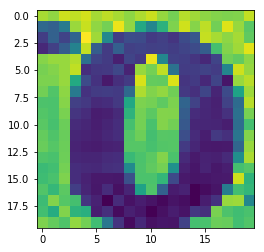

 
850
Was classified as an: O


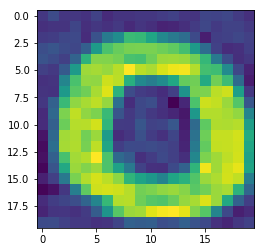

 
851
Was classified as an: O


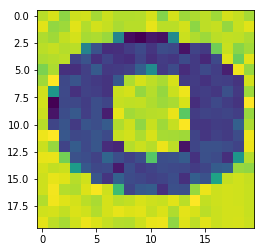

 
852
Was classified as an: O


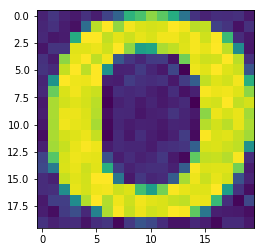

 
853
Was classified as an: O


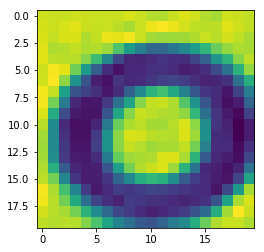

 
854
Was classified as an: O


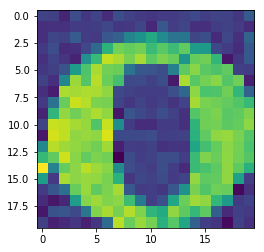

 
855
Was classified as an: O


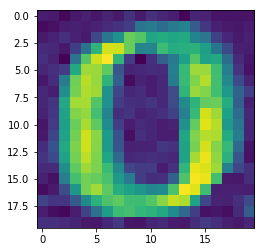

 
856
Was classified as an: O


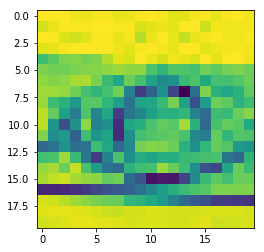

 
857
Was classified as an: O


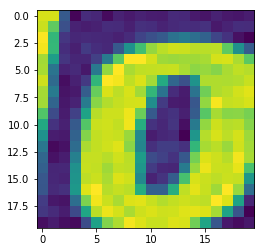

 
858
Was classified as an: B


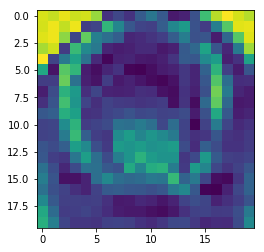

 
859
Was classified as an: O


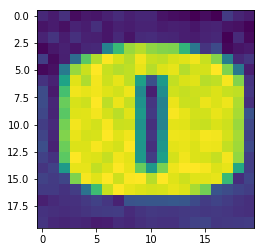

 
860
Was classified as an: O


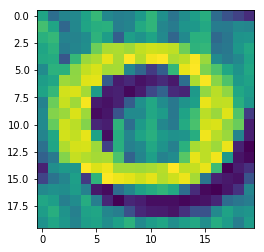

 
861
Was classified as an: O


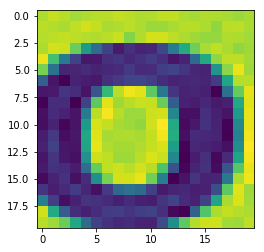

 
862
Was classified as an: O


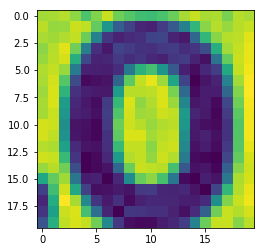

 
863
Was classified as an: O


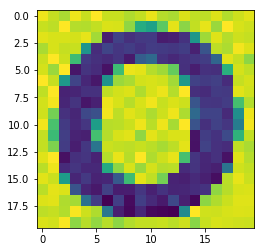

 
864
Was classified as an: O


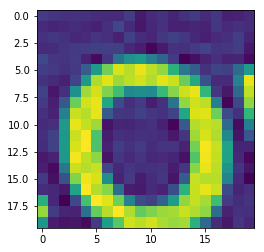

 
865
Was classified as an: O


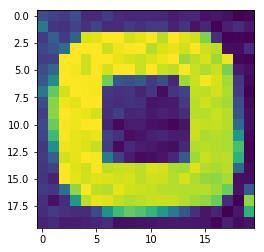

 
866
Was classified as an: O


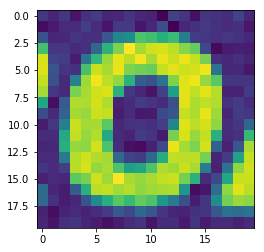

 
867
Was classified as an: O


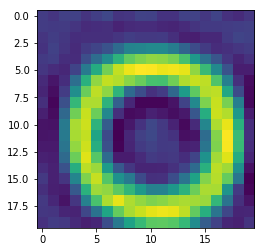

 
868
Was classified as an: O


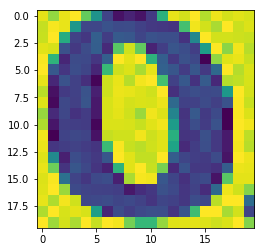

 
869
Was classified as an: O


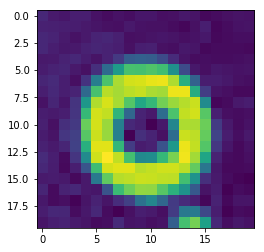

 
870
Was classified as an: O


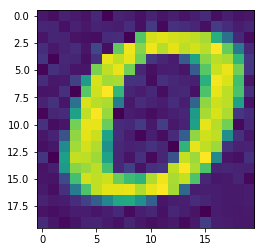

 
871
Was classified as an: O


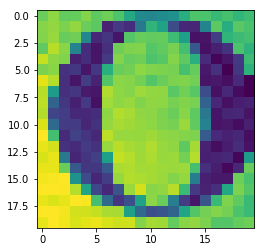

 
872
Was classified as an: O


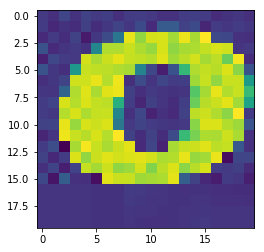

 
873
Was classified as an: O


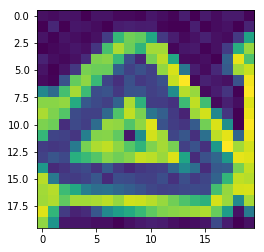

 
874
Was classified as an: O


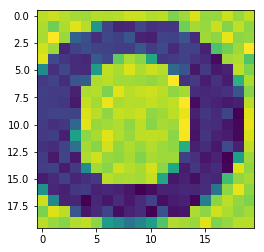

 
875
Was classified as an: O


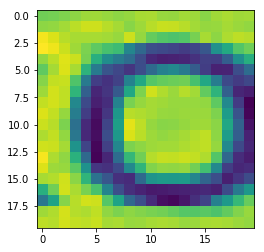

 
876
Was classified as an: O


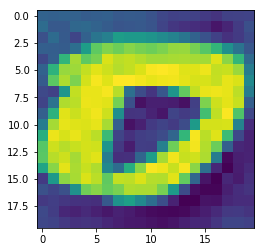

 
877
Was classified as an: O


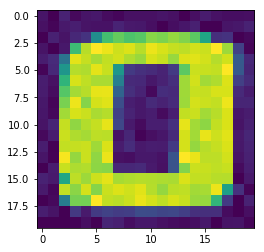

 
878
Was classified as an: D


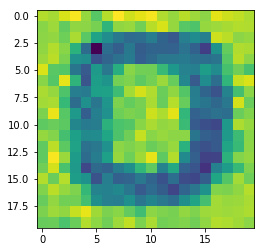

 
879
Was classified as an: O


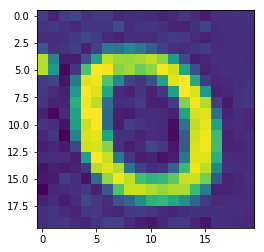

 
880
Was classified as an: O


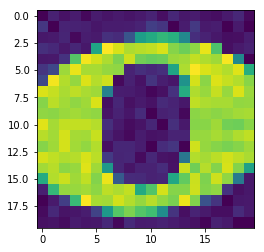

 
881
Was classified as an: O


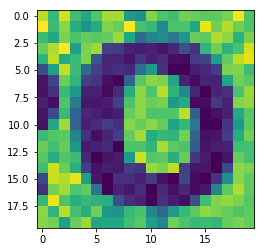

 
882
Was classified as an: O


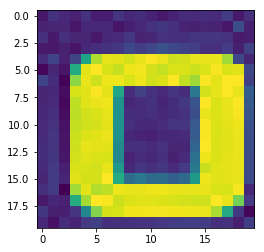

 
883
Was classified as an: O


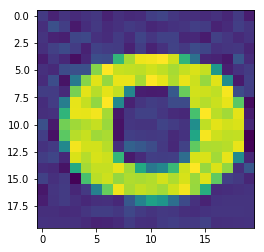

 
884
Was classified as an: O


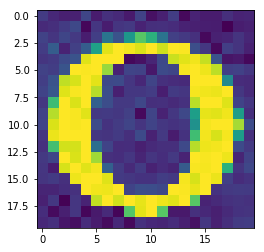

 
885
Was classified as an: O


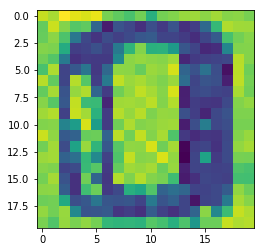

 
886
Was classified as an: O


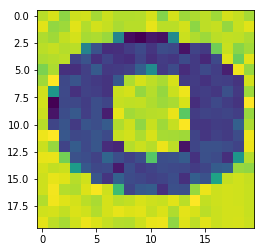

 
887
Was classified as an: O


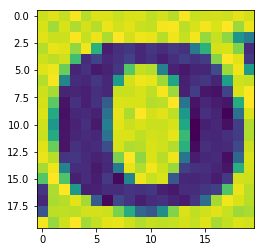

 
888
Was classified as an: O


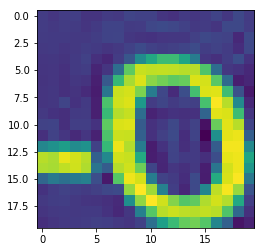

 
889
Was classified as an: O


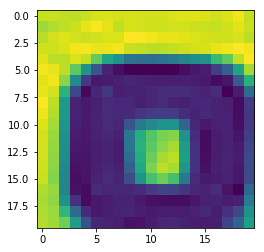

 
890
Was classified as an: O


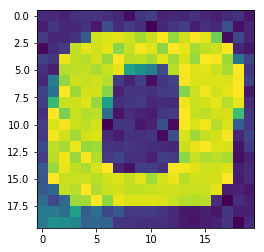

 
891
Was classified as an: O


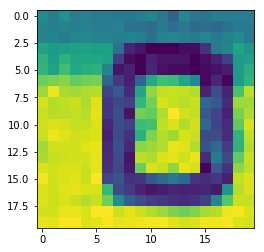

 
892
Was classified as an: O


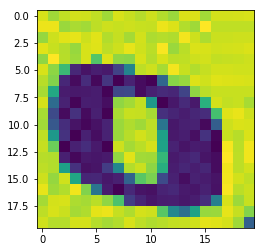

 
893
Was classified as an: O


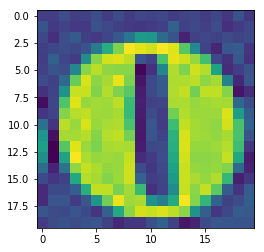

 
894
Was classified as an: O


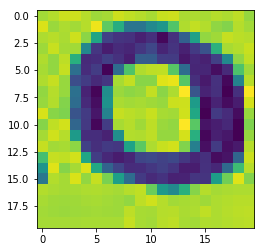

 
895
Was classified as an: D


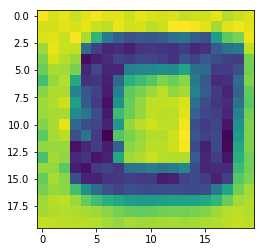

 
896
Was classified as an: O


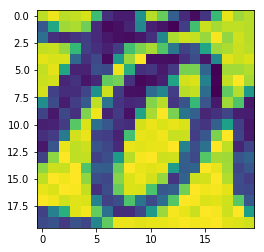

 
897
Was classified as an: O


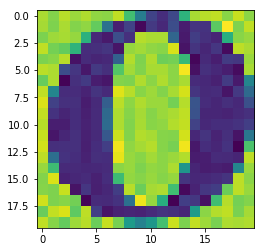

 
898
Was classified as an: O


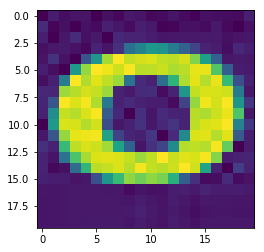

 
899
Was classified as an: O


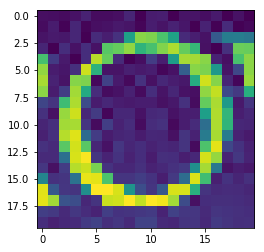

In [17]:
# Ikke ta med
# Print classifications:

# kNN:
o = 1
res = []
plot = []
for j in range(900):
    o=o+1
    # print("Was classified as an: ", numberDict.get(y_merged_test_pred_rf[o][0]))
    #print(test_set["Letter"][o])

    #print((test_set_raw.iloc[o,:]))
    
    a = ((test_set.drop(labels='Letter', axis = 1)).loc[o].tolist())
    plot.append(np.reshape(a,(20,20)))
    
    
    # a = np.reshape(a, (20, 20))
    a = pd.DataFrame(data=a).T

    #print(a.values)
    #a
    #print(np.reshape(a,(20,20))
    
    # a = resize[:, :, 0]
    #a=np.reshape(window,20*20)
    #a = pd.DataFrame(data=window).T
    #a.append(window)
    #list1 = (window.values[0])
        
    
    
    
    #a = np.reshape(a,20,20)
    #a = np.asarray(a)
    
    #print(len(a))
    a=(model_tensor.predict(a.values))

    res.append(a)
    
    #print(a)
    
    
# Random Forest:
#a.values
# print(res)


# Printer den klassiserte dataen:
print("ll ")
i = 0
for r in res:
    print(i)
    num = (np.where(r[0] == (np.amax((r[0]))))[0][0])
    print("Was classified as an:",numberDict.get(num))
    plt.imshow(plot[i])
    plt.show()
    i+=1

    print(" ")


    


## Sliding window detection implemented with TensorFlow:

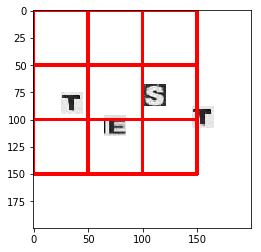

In [27]:
## Sliding window detection:

import cv2
import matplotlib.pyplot as plt
import numpy as np


def OCR(imagepath):
    # read the image and define the stepSize and window size 
    image = np.array(cv2.imread(imagepath)) # your image path
    tmp = image # for drawing a rectangle
    stepSize = 50
    (w_width, w_height) = (50,50) # window size
    class_letter = []
    number=[] # To keep track of which square in the grid that is classified
    i = 0 # counter for the number
    windows=[]
    for x in range(0, image.shape[1] - w_width , stepSize):
        for y in range(0, image.shape[0] - w_height, stepSize):
            window = image[x:x + w_width, y:y + w_height, :]
            resize = cv2.resize(window,(20,20),interpolation =cv2.INTER_AREA)
            window = np.asarray(resize)
            window = resize[:, :, 0]
            window=np.reshape(window,20*20)
            window = pd.DataFrame(data=window).T
            windows.append(window)
            list1 = (window.values[0])
            
            # Check if the window is "blank"
            if all(x == list1[0] for x in list1):
                print(" ", end="\r")
                # print("All elements in list are same.")
            else:
                # Classify window:
                prediction  = model_tensor.predict(window.values)
                #class_letter.append(prediction)

                # knn
                class_letter.append(test_classifier_sliding(clf_n,window))
                number.append(i)

            # Plot the grid on top of the image:
            cv2.rectangle(tmp, (x, y), (x + w_width, y + w_height), (255, 0, 0), 2) # draw rectangle on image
            plt.imshow(np.array(tmp).astype('uint8'))
            i+=1
    # show all windows
    plt.show()
    return windows, number, class_letter

def test_classifier_sliding(clf, data):
    y = []
    for row in data.iterrows():
        y.append(clf.predict(([row[1].tolist()])))
    return y

def test_classifier_sliding1(clf, data):
    y = []
    for row in data:
        y.append(clf.predict(([row[1].tolist()])))
    return y


    
windows, number, class_letter = OCR("./dataset3/detection-images/detection-1.jpg")



## Prints classified data from image. The number corresponds to window square

In [28]:
# Prints the classified data and which square in the grid it belongs to:
print(" ")
i = 0
for c in class_letter:
    num = (np.where(c[0] == (np.amax((c[0]))))[0][0])
    print(numberDict.get(num),number[i])
    i+=1 

 
A 3
A 4
A 5
A 7
A 8


## Prints the windows from sliding window detection

teller:  0
   0    1    2    3    4    5    6    7    8    9    ...  390  391  392  393  \
0  255  255  255  255  255  255  255  255  255  255  ...  255  255  255  255   

   394  395  396  397  398  399  
0  255  255  255  255  255  255  

[1 rows x 400 columns]


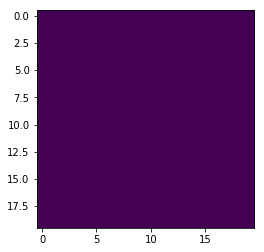

teller:  1
   0    1    2    3    4    5    6    7    8    9    ...  390  391  392  393  \
0  255  255  255  255  255  255  255  255  255  255  ...  255  255  255  255   

   394  395  396  397  398  399  
0  255  255  255  255  255  255  

[1 rows x 400 columns]


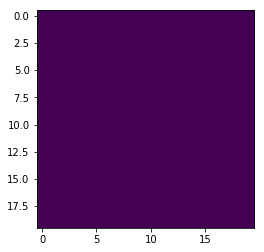

teller:  2
   0    1    2    3    4    5    6    7    8    9    ...  390  391  392  393  \
0  255  255  255  255  255  255  255  255  255  255  ...  255  255  255  255   

   394  395  396  397  398  399  
0  255  255  255  255  255  255  

[1 rows x 400 columns]


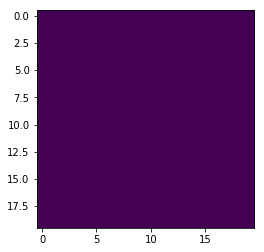

teller:  3
   0    1    2    3    4    5    6    7    8    9    ...  390  391  392  393  \
0  255  255  255  255  255  255  255  255  255  255  ...  255  255  255  255   

   394  395  396  397  398  399  
0  255  255  255  255  255  255  

[1 rows x 400 columns]


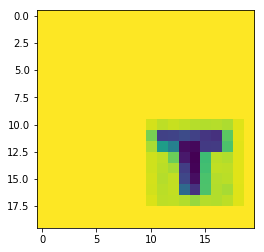

teller:  4
   0    1    2    3    4    5    6    7    8    9    ...  390  391  392  393  \
0  255  255  255  255  255  255  255  255  255  255  ...  218  219  220  219   

   394  395  396  397  398  399  
0  255  255  255  255  255  255  

[1 rows x 400 columns]


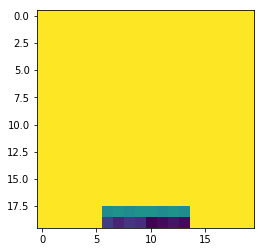

teller:  5
   0    1    2    3    4    5    6    7    8    9    ...  390  391  392  393  \
0  255  255  255  255  255  255  255  255  255  255  ...  255  255  255  255   

   394  395  396  397  398  399  
0  255  255  255  255  238  233  

[1 rows x 400 columns]


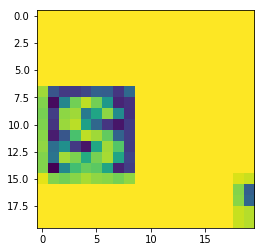

teller:  6
   0    1    2    3    4    5    6    7    8    9    ...  390  391  392  393  \
0  255  255  255  255  255  255  255  255  255  255  ...  255  255  255  255   

   394  395  396  397  398  399  
0  255  255  255  255  255  255  

[1 rows x 400 columns]


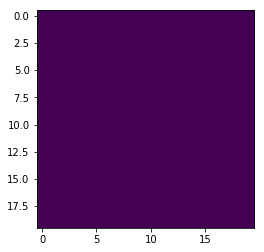

teller:  7
   0    1    2    3    4    5    6    7    8    9    ...  390  391  392  393  \
0  255  255  255  255  255  255  227  250  213  215  ...  255  255  255  255   

   394  395  396  397  398  399  
0  255  255  255  255  255  255  

[1 rows x 400 columns]


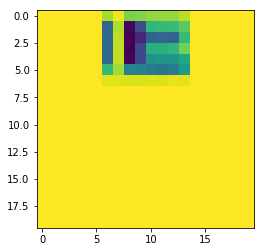

teller:  8
   0    1    2    3    4    5    6    7    8    9    ...  390  391  392  393  \
0  255  255  255  255  255  255  255  255  255  255  ...  255  255  255  255   

   394  395  396  397  398  399  
0  255  255  255  255  255  255  

[1 rows x 400 columns]


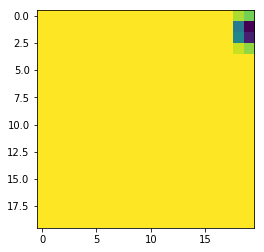

In [29]:
teller = 0
for win in windows:
    print("teller: ", teller)
    
    print(win)
    w = (win).values.tolist()[0]
    w = np.reshape(w, (20, 20))
    plt.imshow(w)
    plt.show()
    # print(w)
    # print(w)
    teller += 1


## Printing Edge Detected Data (test)

In [11]:
data_edges_sigma1_org = detectEdges(original_raw, 1)
data_edges_sigma15_org = detectEdges(original_raw, 1.5)
data_edges_sigma1_aug90 = detectEdges(aug90, 1)
data_edges_sigma1_aug20 = detectEdges(aug20, 1)


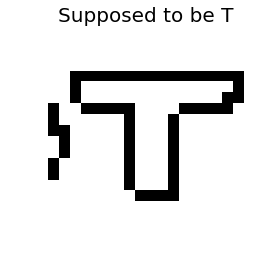

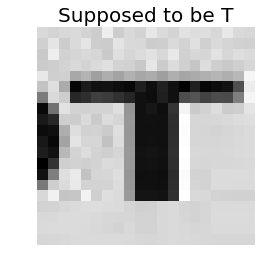

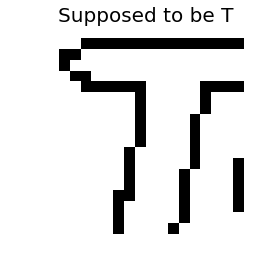

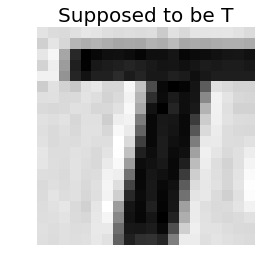

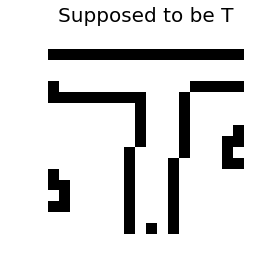

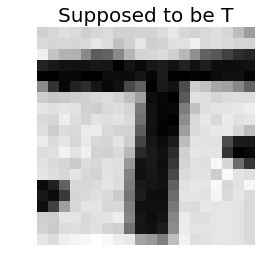

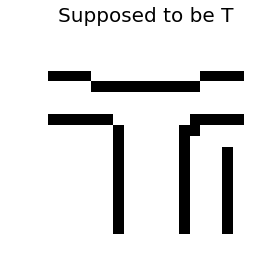

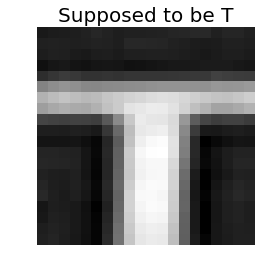

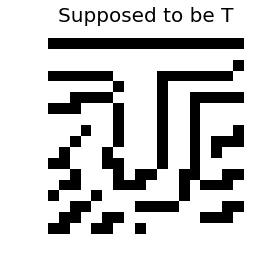

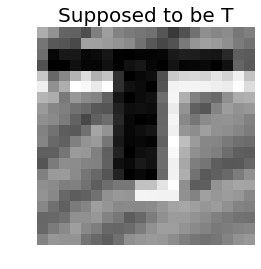

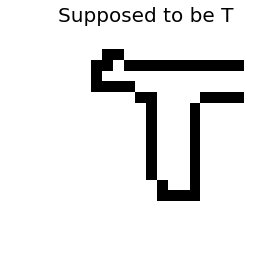

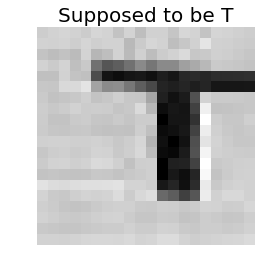

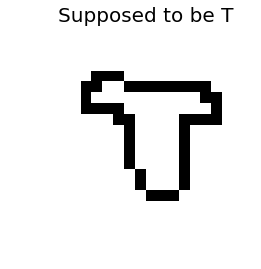

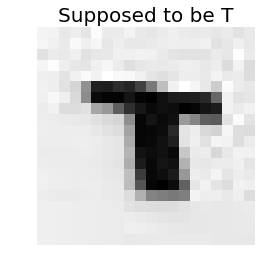

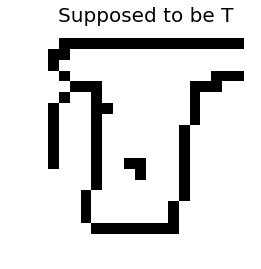

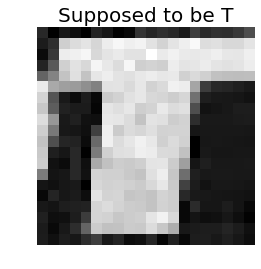

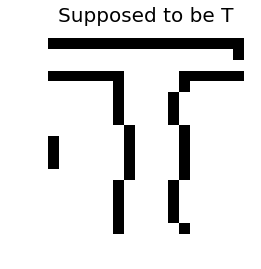

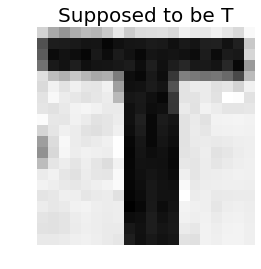

In [168]:
printFromStartToStop(2000, 2009, data_edges_sigma1_org, original_raw)

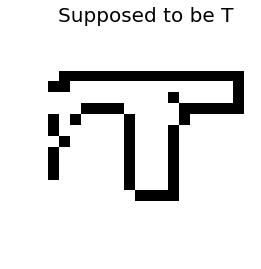

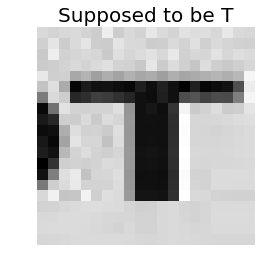

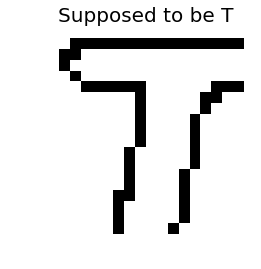

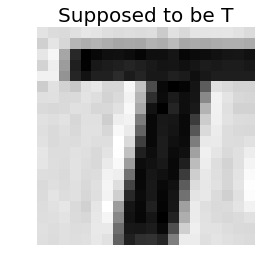

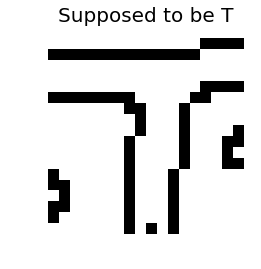

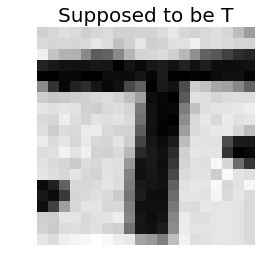

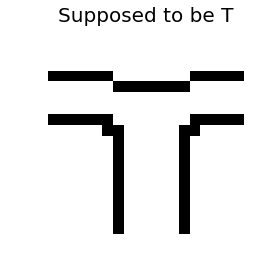

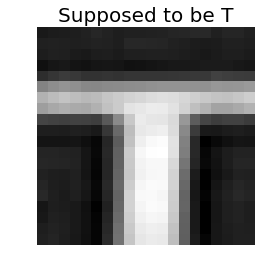

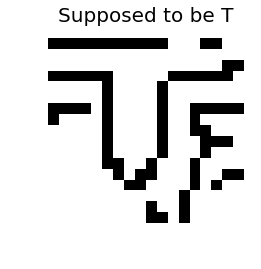

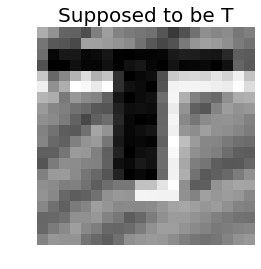

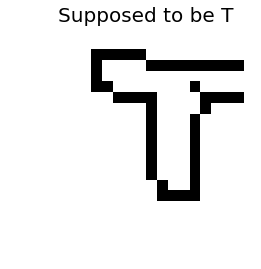

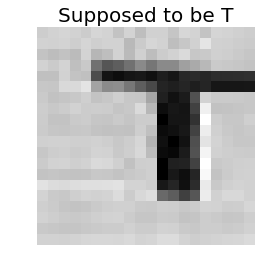

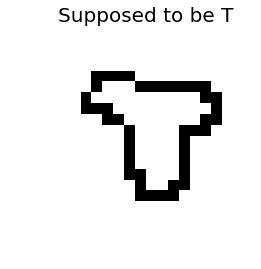

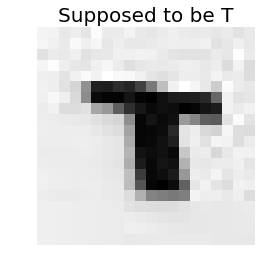

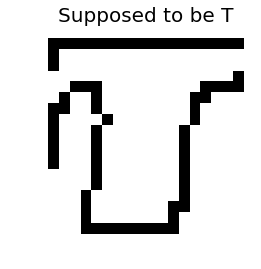

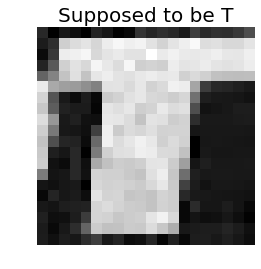

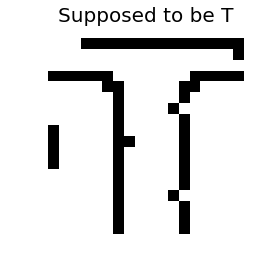

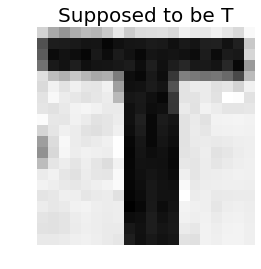

In [170]:
printFromStartToStop(2000, 2009, data_edges_sigma15_org, original_raw)

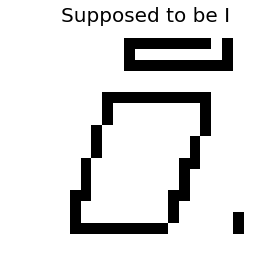

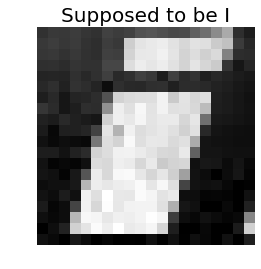

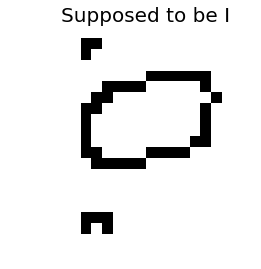

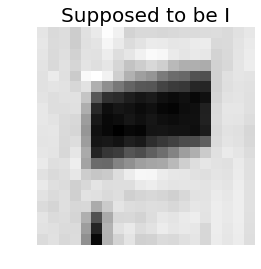

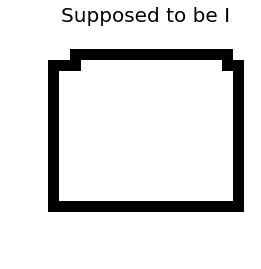

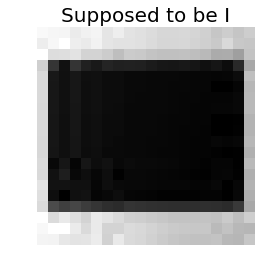

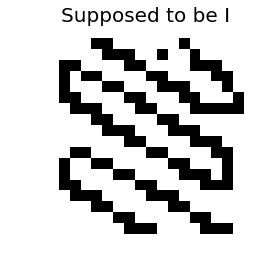

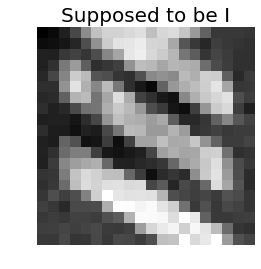

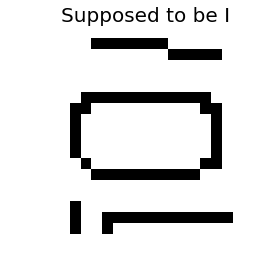

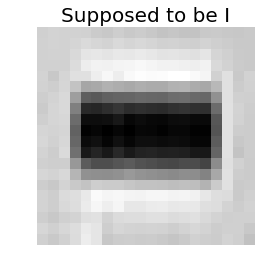

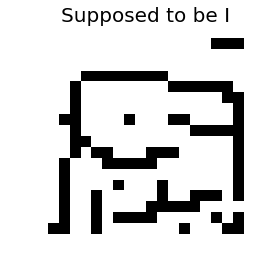

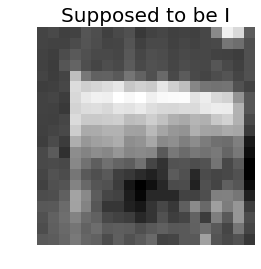

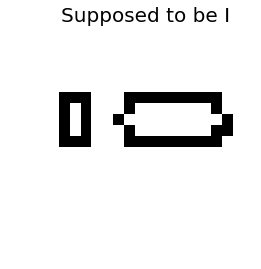

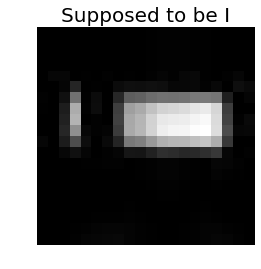

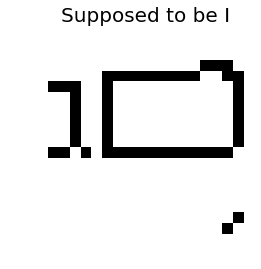

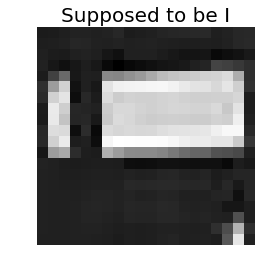

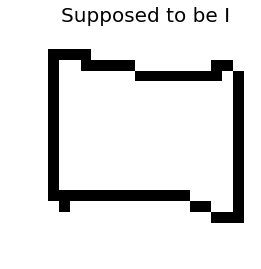

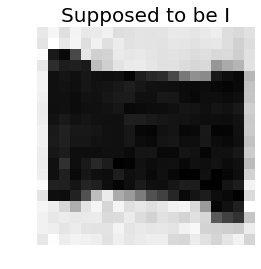

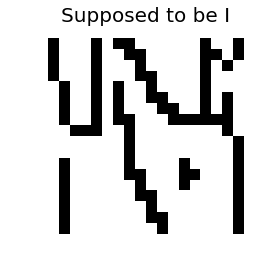

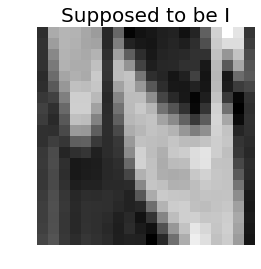

In [14]:
printFromStartToStop(700, 710, data_edges_sigma1_aug90, aug90)

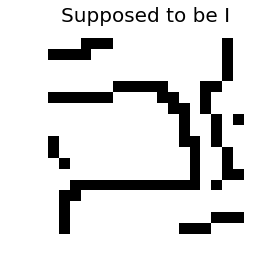

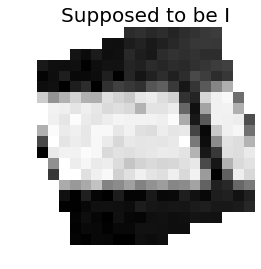

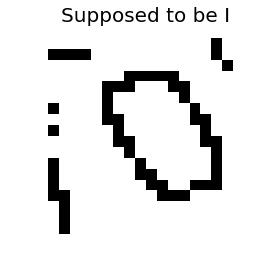

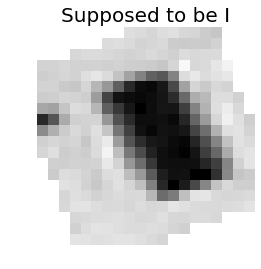

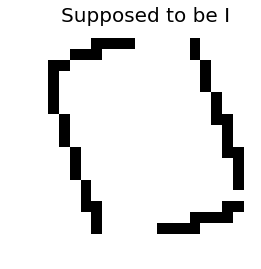

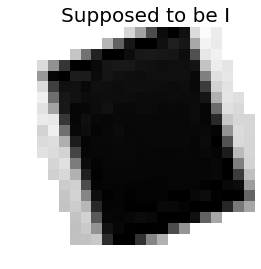

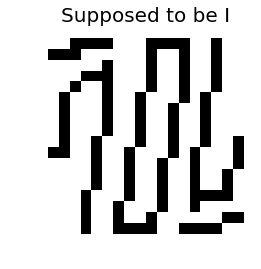

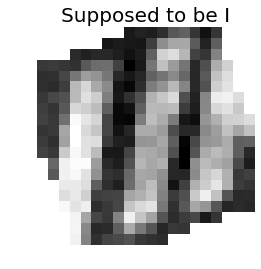

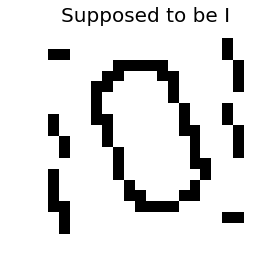

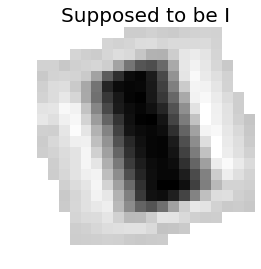

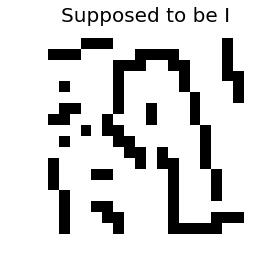

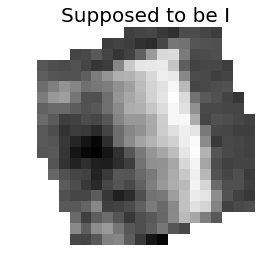

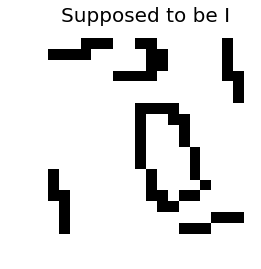

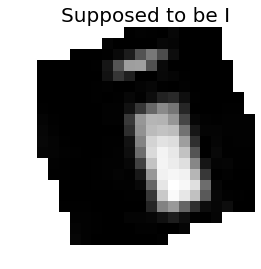

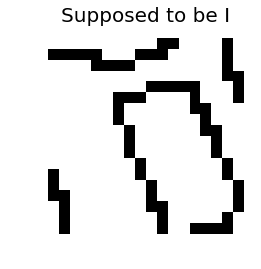

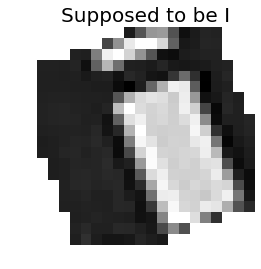

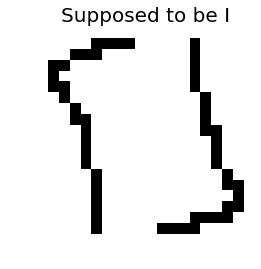

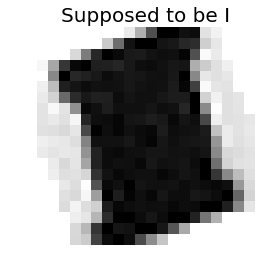

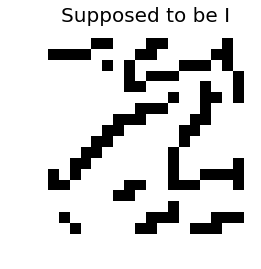

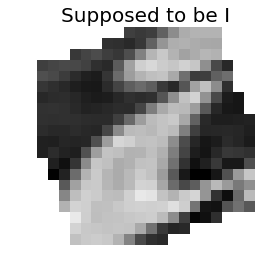

In [15]:
printFromStartToStop(700, 710, data_edges_sigma1_aug20, aug20)